
 Dataset Loaded Successfully!

   Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity  
0          909.4451             87.90  
1          909.4553             87.90  
2          909.4709             87.99  
3          909.4604             88.01  
4          909.4604             88.01  


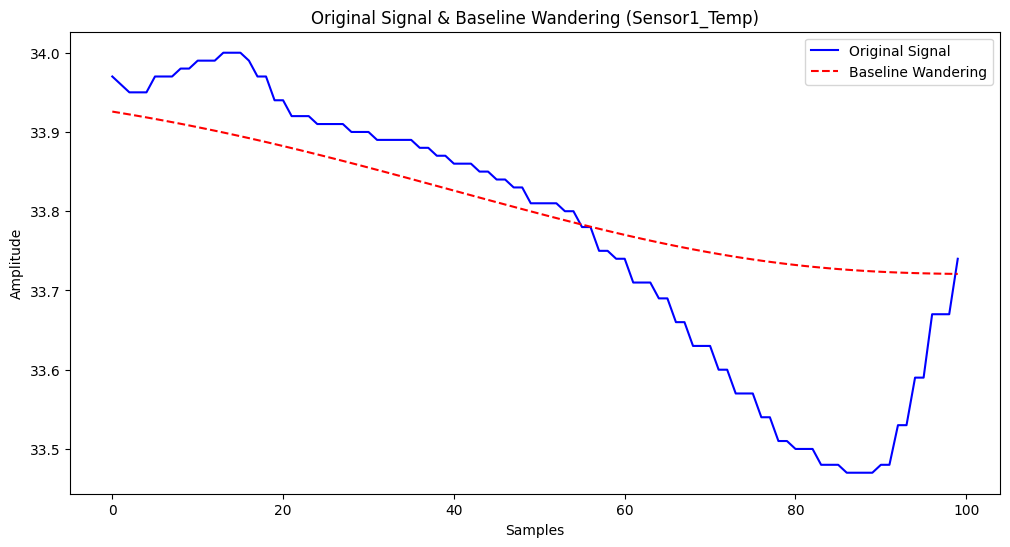

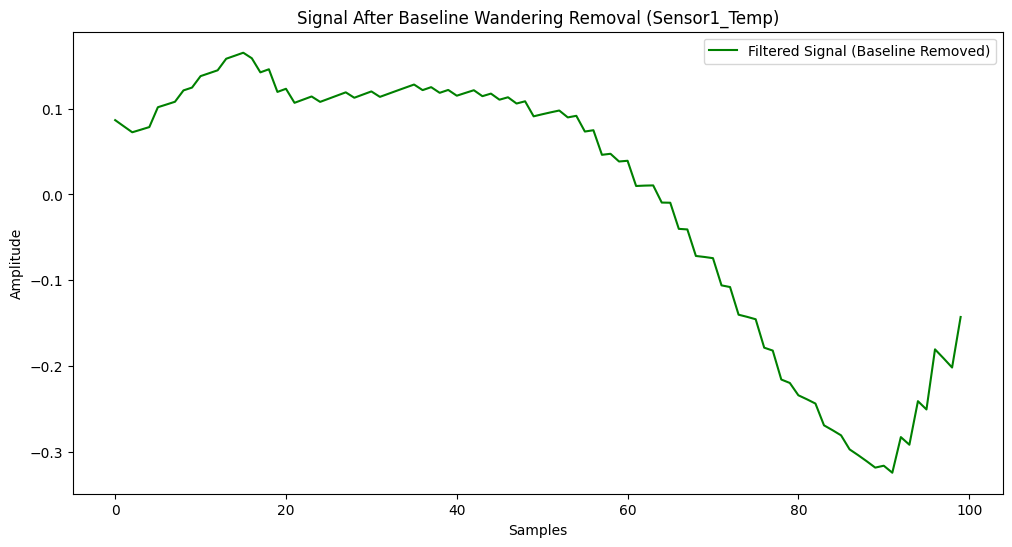

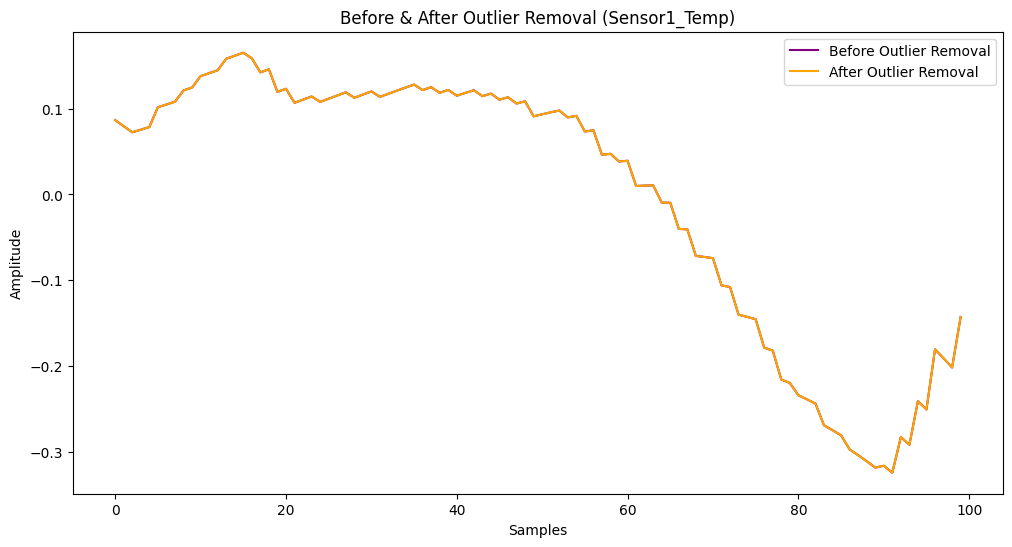

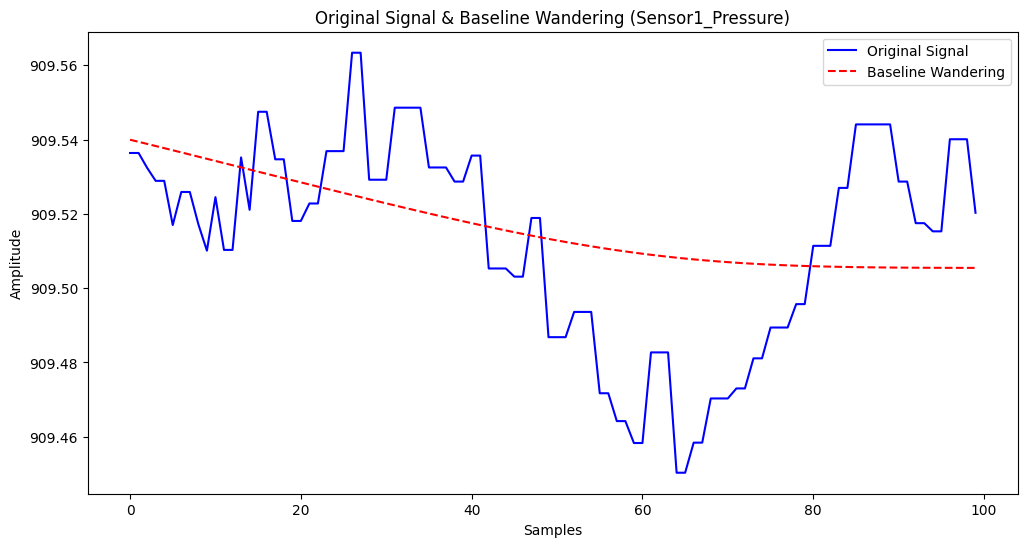

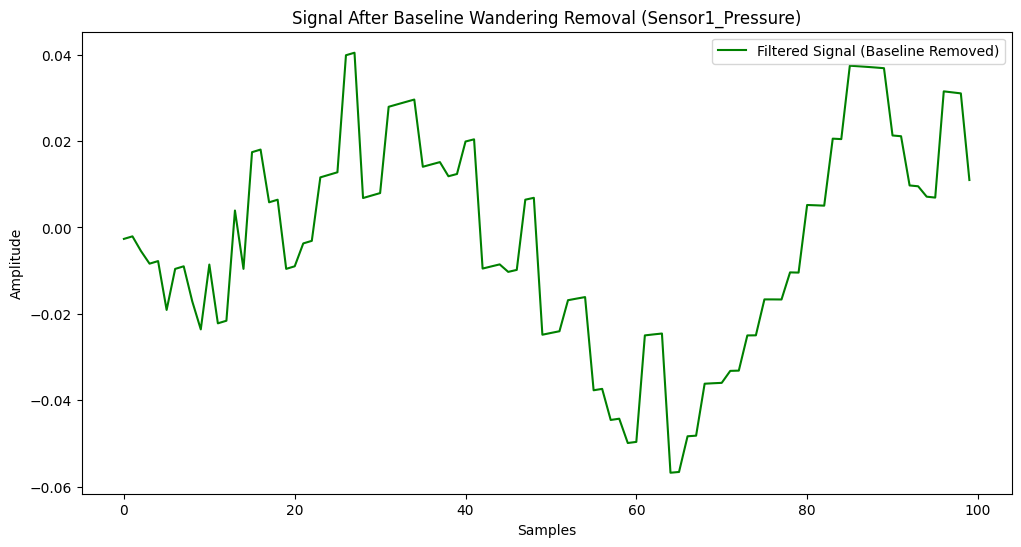

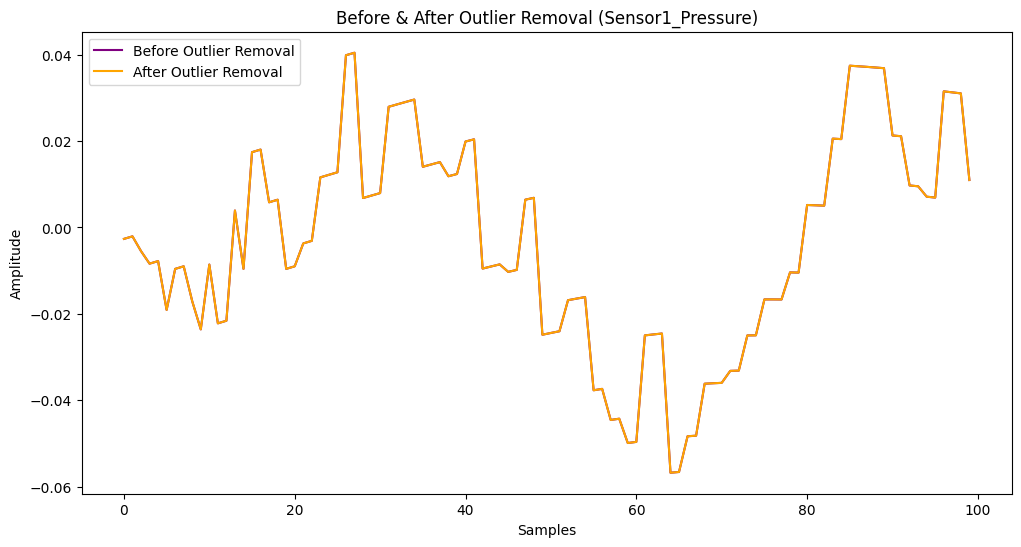

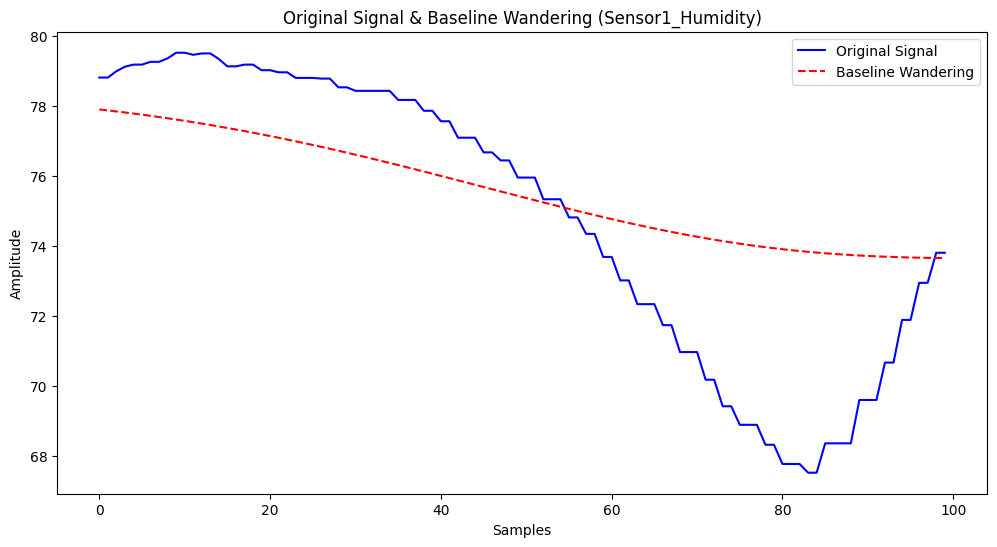

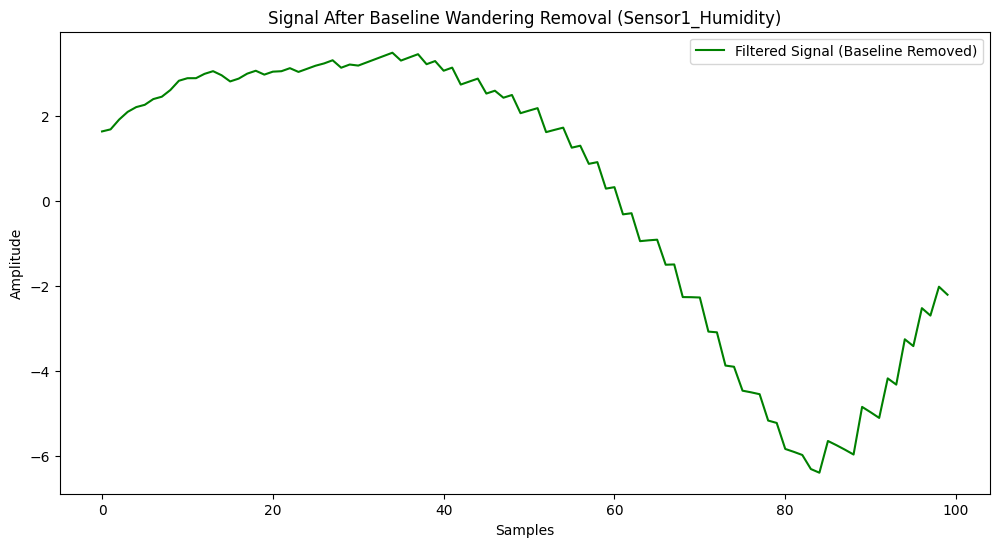

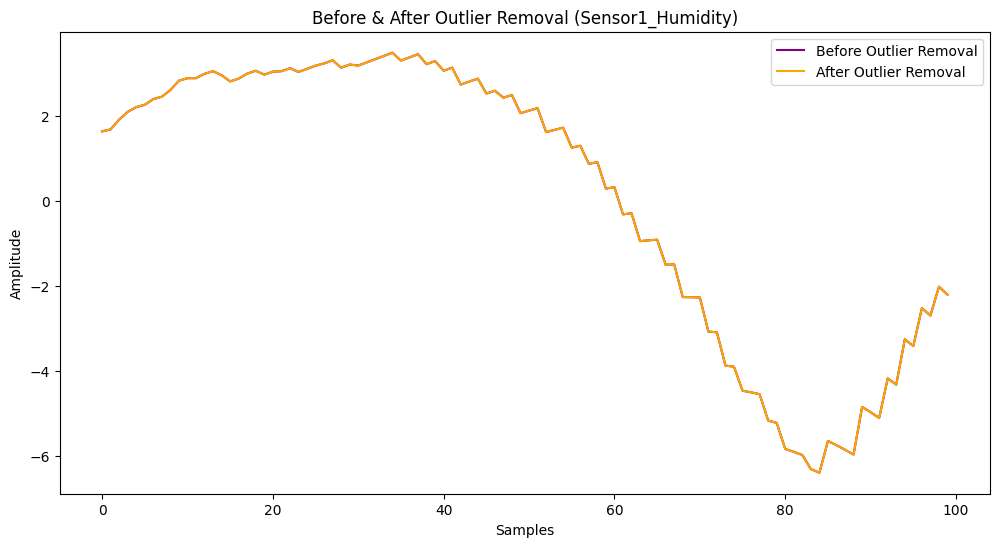

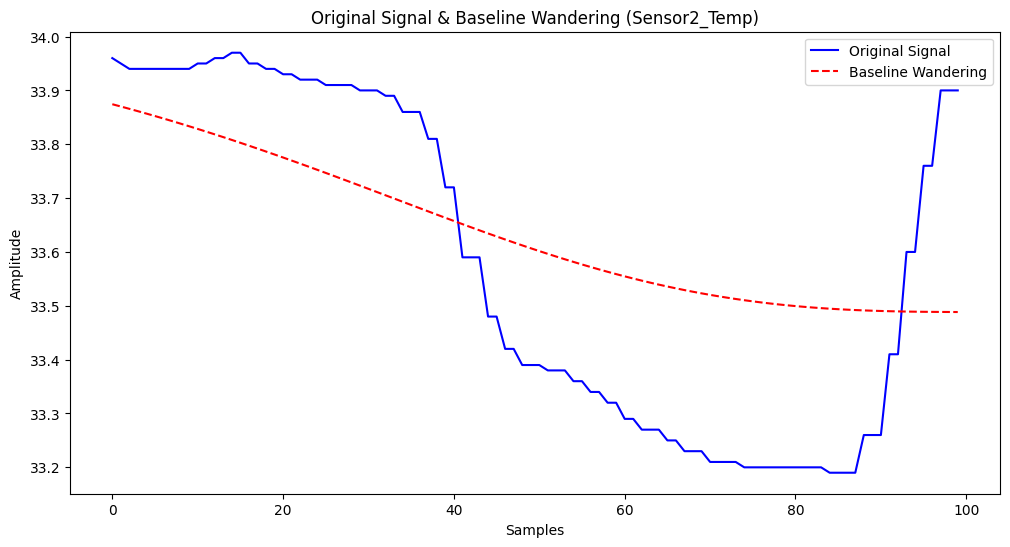

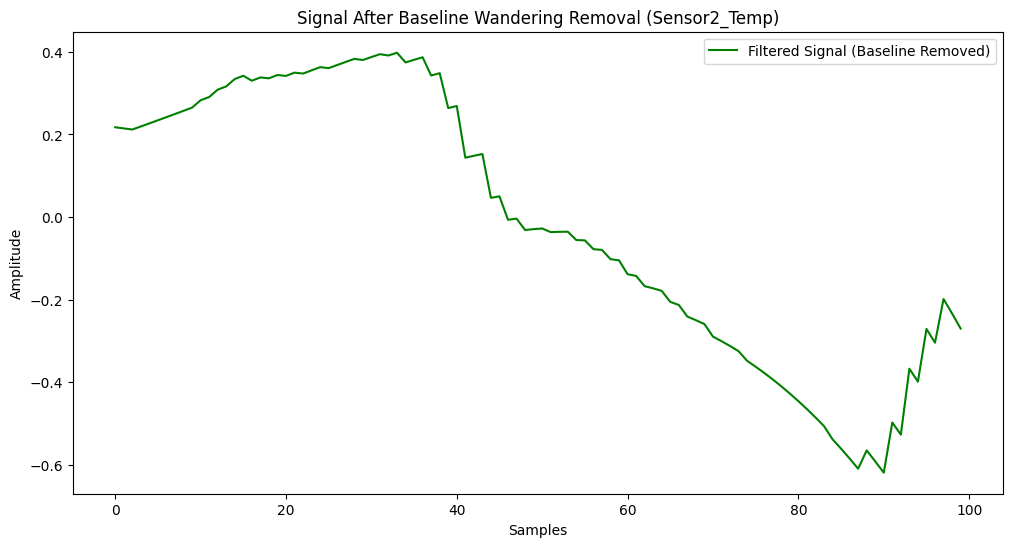

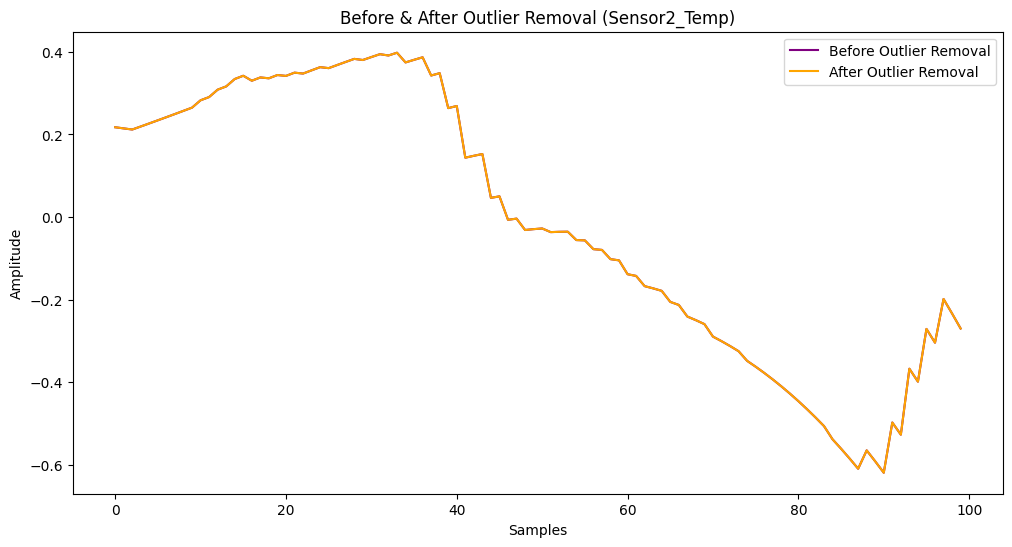

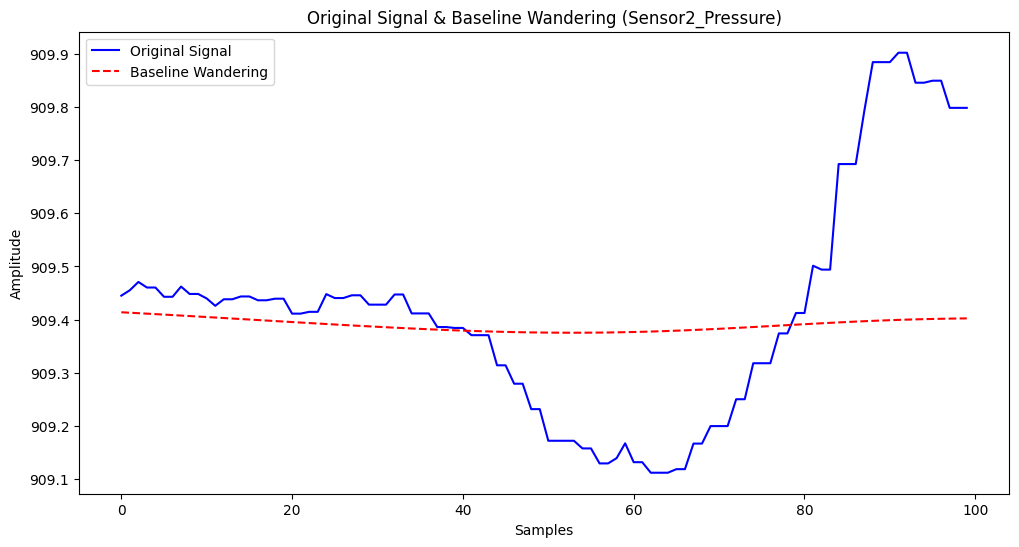

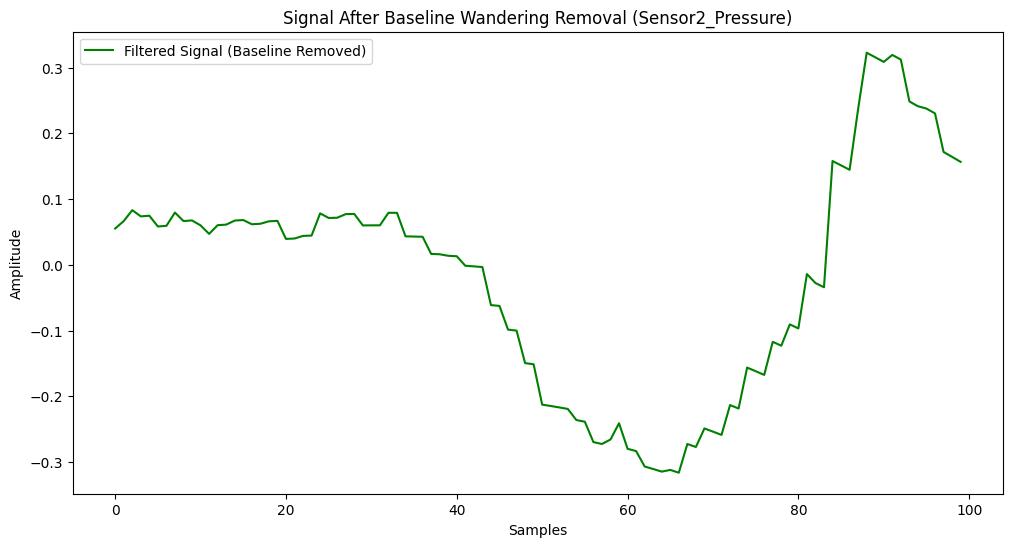

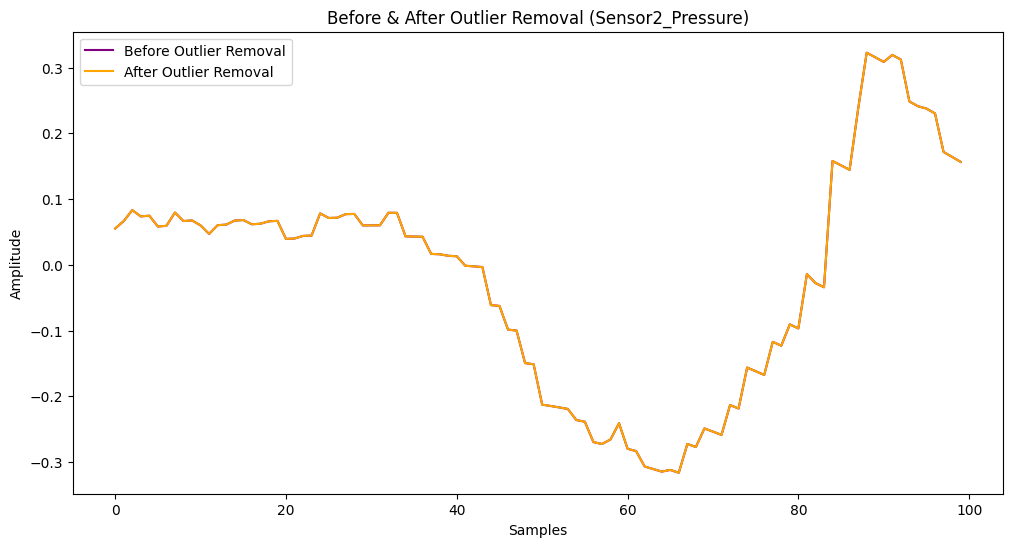

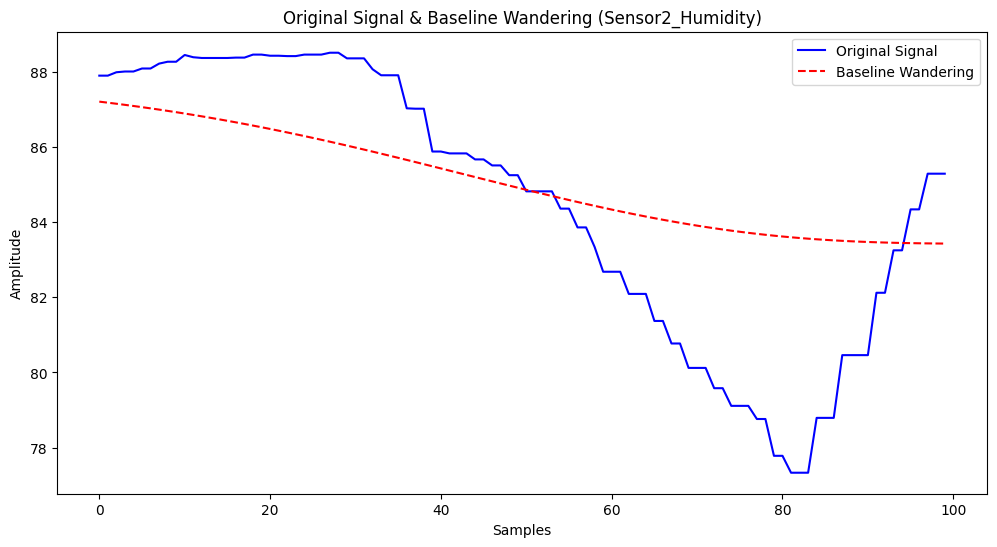

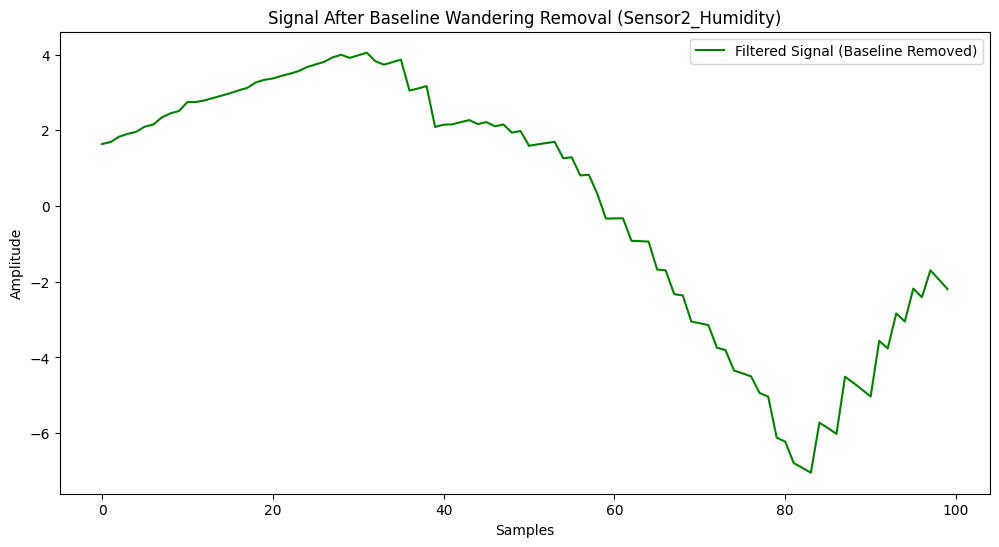

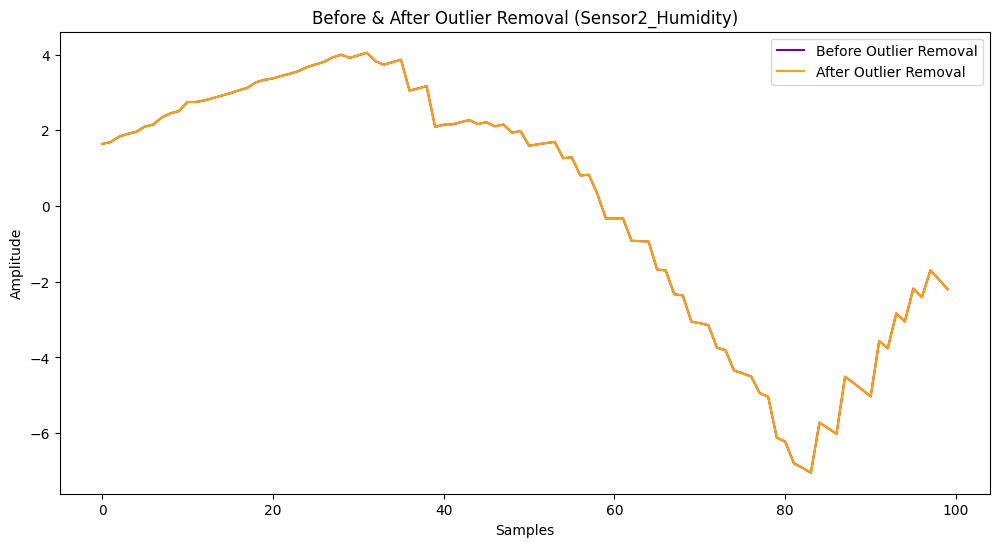

Epoch 1/30
1798/1798 [==============================] - 14s 7ms/step - loss: 0.0060 - mae: 0.0206 - val_loss: 6.2630e-04 - val_mae: 0.0088
Epoch 2/30
1798/1798 [==============================] - 12s 7ms/step - loss: 3.4020e-04 - mae: 0.0073 - val_loss: 5.1189e-04 - val_mae: 0.0064
Epoch 3/30
1798/1798 [==============================] - 14s 8ms/step - loss: 2.6539e-04 - mae: 0.0064 - val_loss: 2.7084e-04 - val_mae: 0.0046
Epoch 4/30
1798/1798 [==============================] - 12s 7ms/step - loss: 2.2339e-04 - mae: 0.0059 - val_loss: 2.6229e-04 - val_mae: 0.0071
Epoch 5/30
1798/1798 [==============================] - 13s 7ms/step - loss: 2.0220e-04 - mae: 0.0054 - val_loss: 2.0170e-04 - val_mae: 0.0051
Epoch 6/30
1798/1798 [==============================] - 12s 7ms/step - loss: 1.8205e-04 - mae: 0.0050 - val_loss: 2.7250e-04 - val_mae: 0.0065
Epoch 7/30
1798/1798 [==============================] - 13s 7ms/step - loss: 1.6696e-04 - mae: 0.0048 - val_loss: 1.9010e-04 - val_mae: 0.0049
Epo

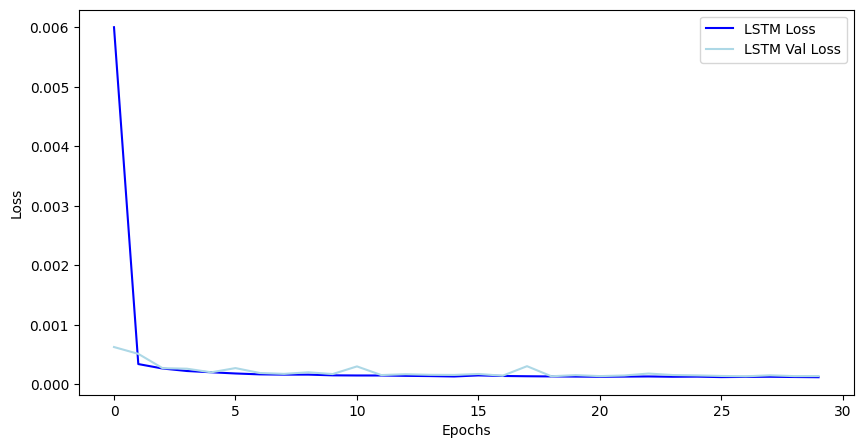

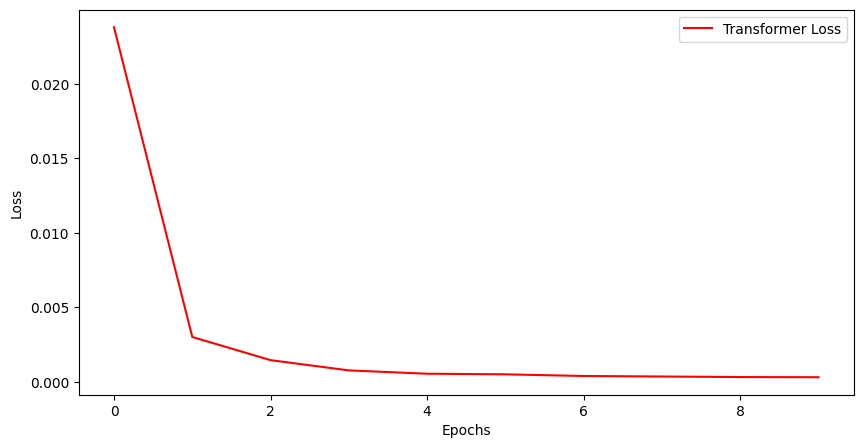

In [1]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files",
                                             filetypes=[("CSV files", "*.csv")])
    return file_paths

# Function to apply a Butterworth high-pass filter
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Function to apply a Butterworth low-pass filter
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Function to remove outliers using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    filtered_signal = np.where(np.abs(z_scores) > threshold, np.median(signal), signal)
    return filtered_signal

# Load dataset
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\n Dataset Loaded Successfully!\n")
    print(df.head())

    # Select only numeric columns
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        for col in numeric_columns:
            signal = df[col].fillna(0)[:100]  # Take first 100 samples
            
            # Extract and remove baseline wandering
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)
            
            # Remove outliers
            outlier_removed_signal = remove_outliers(filtered_signal)

            # Plot original signal and baseline wandering
            plt.figure(figsize=(12, 6))
            plt.plot(signal, label="Original Signal", color='b')
            plt.plot(baseline_wandering, label="Baseline Wandering", color='r', linestyle='dashed')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Original Signal & Baseline Wandering ({col})")
            plt.legend()
            plt.show()

            # Plot signal after baseline wandering removal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Filtered Signal (Baseline Removed)", color='g')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Signal After Baseline Wandering Removal ({col})")
            plt.legend()
            plt.show()

            # Plot before and after outlier removal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Before Outlier Removal", color='purple')
            plt.plot(outlier_removed_signal, label="After Outlier Removal", color='orange')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Before & After Outlier Removal ({col})")
            plt.legend()
            plt.show()

        # Prepare Data for LSTM and Transformer Models
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build and Train LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns))
        ])
        lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        history_lstm = lstm_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        # Build and Train Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return self.fc(x[:, -1, :])  # Return only the last time step


        X_train_torch = torch.tensor(X_train, dtype=torch.float32)
        y_train_torch = torch.tensor(y_train, dtype=torch.float32)
        X_test_torch = torch.tensor(X_test, dtype=torch.float32)
        y_test_torch = torch.tensor(y_test, dtype=torch.float32)

        train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        transformer_losses = []
        num_epochs = 10;
        for epoch in range(num_epochs):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                output = transformer_model(batch_X)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            transformer_losses.append(total_loss / len(train_loader))
            print(f"Epoch {epoch+1}, Transformer Loss: {total_loss:.4f}")

        # Plot LSTM Training History
        plt.figure(figsize=(10, 5))
        plt.plot(history_lstm.history['loss'], label='LSTM Loss', color='blue')
        plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss', color='lightblue')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        # Plot Transformer Training Loss
        plt.figure(figsize=(10, 5))
        plt.plot(transformer_losses, label='Transformer Loss', color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

else:
    print("No file selected. Please upload a valid dataset.")



 Dataset Loaded Successfully!

   Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity  
0          909.4451             87.90  
1          909.4553             87.90  
2          909.4709             87.99  
3          909.4604             88.01  
4          909.4604             88.01  


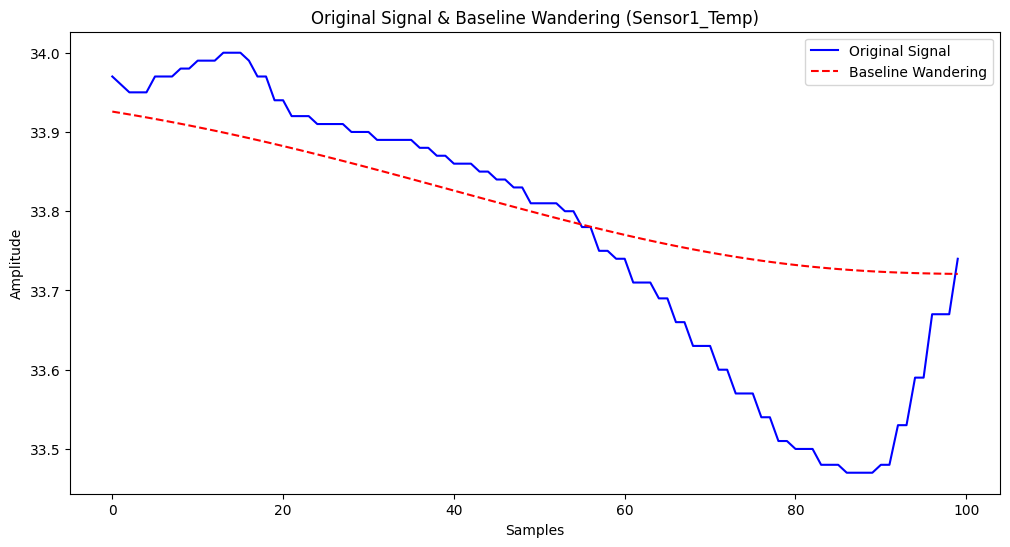

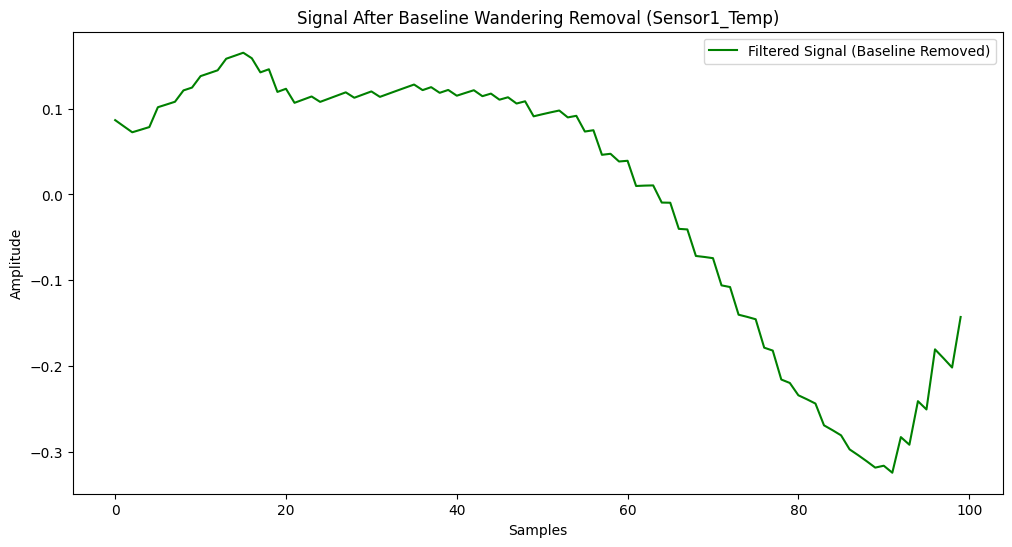

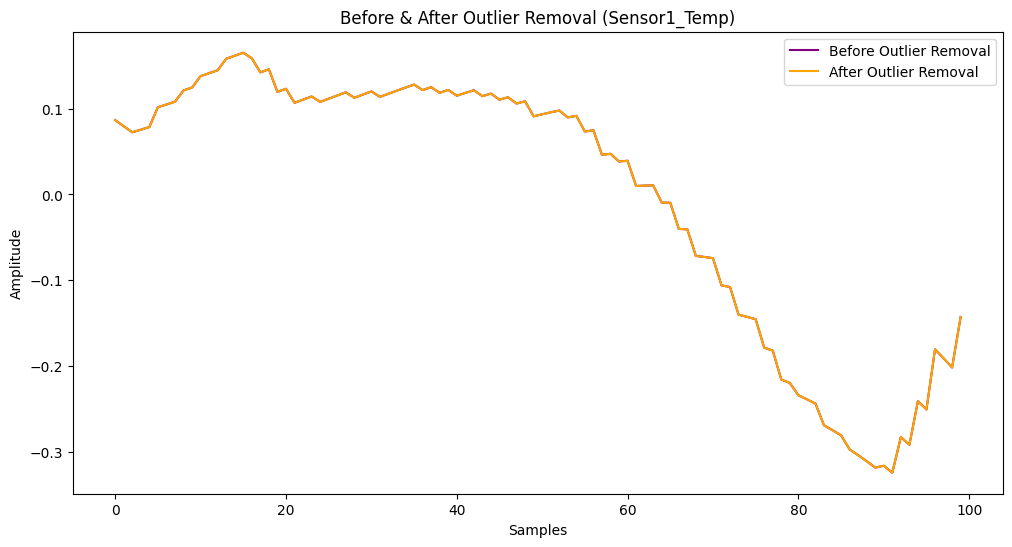

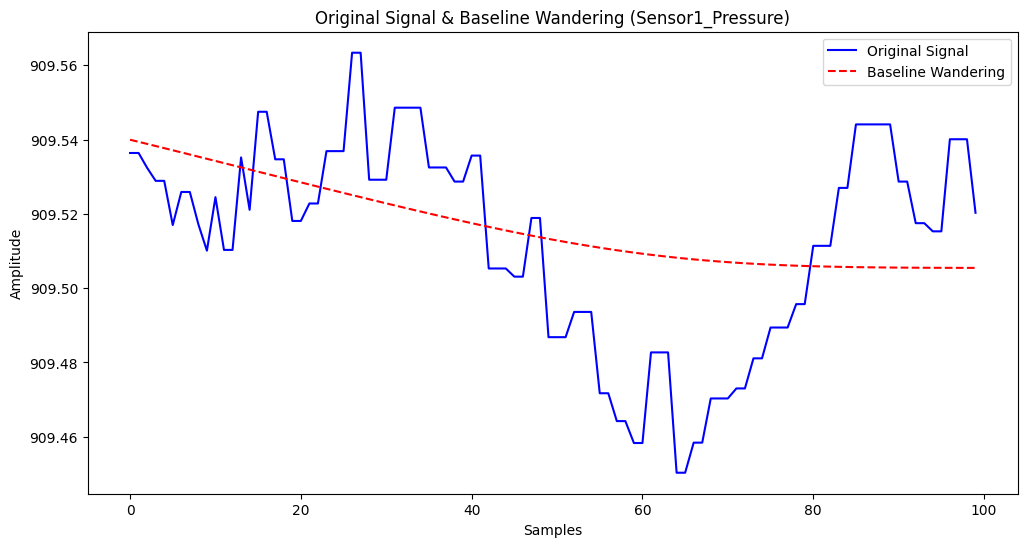

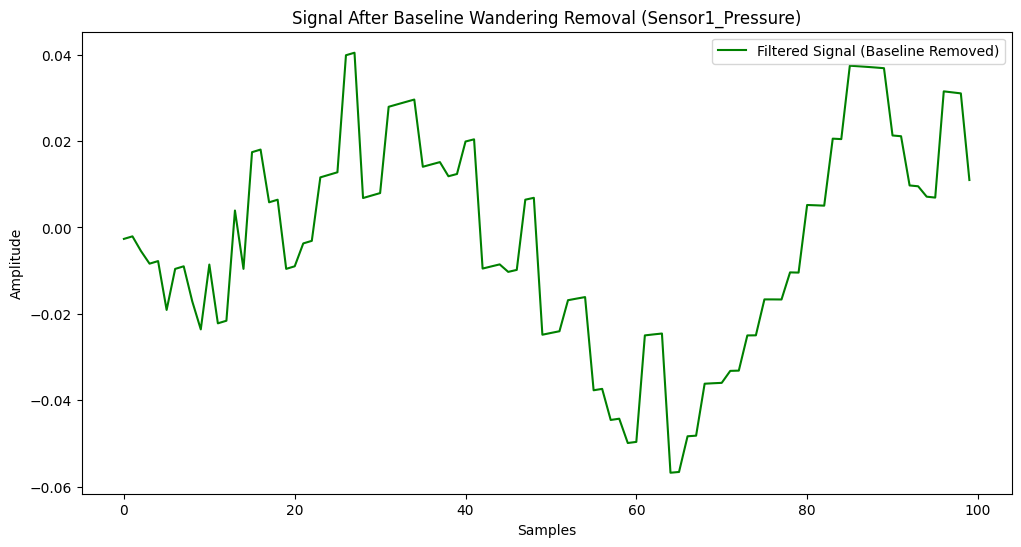

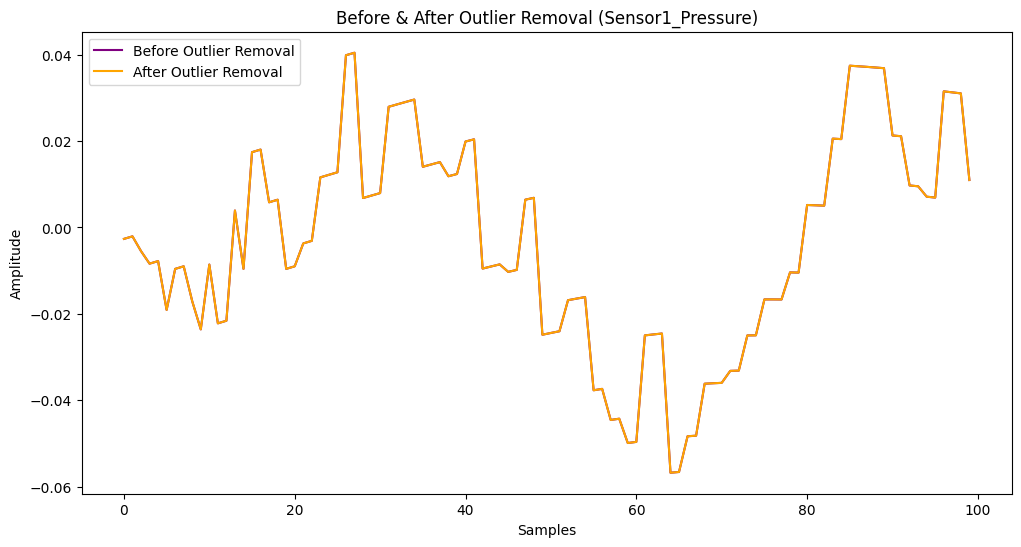

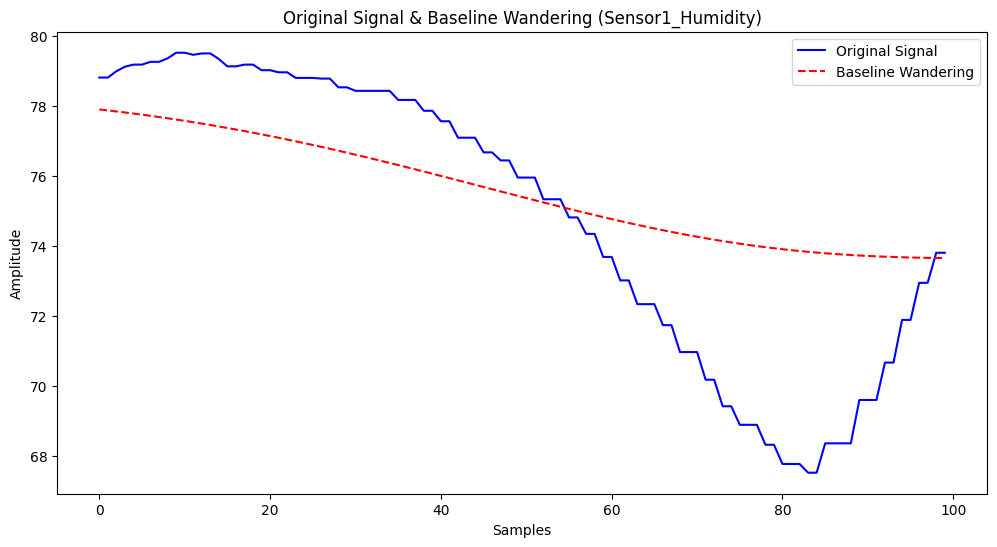

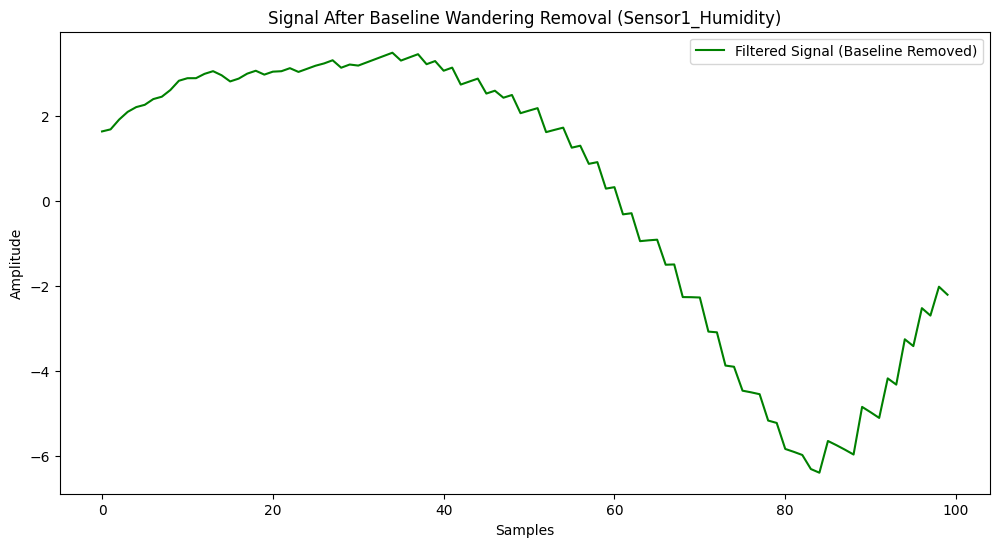

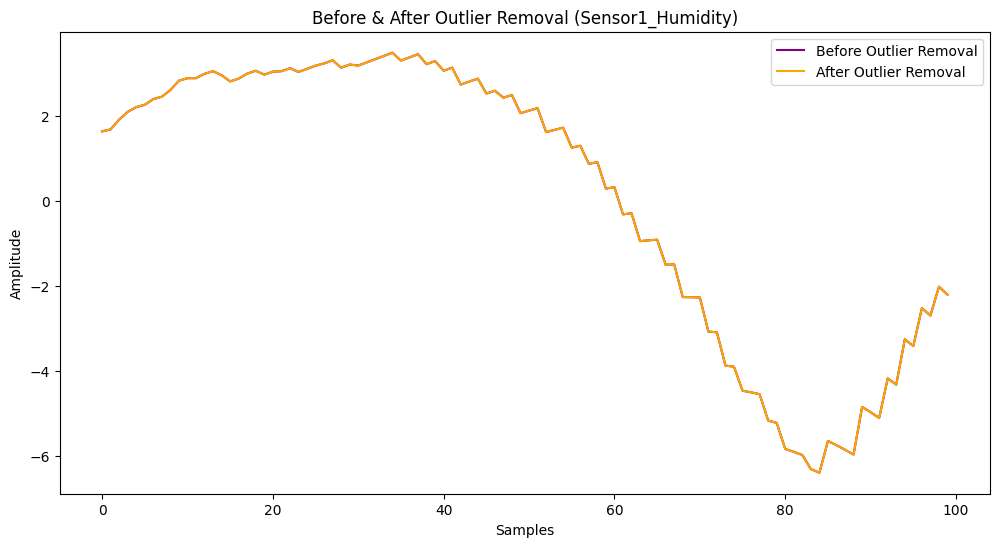

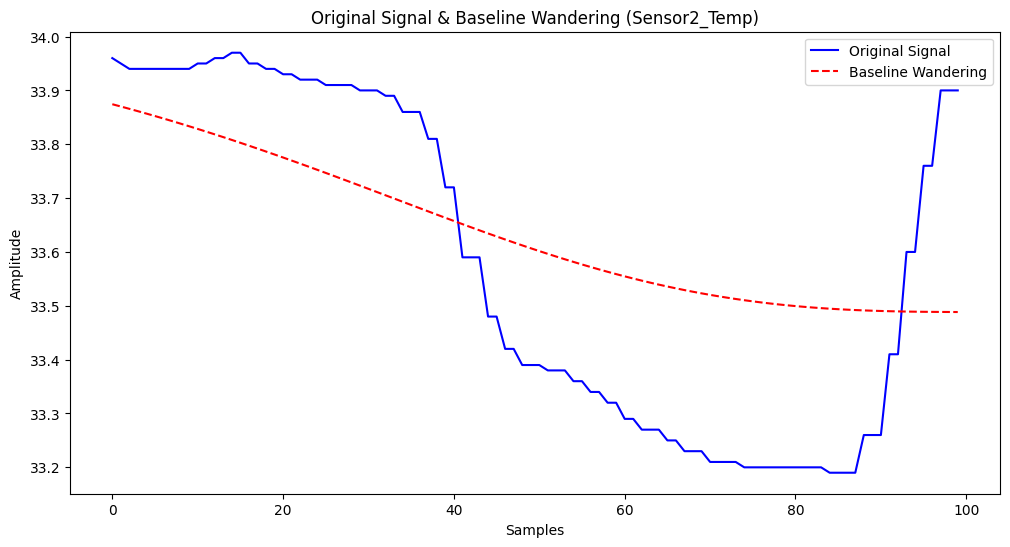

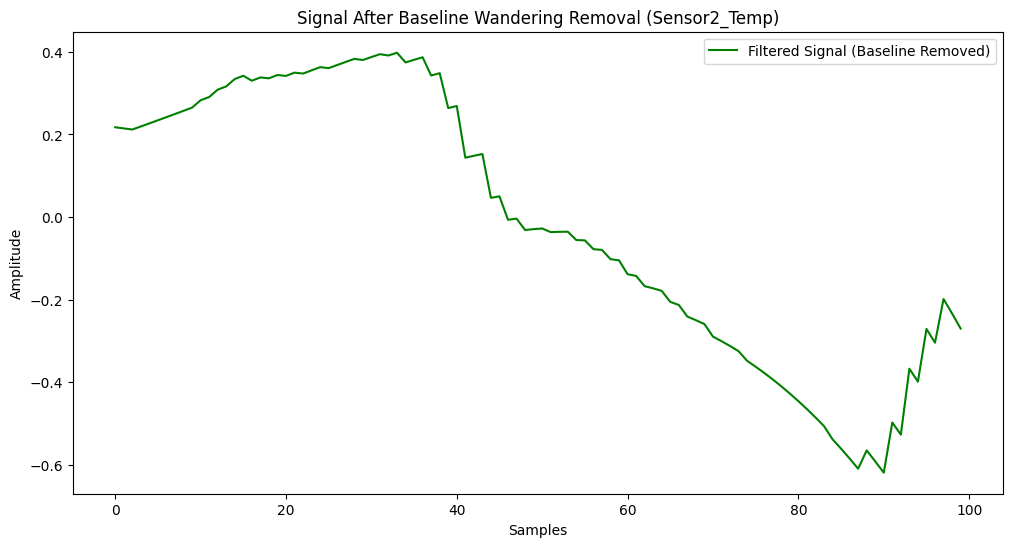

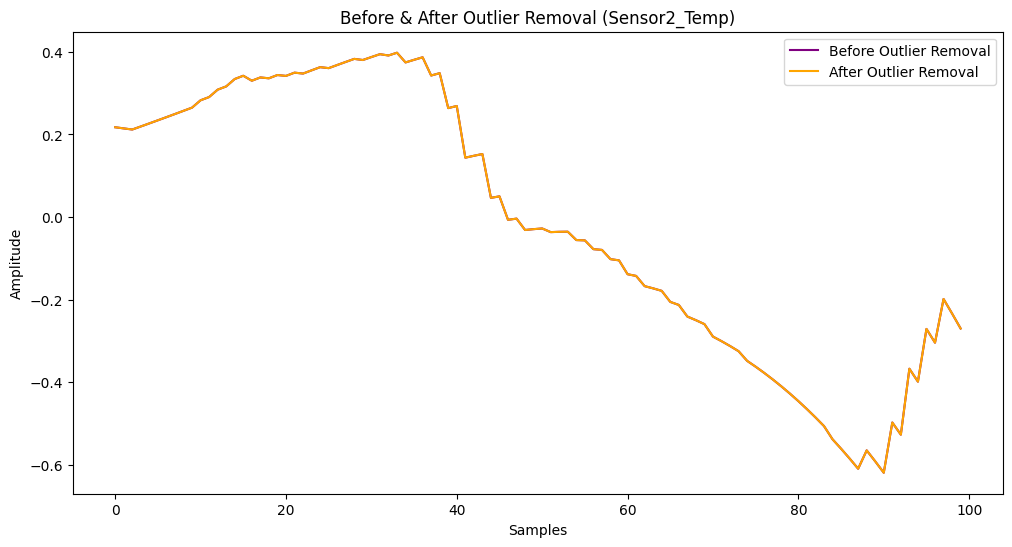

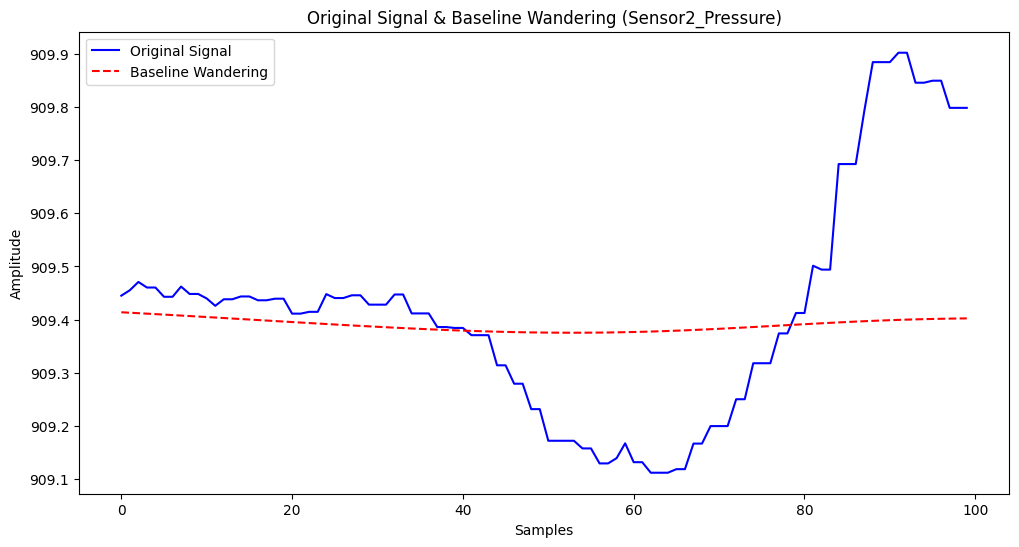

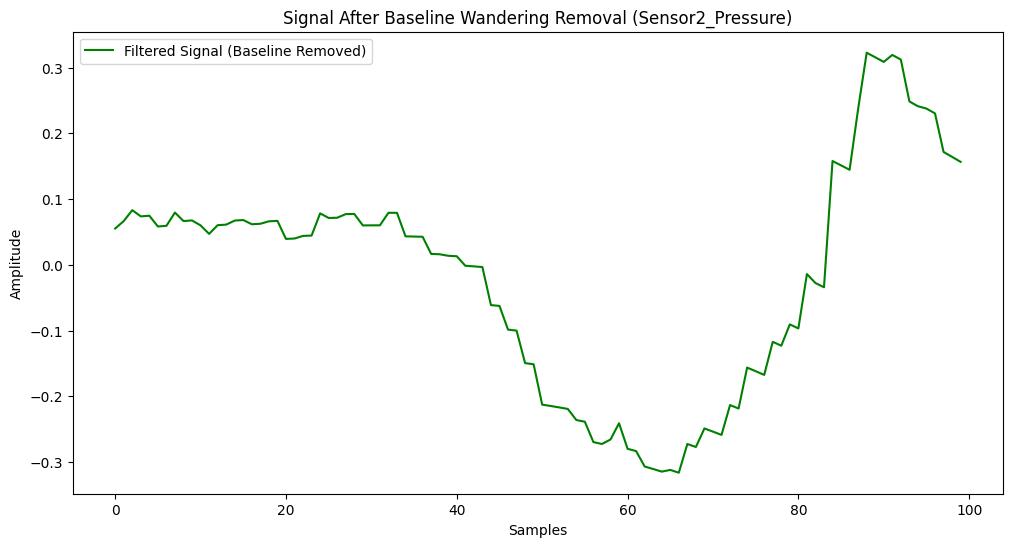

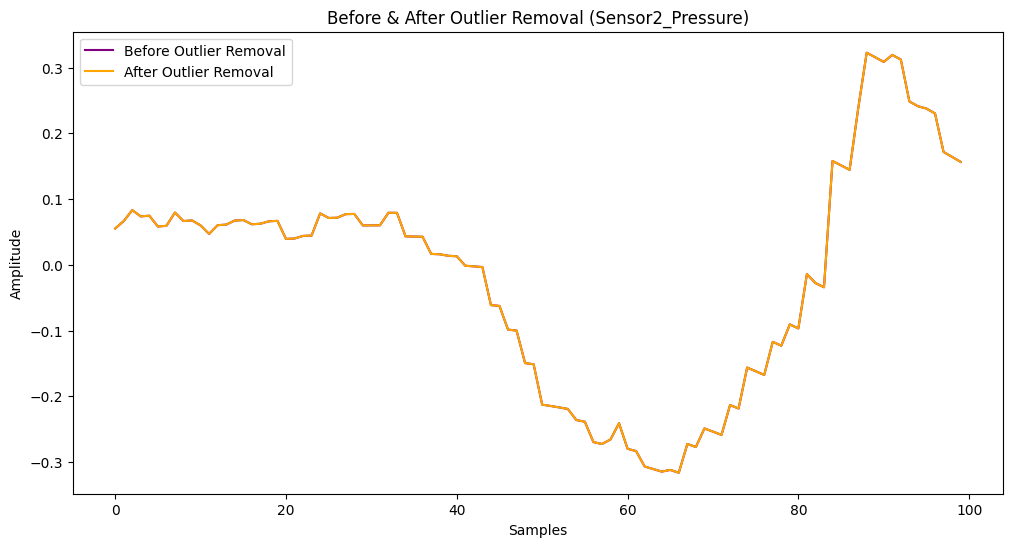

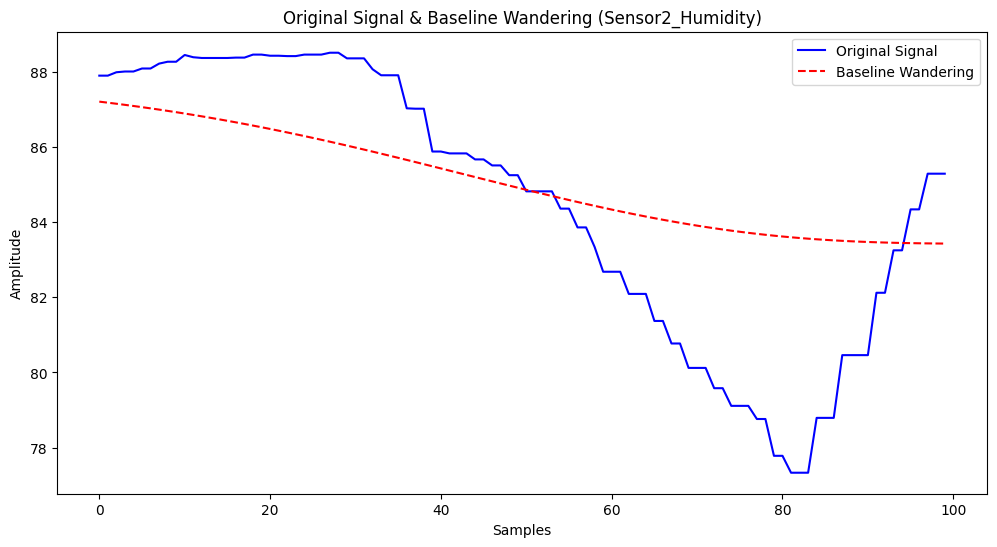

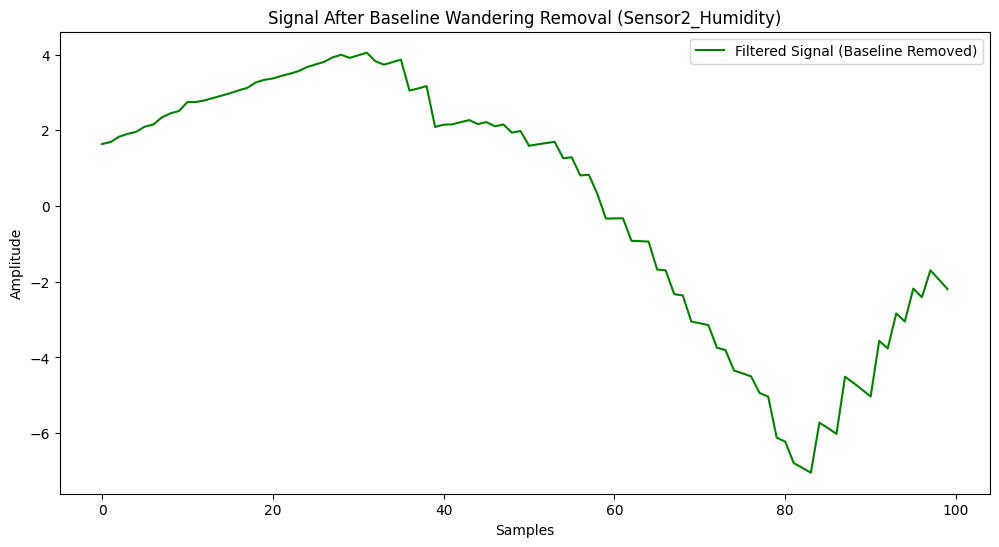

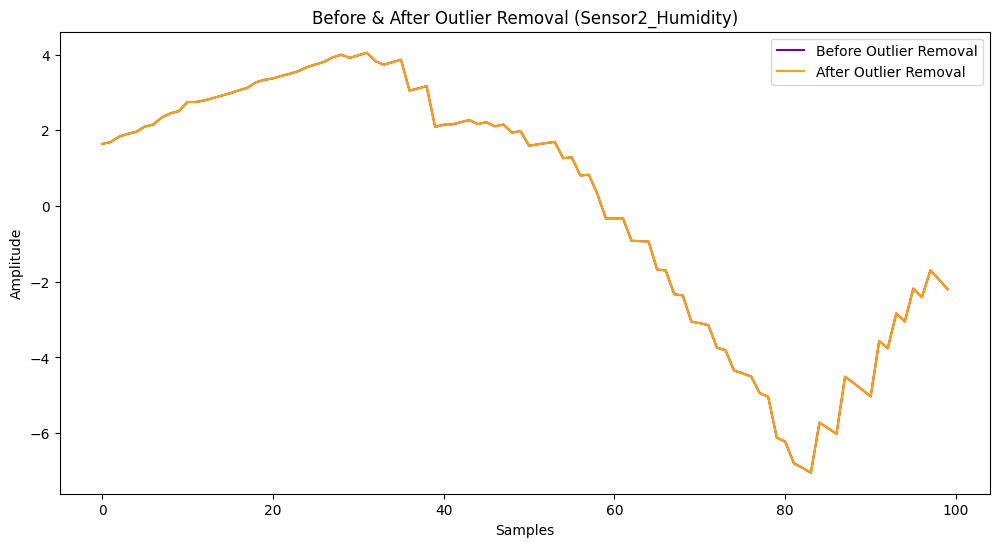

Epoch 1/5
1798/1798 [==============================] - 12s 6ms/step - loss: 0.0046 - mae: 0.0176 - val_loss: 6.9204e-04 - val_mae: 0.0099
Epoch 2/5
1798/1798 [==============================] - 11s 6ms/step - loss: 3.3759e-04 - mae: 0.0072 - val_loss: 4.4716e-04 - val_mae: 0.0059
Epoch 3/5
1798/1798 [==============================] - 12s 7ms/step - loss: 2.7142e-04 - mae: 0.0068 - val_loss: 2.7133e-04 - val_mae: 0.0045
Epoch 4/5
1798/1798 [==============================] - 13s 7ms/step - loss: 2.2614e-04 - mae: 0.0060 - val_loss: 0.0014 - val_mae: 0.0262
Epoch 5/5
1798/1798 [==============================] - 12s 7ms/step - loss: 1.8291e-04 - mae: 0.0051 - val_loss: 2.2350e-04 - val_mae: 0.0057
Epoch 1, Transformer Loss: 40.0949
Epoch 2, Transformer Loss: 4.0840
Epoch 3, Transformer Loss: 2.7090
Epoch 4, Transformer Loss: 2.0035
Epoch 5, Transformer Loss: 1.8035


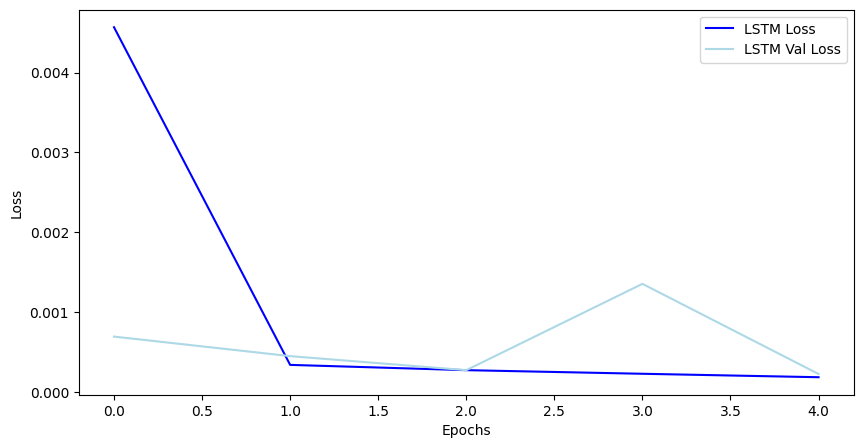

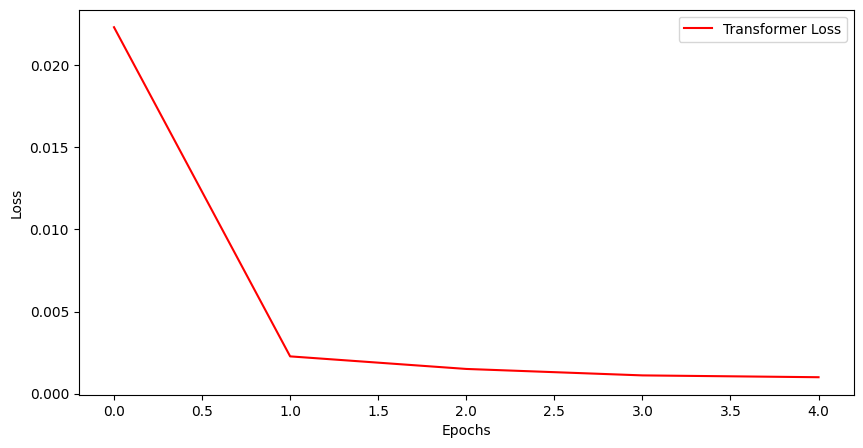

In [2]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files",
                                             filetypes=[("CSV files", "*.csv")])
    return file_paths

# Function to apply a Butterworth high-pass filter
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Function to apply a Butterworth low-pass filter
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Function to remove outliers using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    filtered_signal = np.where(np.abs(z_scores) > threshold, np.median(signal), signal)
    return filtered_signal

# Load dataset
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\n Dataset Loaded Successfully!\n")
    print(df.head())

    # Select only numeric columns
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        for col in numeric_columns:
            signal = df[col].fillna(0)[:100]  # Take first 100 samples
            
            # Extract and remove baseline wandering
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)
            
            # Remove outliers
            outlier_removed_signal = remove_outliers(filtered_signal)

            # Plot original signal and baseline wandering
            plt.figure(figsize=(12, 6))
            plt.plot(signal, label="Original Signal", color='b')
            plt.plot(baseline_wandering, label="Baseline Wandering", color='r', linestyle='dashed')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Original Signal & Baseline Wandering ({col})")
            plt.legend()
            plt.show()

            # Plot signal after baseline wandering removal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Filtered Signal (Baseline Removed)", color='g')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Signal After Baseline Wandering Removal ({col})")
            plt.legend()
            plt.show()

            # Plot before and after outlier removal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Before Outlier Removal", color='purple')
            plt.plot(outlier_removed_signal, label="After Outlier Removal", color='orange')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Before & After Outlier Removal ({col})")
            plt.legend()
            plt.show()

        # Prepare Data for LSTM and Transformer Models
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build and Train LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns))
        ])
        lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Train LSTM Model for 5 epochs
        history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        # Build and Train Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return self.fc(x[:, -1, :])  # Return only the last time step

        # Convert data to PyTorch tensors
        X_train_torch = torch.tensor(X_train, dtype=torch.float32)
        y_train_torch = torch.tensor(y_train, dtype=torch.float32)
        X_test_torch = torch.tensor(X_test, dtype=torch.float32)
        y_test_torch = torch.tensor(y_test, dtype=torch.float32)

        train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)

        # Initialize Transformer model
        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        # Train Transformer Model for 5 epochs
        transformer_losses = []
        num_epochs = 5
        for epoch in range(num_epochs):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                output = transformer_model(batch_X)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            transformer_losses.append(total_loss / len(train_loader))
            print(f"Epoch {epoch+1}, Transformer Loss: {total_loss:.4f}")

        # Plot LSTM Training History
        plt.figure(figsize=(10, 5))
        plt.plot(history_lstm.history['loss'], label='LSTM Loss', color='blue')
        plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss', color='lightblue')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        # Plot Transformer Training Loss
        plt.figure(figsize=(10, 5))
        plt.plot(transformer_losses, label='Transformer Loss', color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

else:
    print("No file selected. Please upload a valid dataset.")



 Dataset Loaded Successfully!

   Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         32.87          912.4941             56.17         33.56   
1         32.89          912.5181             57.33         33.56   
2         32.89          912.5181             57.33         33.56   
3         32.90          912.5188             58.26         33.56   
4         32.91          912.5279             59.36         33.56   

   Sensor2_Pressure  Sensor2_Humidity  
0          912.0020             70.74  
1          912.0090             70.97  
2          912.0494             70.99  
3          912.0494             70.99  
4          912.0669             71.57  

Training models for 10 epochs...

Epoch 1/10
229/229 [==============================] - 4s 7ms/step - loss: 0.3578 - accuracy: 0.4578 - val_loss: 0.2986 - val_accuracy: 0.0000e+00
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2251 - accuracy: 0.4732 - val_loss: 0.2866 - val_accurac

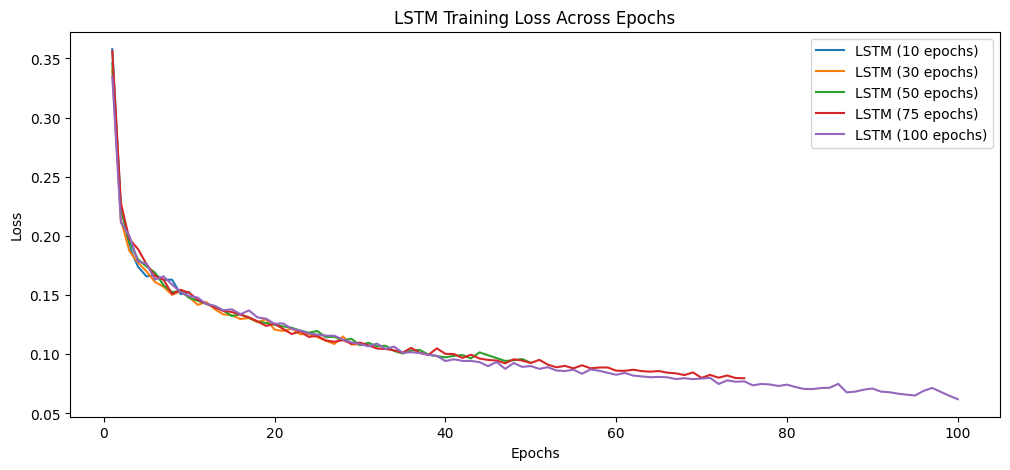

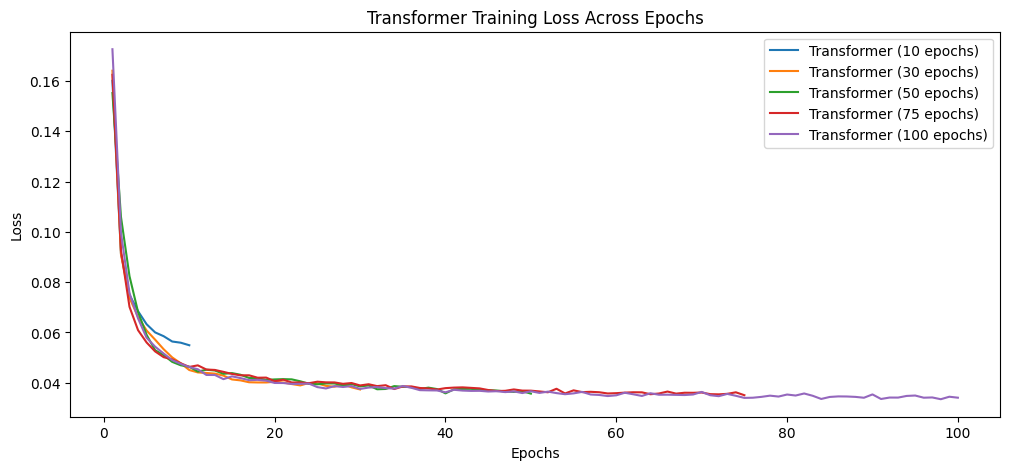

In [3]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# Butterworth high-pass filter
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Remove outliers using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Load dataset
file_paths = load_files()
if not file_paths:
    print("No file selected. Please upload a valid dataset.")
    exit()

dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes, ignore_index=True)

print("\n Dataset Loaded Successfully!\n")
print(df.head())

# Select only numeric columns
numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
if not numeric_columns:
    print("No numeric columns found in the dataset.")
    exit()

scaler = MinMaxScaler()
processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

# Create sequences for training
X, y = [], []
seq_length = 10
for i in range(len(processed_data) - seq_length):
    X.append(processed_data[i:i+seq_length])
    y.append(processed_data[i+seq_length])

X, y = np.array(X), np.array(y)

# Convert target variable to binary classification (0 or 1)
threshold = 0.5
y = (y > threshold).astype(int)

# Split data (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
        LSTM(50, activation='relu'),
        Dense(len(numeric_columns), activation='sigmoid')  # Use sigmoid for binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        return torch.sigmoid(self.fc(x[:, -1, :]))  # Use sigmoid activation

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert continuous predictions to binary labels
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true, y_pred)  # Regression loss
    return accuracy, specificity, f1, loss

# Training loop for different epochs
epochs_list = [10, 30, 50, 75, 100]
performance_data = []
training_history = {}

for num_epochs in epochs_list:
    print(f"\nTraining models for {num_epochs} epochs...\n")

    # Train LSTM
    lstm_model = build_lstm_model()
    history_lstm = lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, validation_data=(X_test, y_test), verbose=1)
    y_pred_lstm = lstm_model.predict(X_test)
    lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

    # Train Transformer
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)

    transformer_model = TransformerModel(input_dim=len(numeric_columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

    transformer_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = transformer_model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        transformer_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs} - Transformer Loss: {transformer_losses[-1]:.4f}")

    y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
    transformer_acc, transformer_spec, transformer_f1, transformer_loss = calculate_metrics(y_test, y_pred_transformer)

    performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1, transformer_loss, transformer_acc, transformer_spec, transformer_f1])

    # Save training history
    training_history[num_epochs] = {
        "LSTM Loss": history_lstm.history['loss'],
        "LSTM Accuracy": history_lstm.history['accuracy'],
        "Transformer Loss": transformer_losses
    }

# Convert performance data to DataFrame
performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score", "Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1 Score"])
print(performance_df)

# Plot individual metrics
plt.figure(figsize=(12, 5))
for num_epochs in epochs_list:
    plt.plot(range(1, num_epochs + 1), training_history[num_epochs]["LSTM Loss"], label=f"LSTM ({num_epochs} epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training Loss Across Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for num_epochs in epochs_list:
    plt.plot(range(1, num_epochs + 1), training_history[num_epochs]["Transformer Loss"], label=f"Transformer ({num_epochs} epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Transformer Training Loss Across Epochs")
plt.legend()
plt.show()



 Dataset Loaded Successfully!

   Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.38          912.3455             33.19         33.98   
1         33.35          912.3578             32.72         33.98   
2         33.35          912.3578             32.72         33.96   
3         33.33          912.4076             32.67         33.96   
4         33.33          912.4076             32.67         33.96   

   Sensor2_Pressure  Sensor2_Humidity  
0          911.2548             53.20  
1          911.2548             53.20  
2          911.3259             53.65  
3          911.3259             53.65  
4          911.3259             54.69  


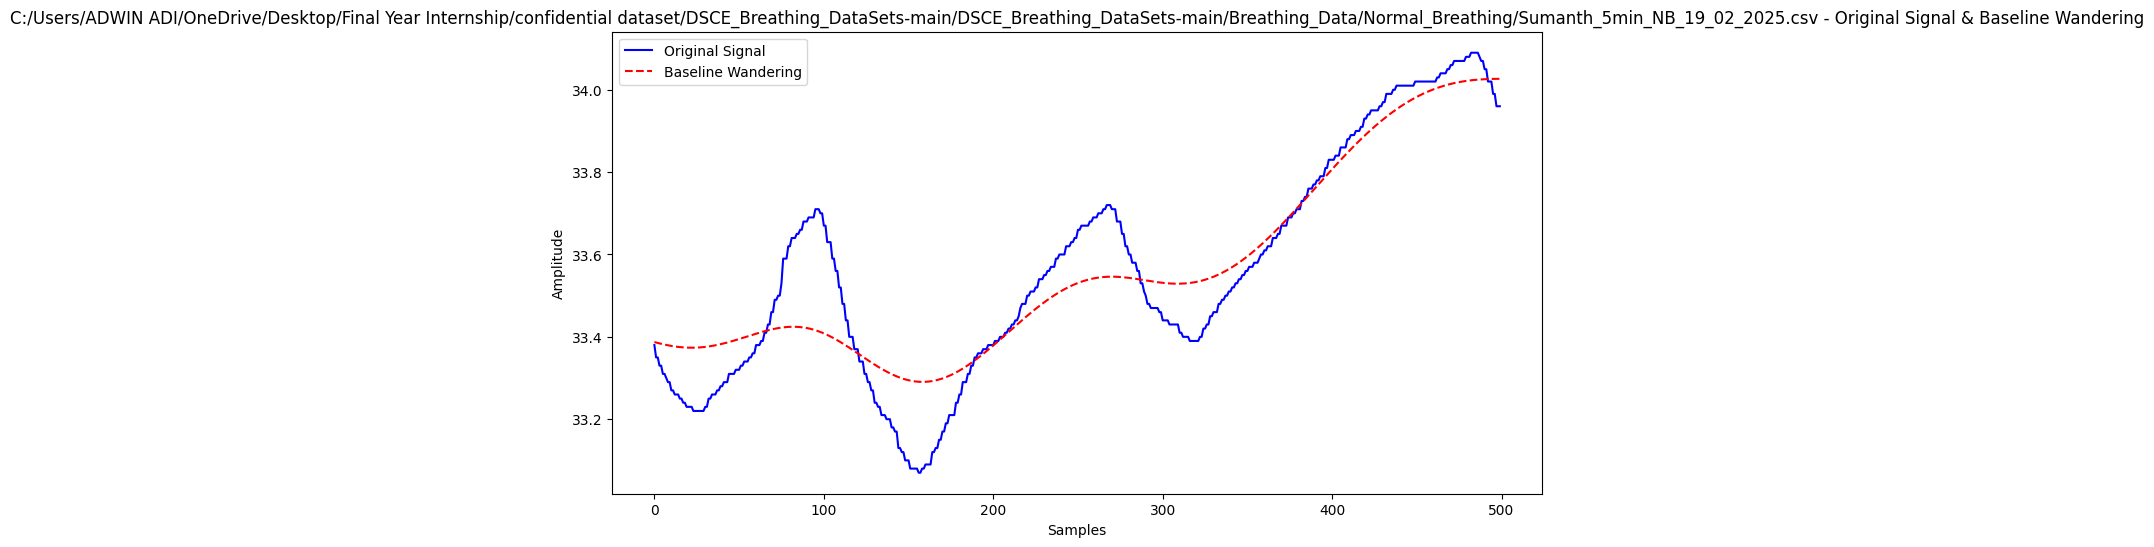

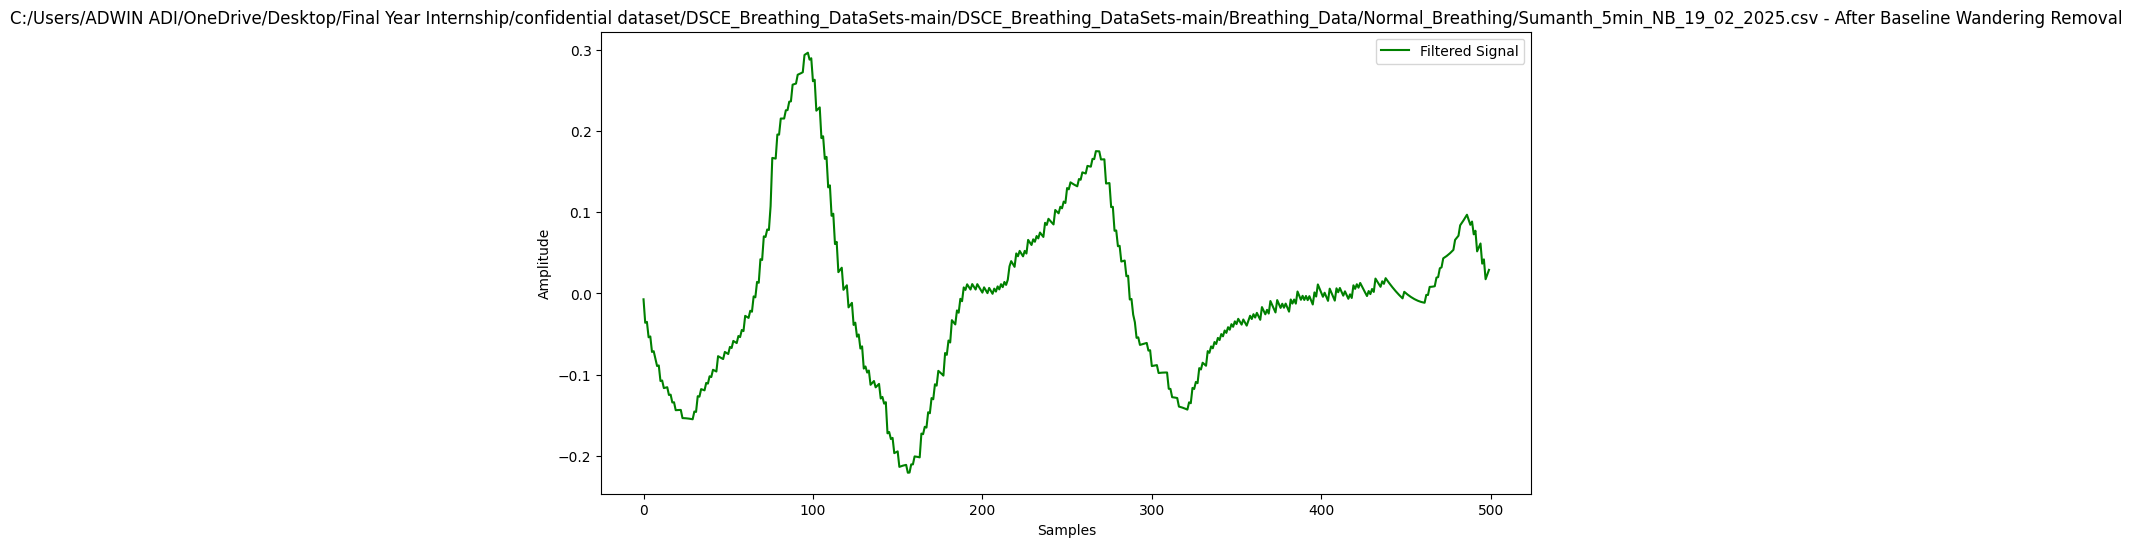

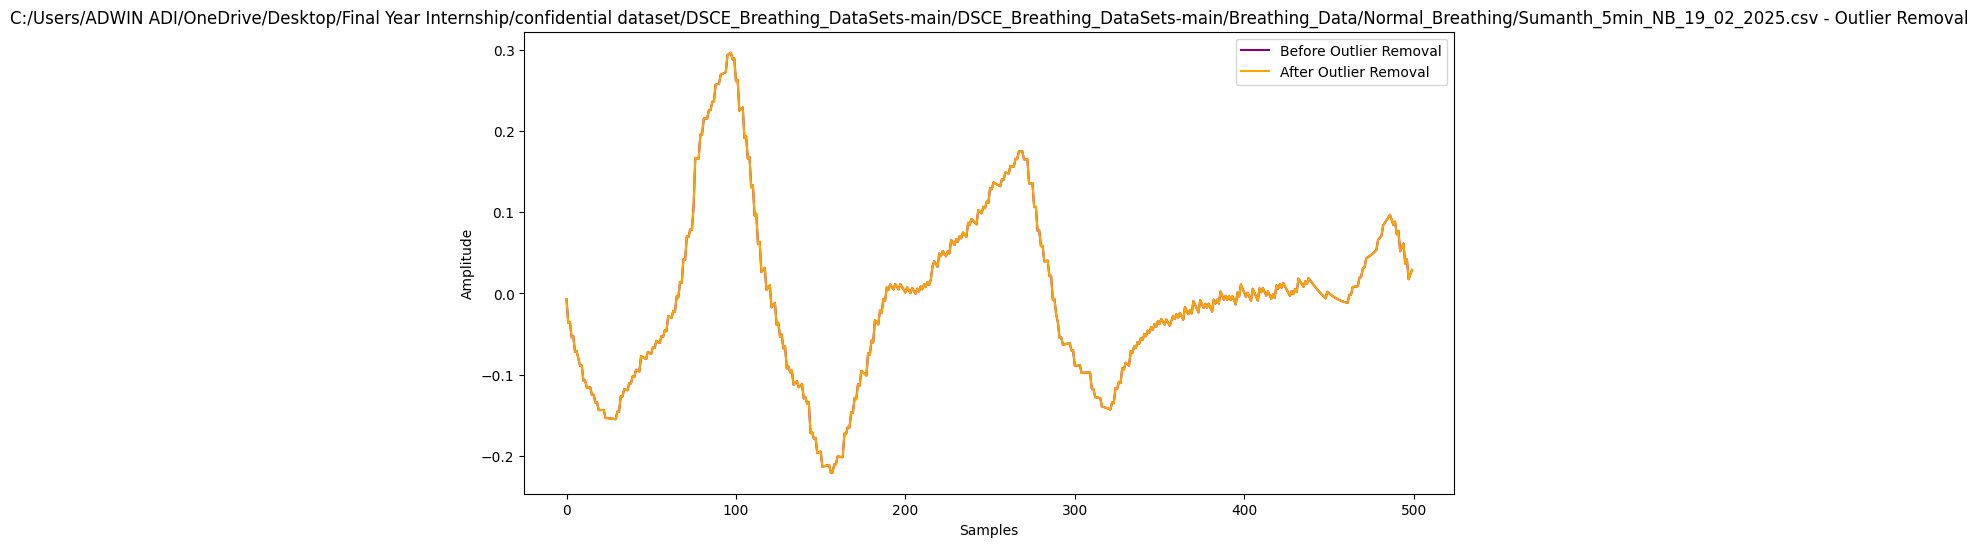

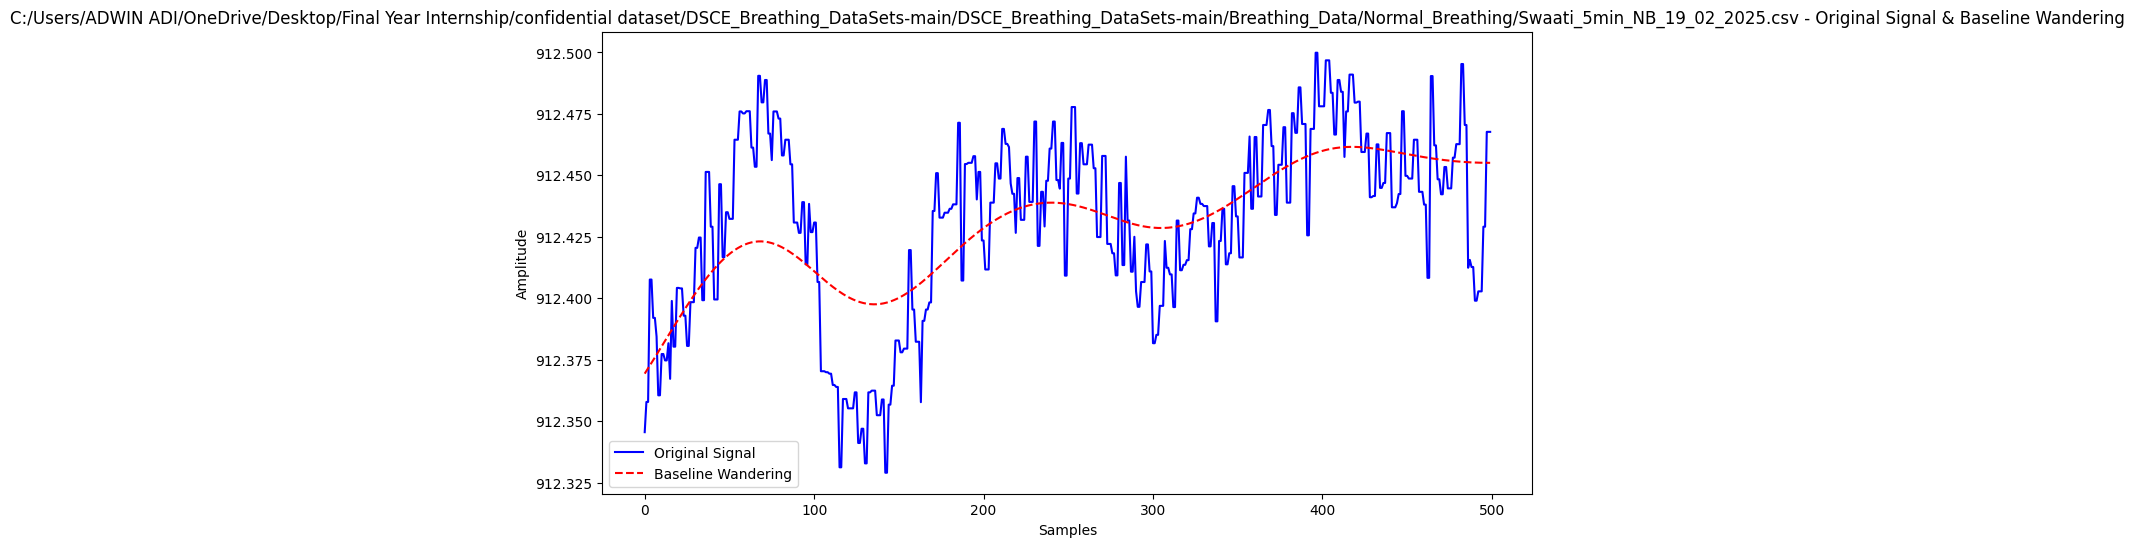

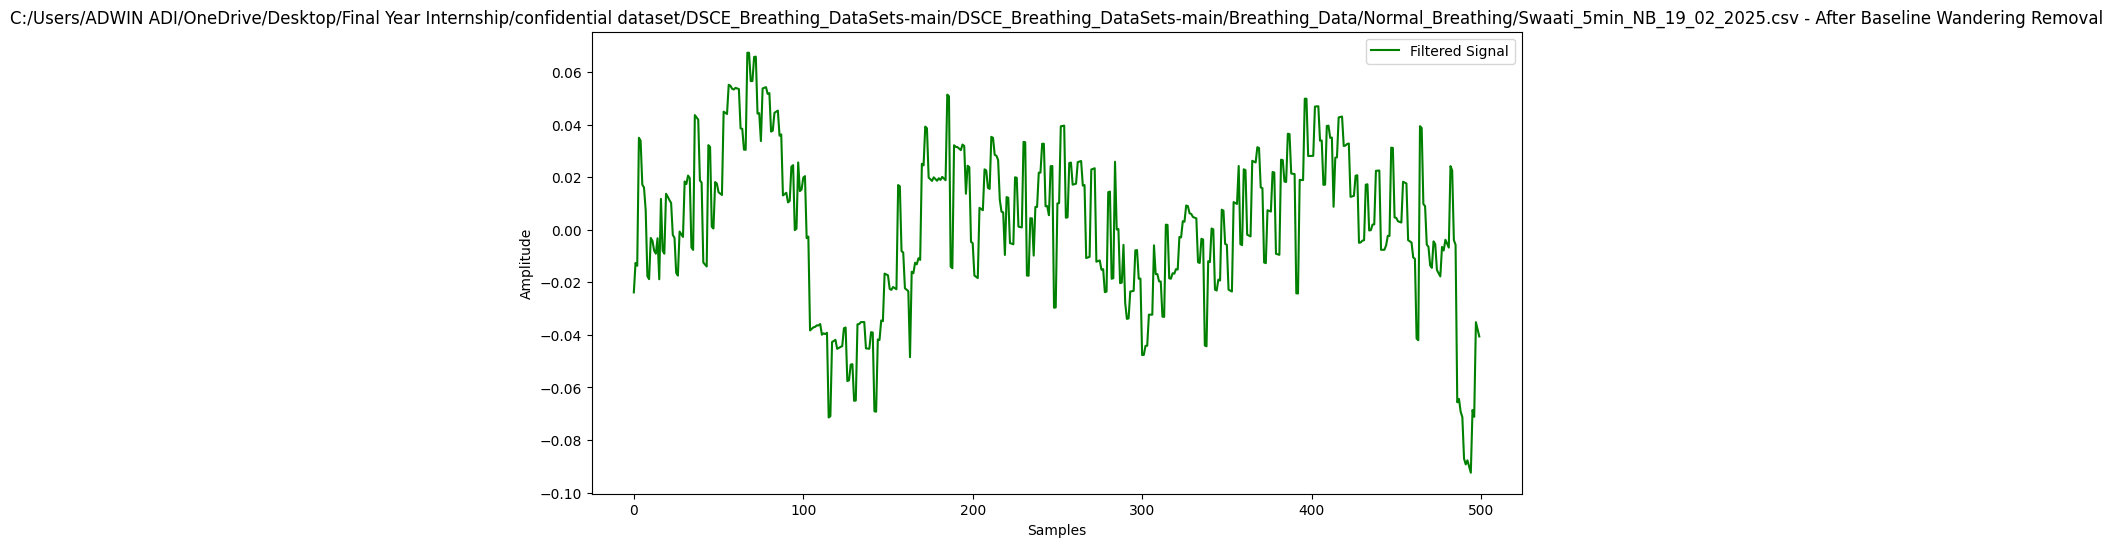

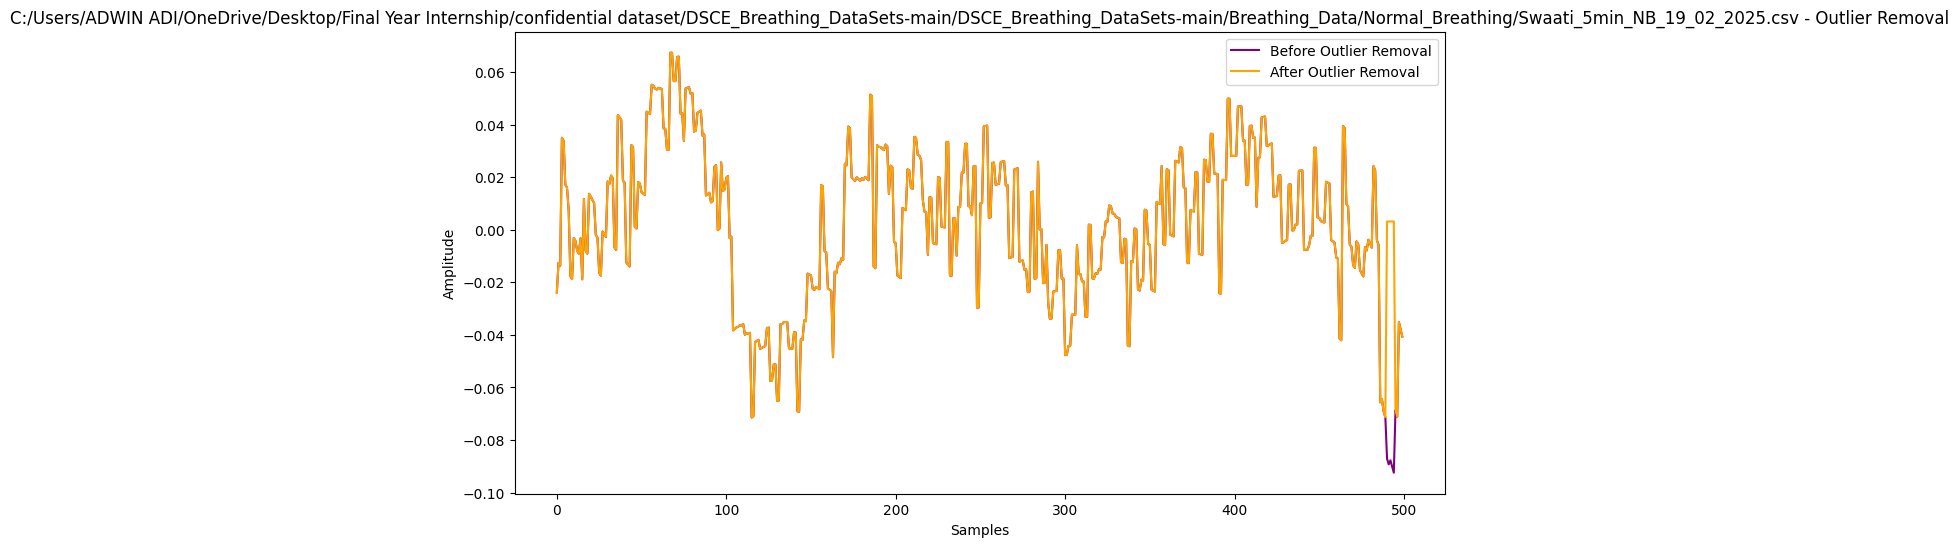

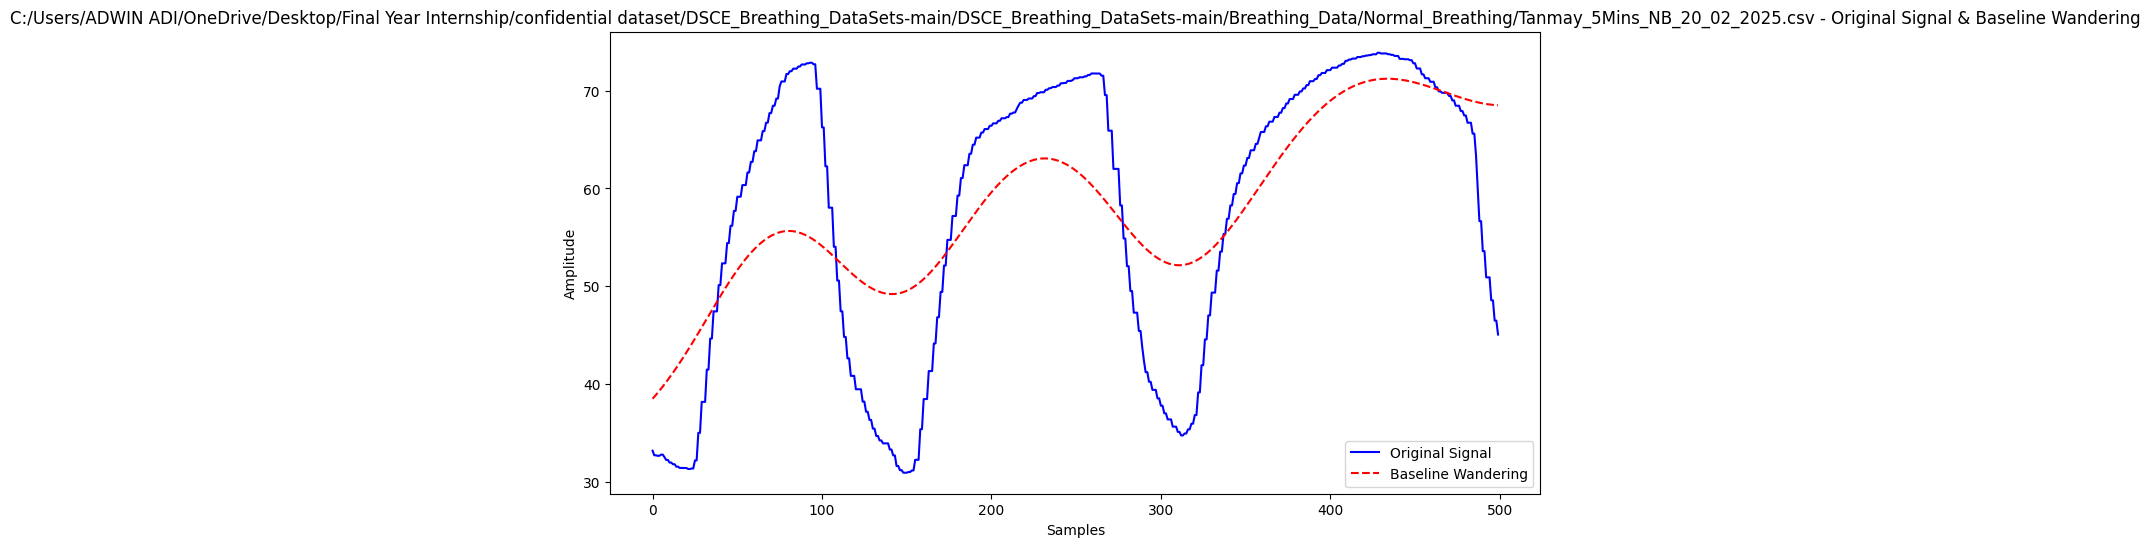

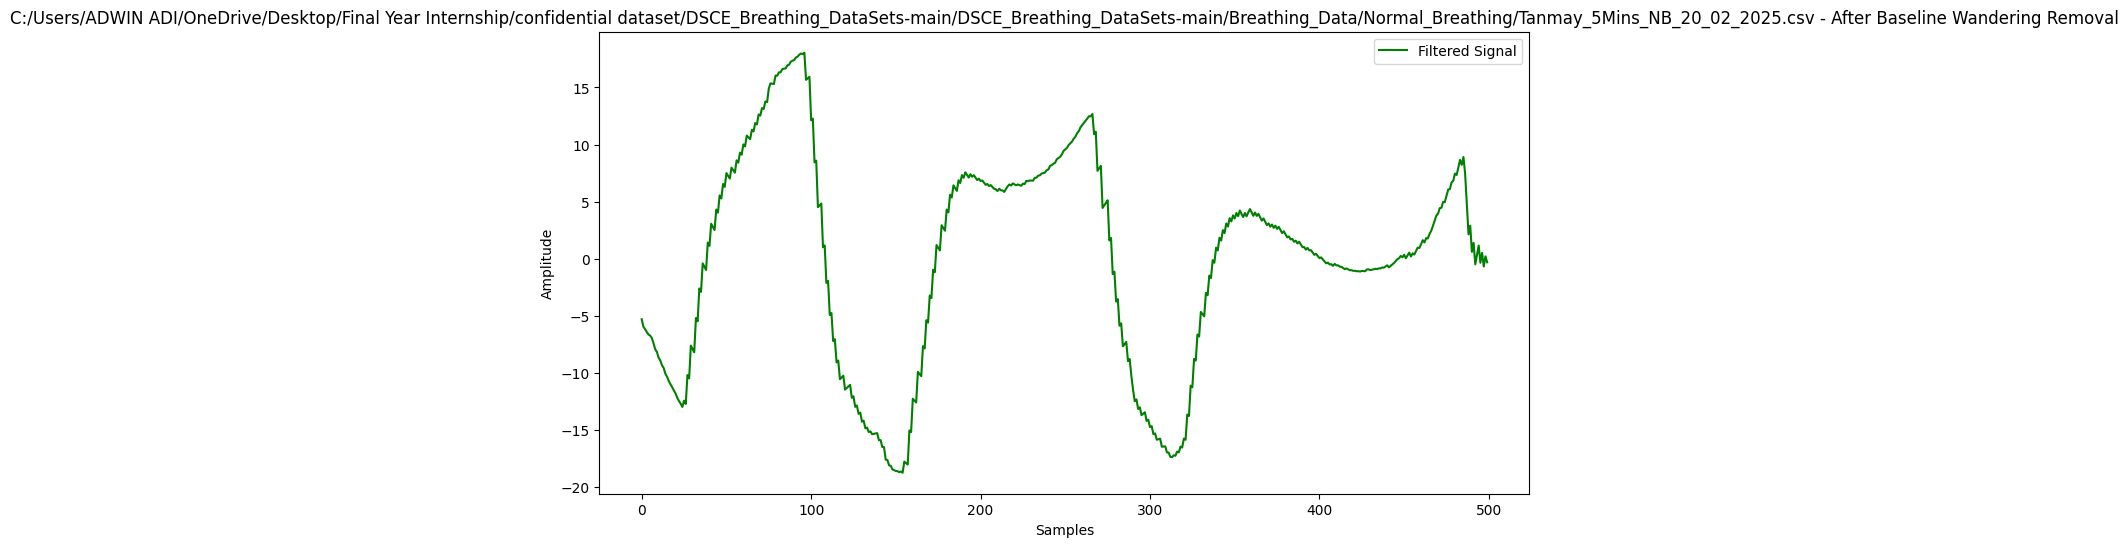

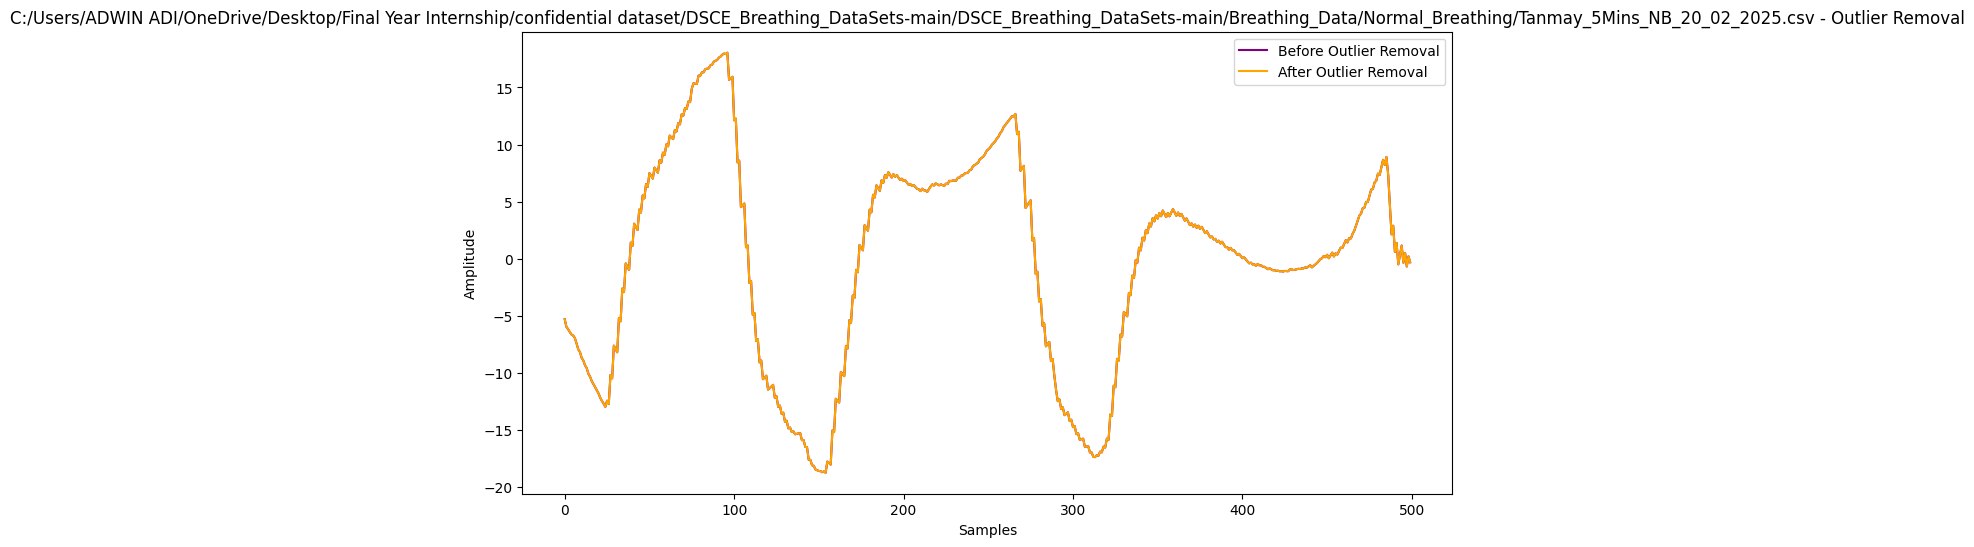

Epoch 1/100
910/910 [==============================] - 6s 5ms/step - loss: 0.0099 - mae: 0.0476 - val_loss: 0.0034 - val_mae: 0.0439
Epoch 2/100
910/910 [==============================] - 5s 6ms/step - loss: 6.7709e-04 - mae: 0.0181 - val_loss: 0.0022 - val_mae: 0.0376
Epoch 3/100
910/910 [==============================] - 5s 5ms/step - loss: 4.9440e-04 - mae: 0.0152 - val_loss: 0.0020 - val_mae: 0.0350
Epoch 4/100
910/910 [==============================] - 4s 5ms/step - loss: 4.1546e-04 - mae: 0.0138 - val_loss: 0.0012 - val_mae: 0.0273
Epoch 5/100
910/910 [==============================] - 5s 5ms/step - loss: 3.8528e-04 - mae: 0.0134 - val_loss: 6.2415e-04 - val_mae: 0.0179
Epoch 6/100
910/910 [==============================] - 5s 6ms/step - loss: 3.3838e-04 - mae: 0.0123 - val_loss: 6.6074e-04 - val_mae: 0.0193
Epoch 7/100
910/910 [==============================] - 5s 5ms/step - loss: 3.2010e-04 - mae: 0.0120 - val_loss: 6.7472e-04 - val_mae: 0.0194
Epoch 8/100
910/910 [============

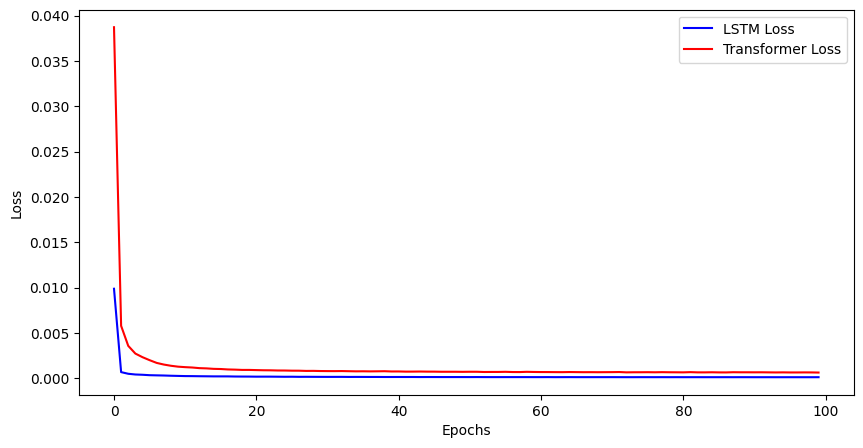

In [4]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files",
                                             filetypes=[("CSV files", "*.csv")])
    return file_paths

# Butterworth High-Pass Filter
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Butterworth Low-Pass Filter
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Remove Outliers using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Load dataset
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\n Dataset Loaded Successfully!\n")
    print(df.head())

    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        for file_path, col in zip(file_paths, numeric_columns):
            signal = df[col].fillna(0)[:500]  # Plot for 500 samples
            
            # Remove baseline wandering
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)
            outlier_removed_signal = remove_outliers(filtered_signal)

            # Plot Original vs. Baseline Wandering
            plt.figure(figsize=(12, 6))
            plt.plot(signal, label="Original Signal", color='b')
            plt.plot(baseline_wandering, label="Baseline Wandering", color='r', linestyle='dashed')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"{file_path} - Original Signal & Baseline Wandering")
            plt.legend()
            plt.show()

            # Plot After Baseline Wandering Removal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Filtered Signal", color='g')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"{file_path} - After Baseline Wandering Removal")
            plt.legend()
            plt.show()

            # Plot Before & After Outlier Removal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Before Outlier Removal", color='purple')
            plt.plot(outlier_removed_signal, label="After Outlier Removal", color='orange')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"{file_path} - Outlier Removal")
            plt.legend()
            plt.show()

        # Data Preprocessing for Models
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns))
        ])
        lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        # Build Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return self.fc(x[:, -1, :])

        X_train_torch = torch.tensor(X_train, dtype=torch.float32)
        y_train_torch = torch.tensor(y_train, dtype=torch.float32)
        train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        transformer_losses = []
        for epoch in range(100):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                output = transformer_model(batch_X)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            transformer_losses.append(total_loss / len(train_loader))

        # Generate Table for Model Performance
        epochs_list = [10, 30, 50, 75, 100]
        results = []

        for epoch in epochs_list:
            lstm_loss = history_lstm.history['loss'][epoch-1]
            transformer_loss = transformer_losses[epoch-1]

            results.append([epoch, lstm_loss, transformer_loss])

        results_df = pd.DataFrame(results, columns=['Epochs', 'LSTM Loss', 'Transformer Loss'])
        print(results_df)

        # Plot Loss Curves
        plt.figure(figsize=(10, 5))
        plt.plot(history_lstm.history['loss'], label='LSTM Loss', color='blue')
        plt.plot(transformer_losses, label='Transformer Loss', color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

else:
    print("No file selected. Please upload a valid dataset.")



Datasets Loaded Successfully!

                        File Name  Rows  Columns
0  Ashvin_5Mins_NB_20_02_2025.csv  5884        6
1     Harsha_5min_NB_20_02_25.csv  9791        6


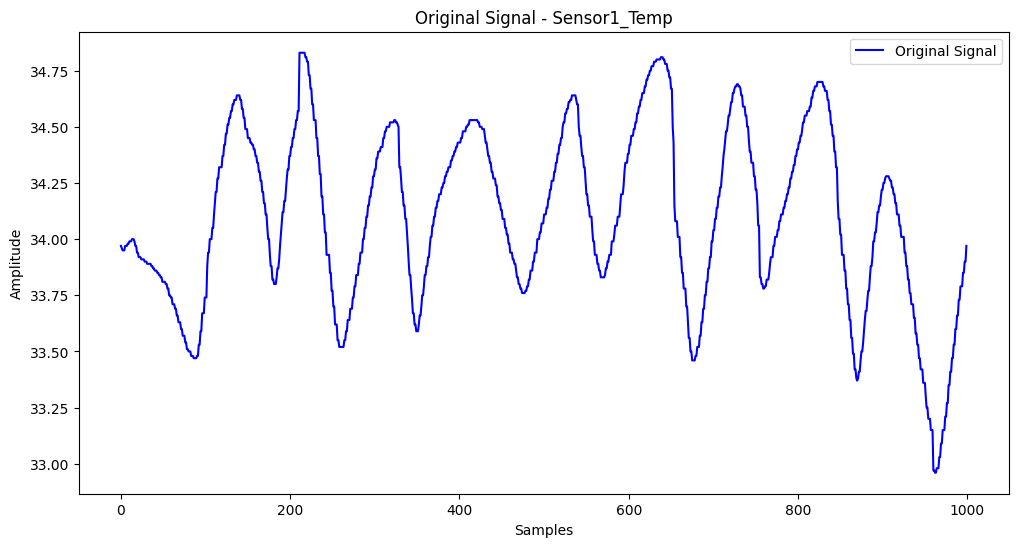

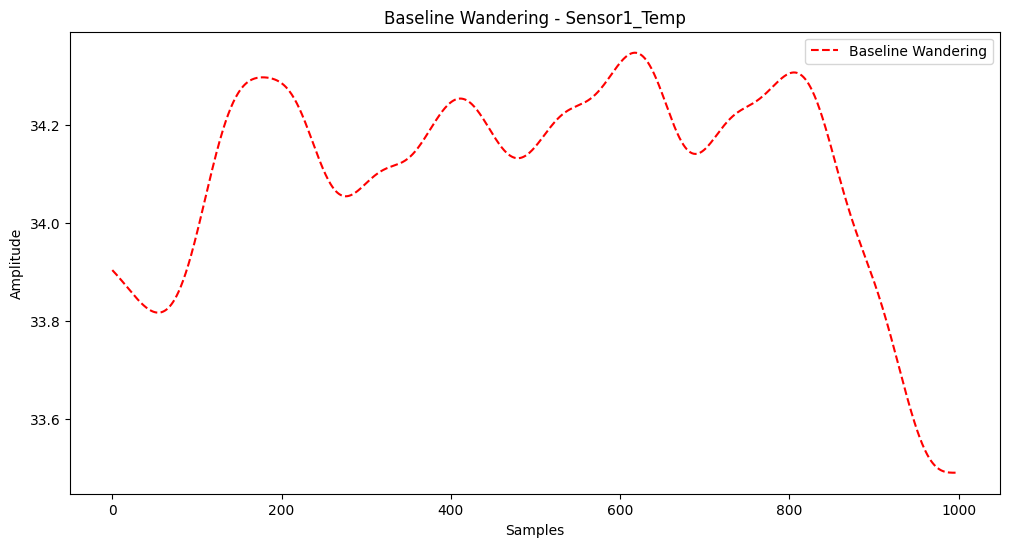

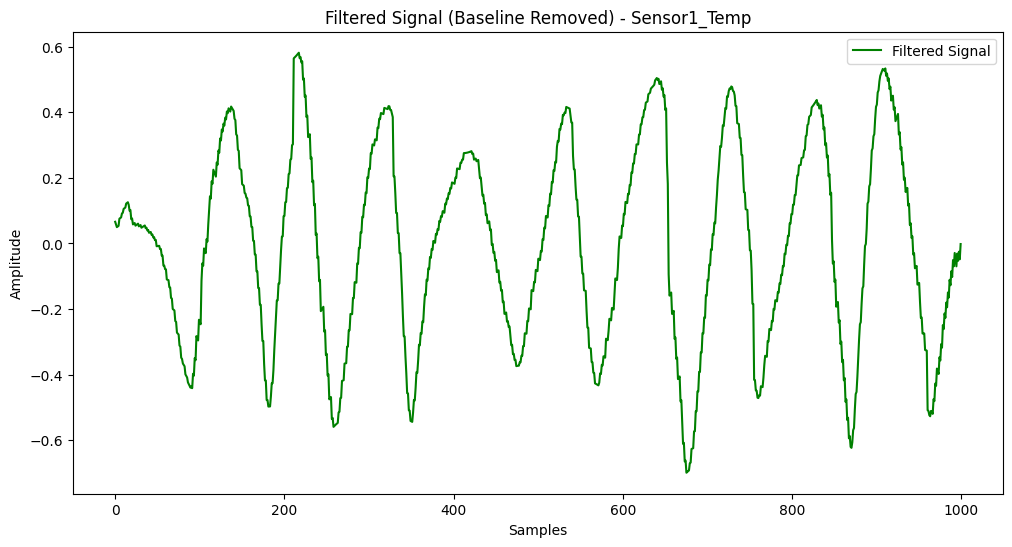

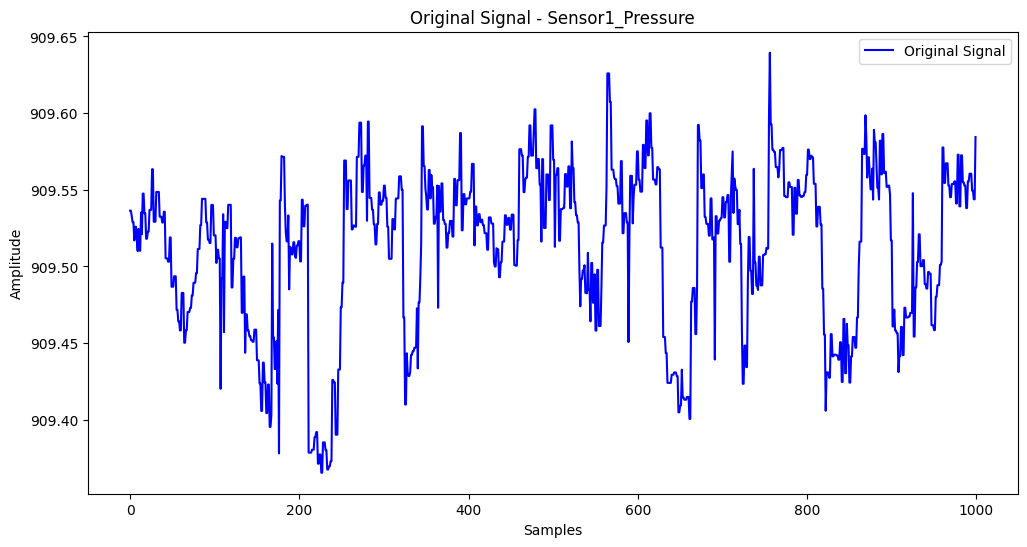

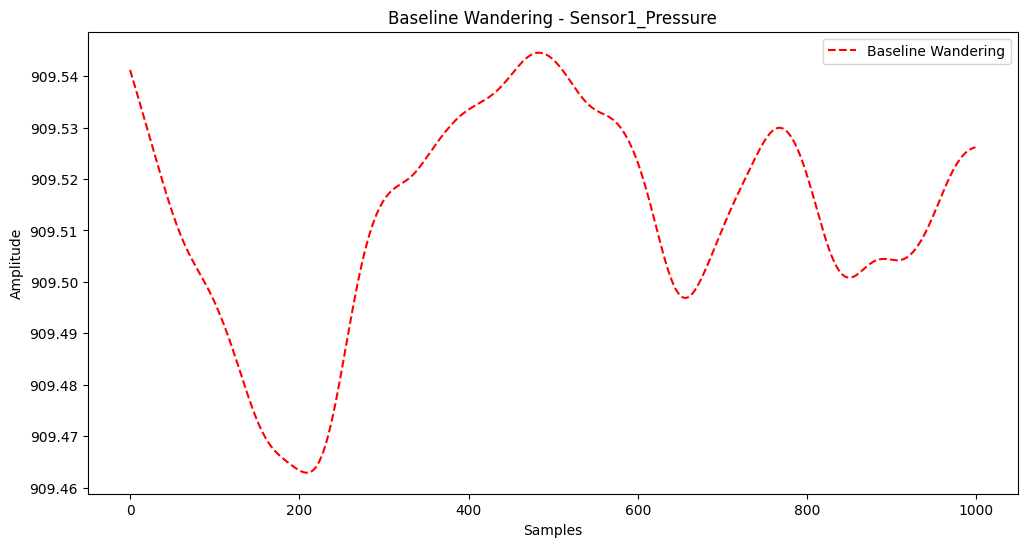

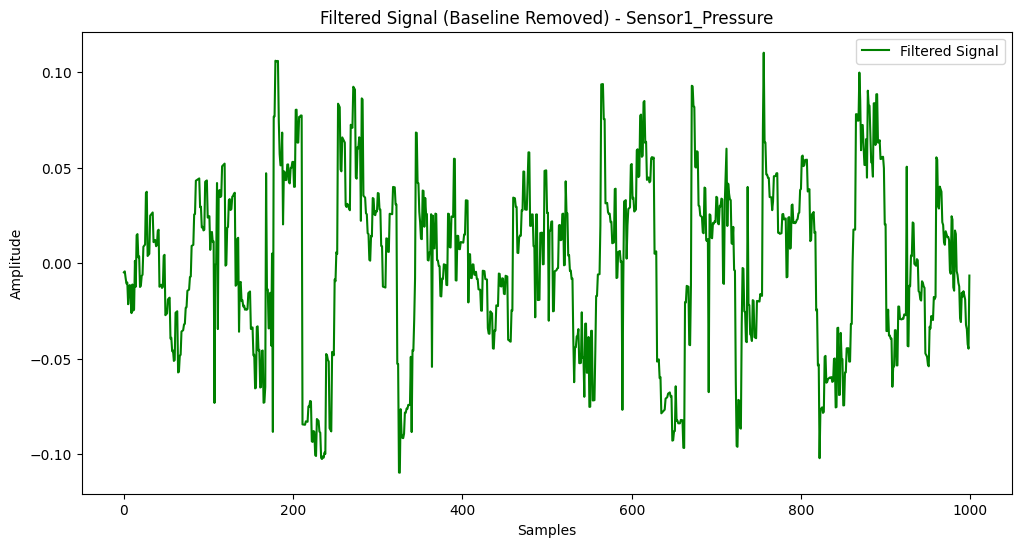

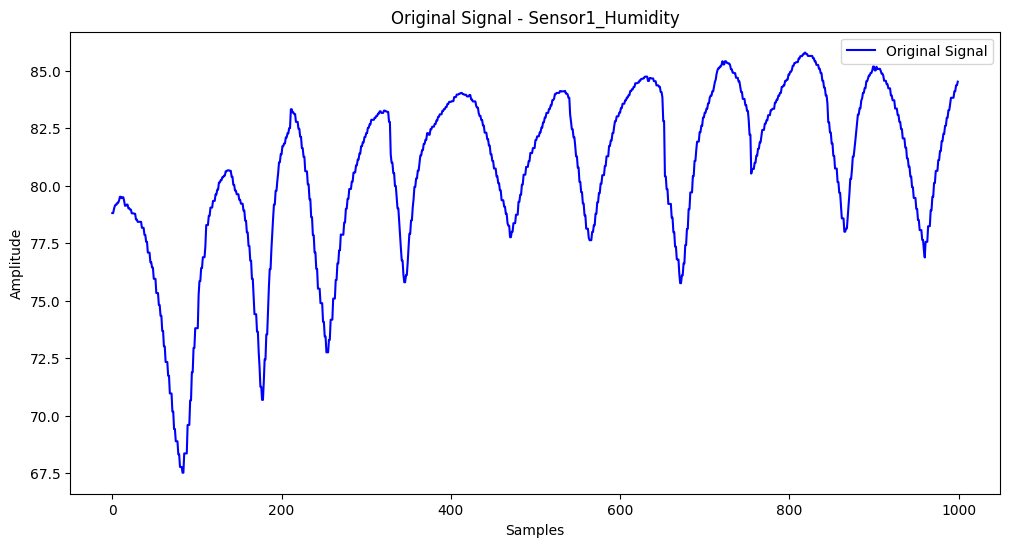

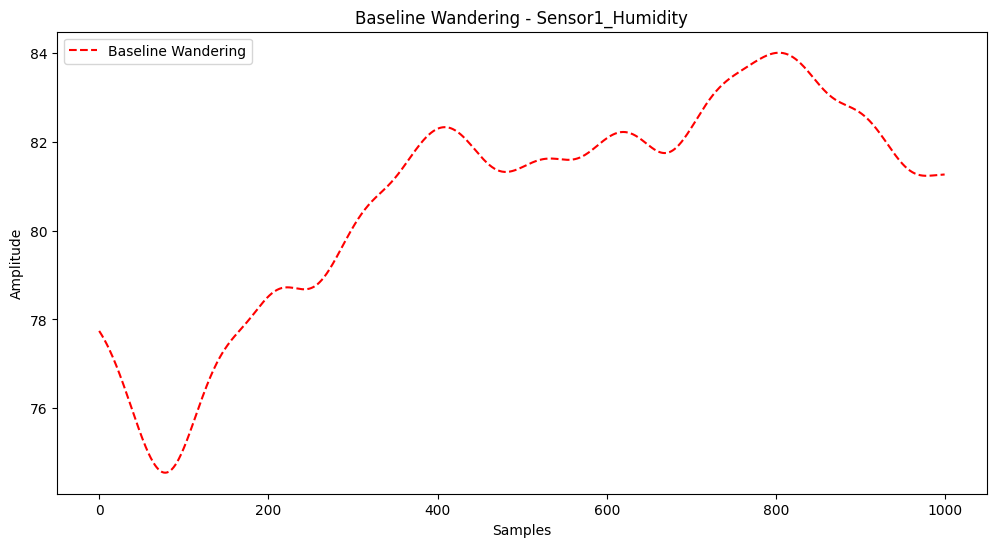

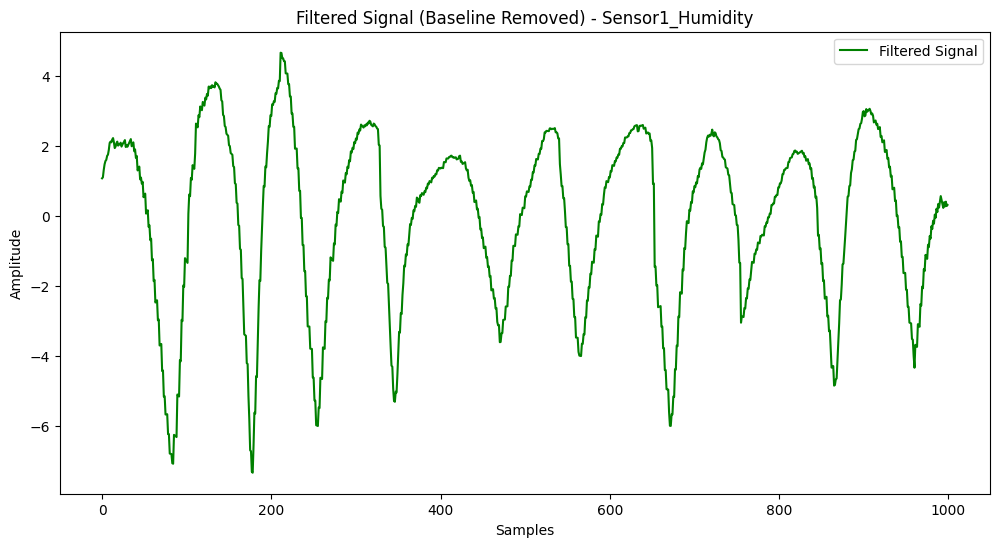

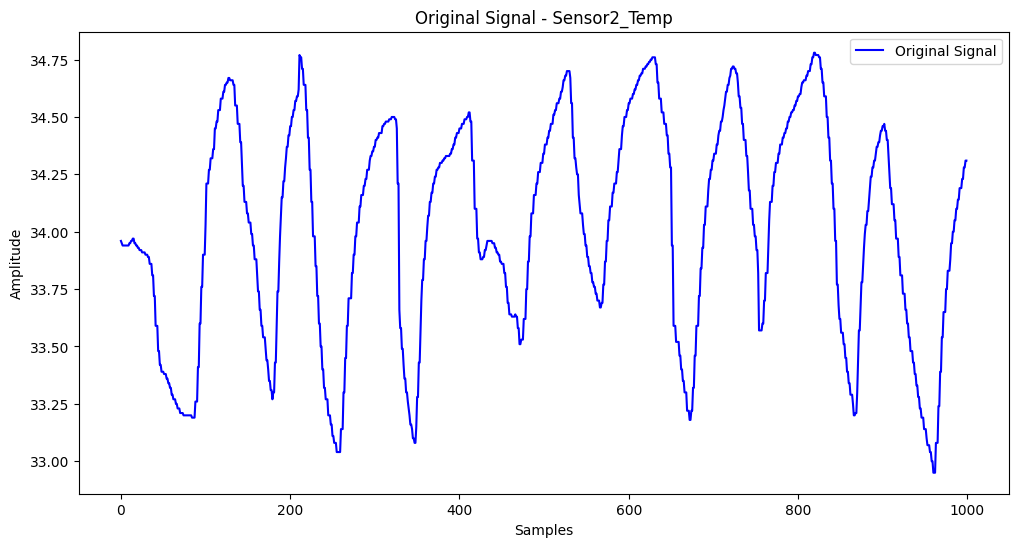

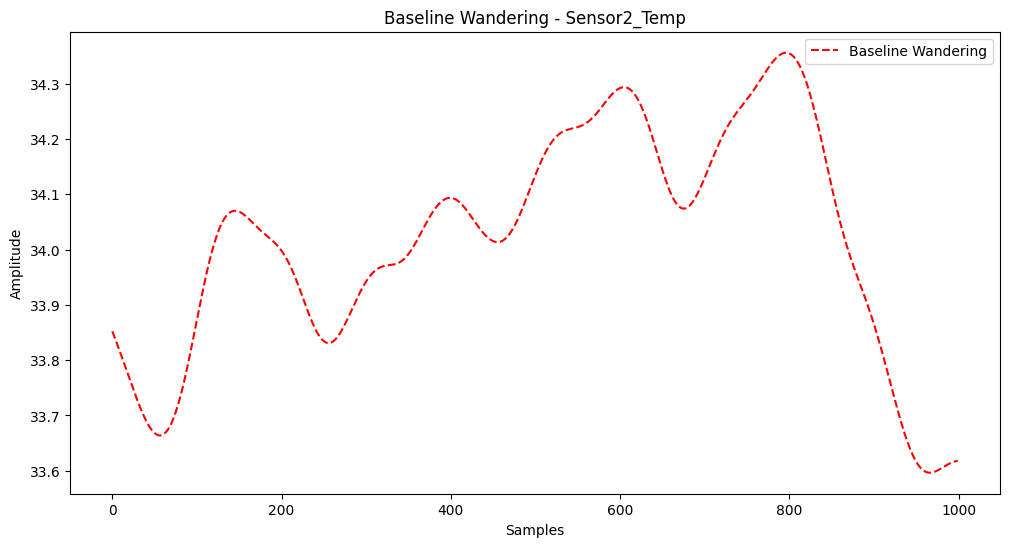

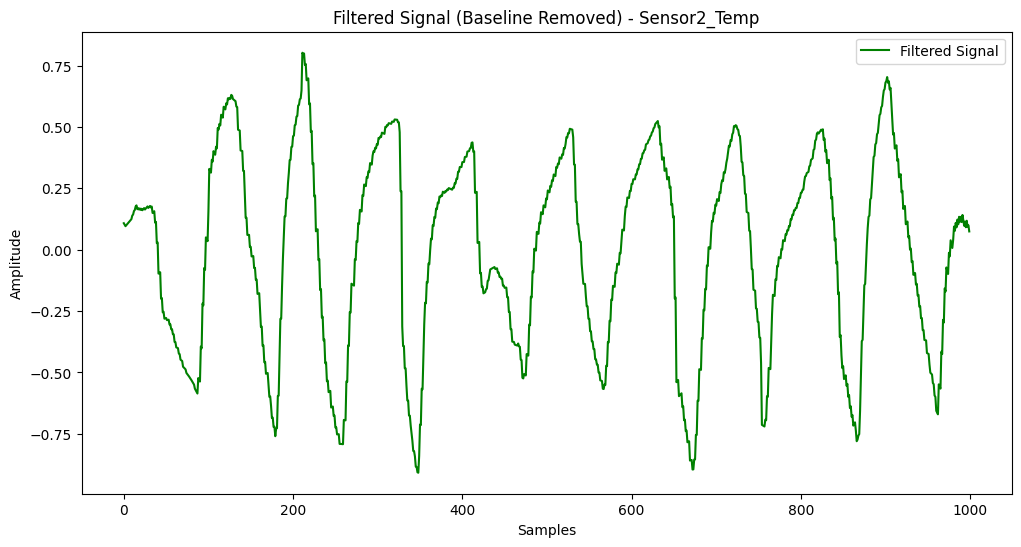

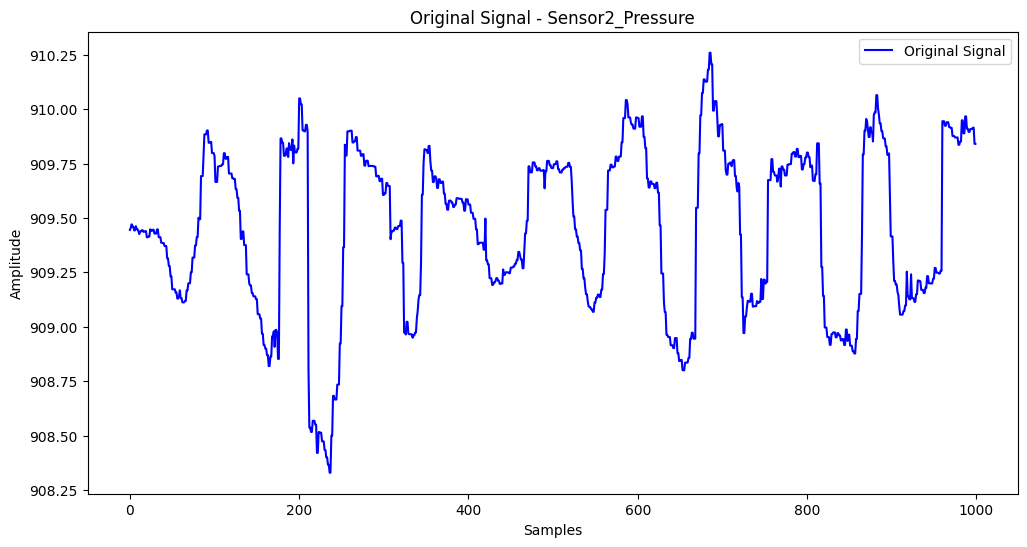

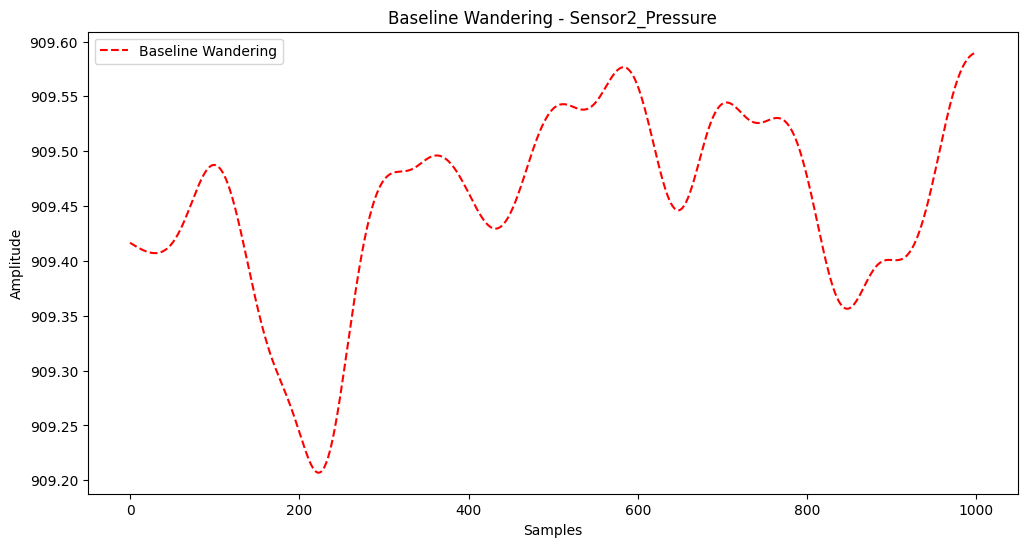

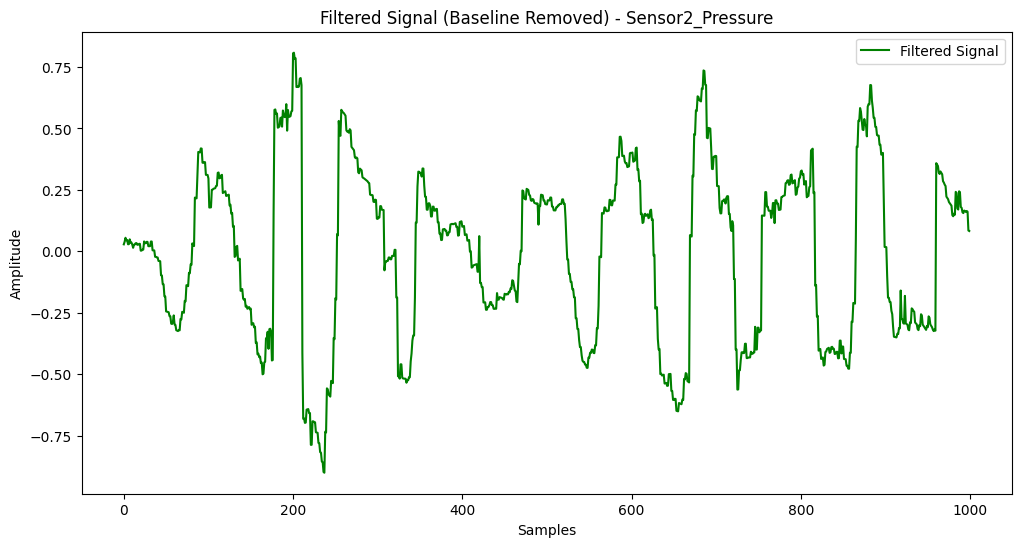

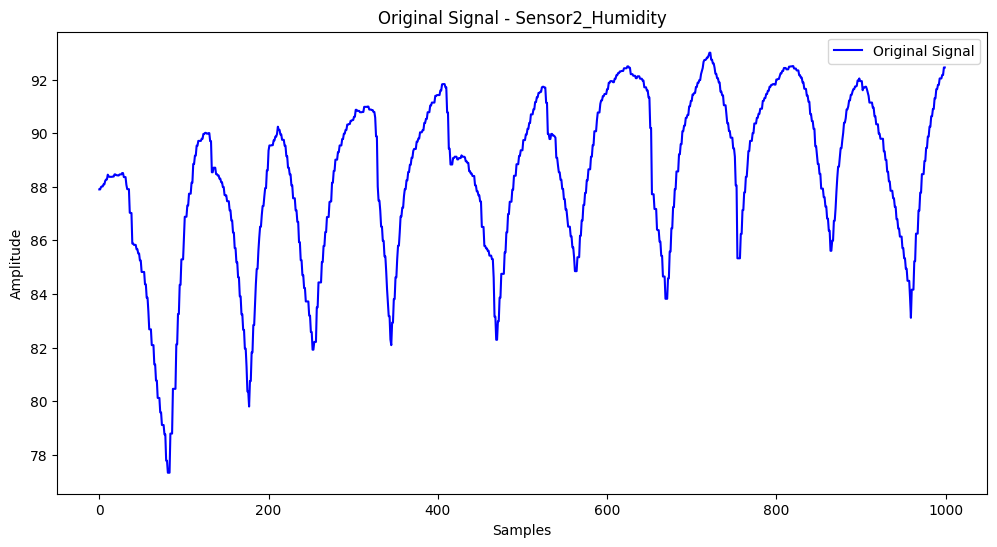

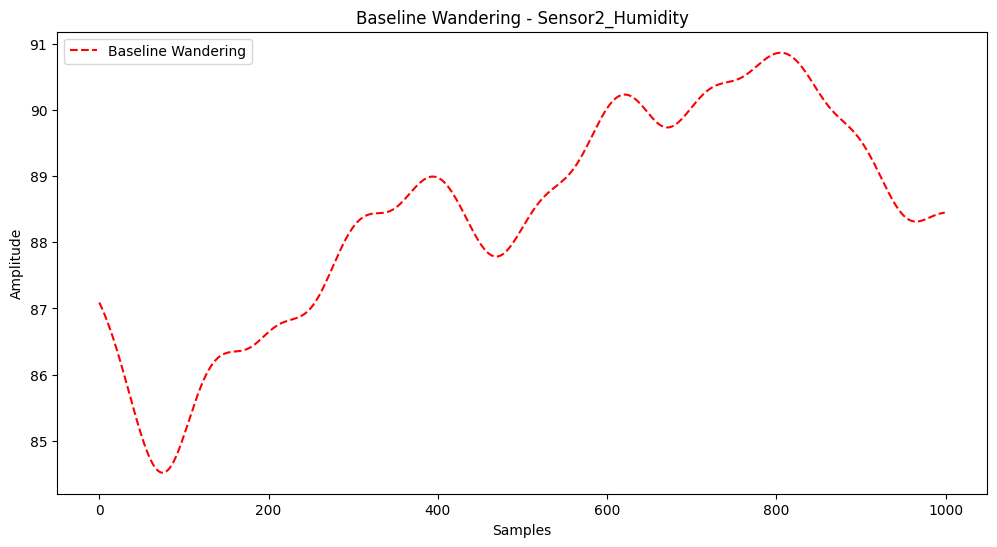

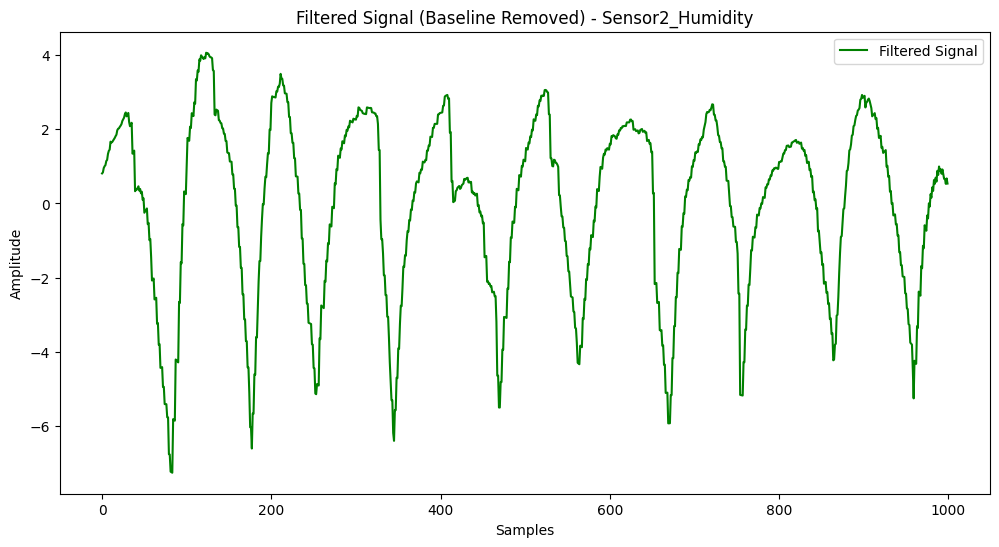

Epoch 1/100
784/784 [==============================] - 11s 11ms/step - loss: 0.0166 - val_loss: 1.0744e-07
Epoch 2/100
784/784 [==============================] - 7s 9ms/step - loss: 3.6551e-04 - val_loss: 6.5022e-08
Epoch 3/100
784/784 [==============================] - 6s 8ms/step - loss: 2.5854e-04 - val_loss: 3.8208e-08
Epoch 4/100
784/784 [==============================] - 6s 8ms/step - loss: 2.5742e-04 - val_loss: 3.6195e-07
Epoch 5/100
784/784 [==============================] - 7s 9ms/step - loss: 2.4343e-04 - val_loss: 3.1782e-08
Epoch 6/100
784/784 [==============================] - 8s 10ms/step - loss: 1.9690e-04 - val_loss: 3.3162e-08
Epoch 7/100
784/784 [==============================] - 6s 8ms/step - loss: 1.9679e-04 - val_loss: 1.4335e-06
Epoch 8/100
784/784 [==============================] - 6s 7ms/step - loss: 2.1353e-04 - val_loss: 2.9883e-08
Epoch 9/100
784/784 [==============================] - 8s 10ms/step - loss: 2.0472e-04 - val_loss: 8.1641e-08
Epoch 10/100
784/78

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [5]:

#modifed code 2 on 25-03-2025 time 11:04

import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files",filetypes=[("CSV files", "*.csv")])
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Low-pass filter for baseline wandering extraction
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    filtered_signal = np.where(np.abs(z_scores) > threshold, np.median(signal), signal)
    return filtered_signal

# Function to compute metrics
def calculate_metrics(y_true, y_pred):
    y_pred = np.round(y_pred)
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    specificity = recall_score(y_true.flatten(), y_pred.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
    loss = np.mean((y_true - y_pred) ** 2)
    return accuracy, specificity, f1, loss

# Load datasets
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\nDatasets Loaded Successfully!\n")
    dataset_info = pd.DataFrame({
        "File Name": [file.split("/")[-1] for file in file_paths],
        "Rows": [len(pd.read_csv(file)) for file in file_paths],
        "Columns": [len(pd.read_csv(file).columns) for file in file_paths]
    })
    print(dataset_info)

    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        for col in numeric_columns:
            signal = df[col].fillna(0)[:1000]  # First 1000 samples
            
            # Plot original signal
            plt.figure(figsize=(12, 6))
            plt.plot(signal, label="Original Signal", color='b')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Original Signal - {col}")
            plt.legend()
            plt.show()

            # Detect and remove baseline wandering
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)
            
            # Plot baseline wandering
            plt.figure(figsize=(12, 6))
            plt.plot(baseline_wandering, label="Baseline Wandering", color='r', linestyle='dashed')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Baseline Wandering - {col}")
            plt.legend()
            plt.show()

            # Plot filtered signal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Filtered Signal", color='g')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Filtered Signal (Baseline Removed) - {col}")
            plt.legend()
            plt.show()

        # Prepare dataset for training
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns))
        ])
        lstm_model.compile(optimizer='adam', loss='mse')
        history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        # Predictions
        y_pred_lstm = lstm_model.predict(X_test)
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

        # Build Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return self.fc(x[:, -1, :])

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        transformer_losses = []
        for epoch in range(100):
            total_loss = 0
            optimizer.zero_grad()
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
            output = transformer_model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            transformer_losses.append(total_loss)

        # Predictions
        y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
        trans_acc, trans_spec, trans_f1, trans_loss = calculate_metrics(y_test, y_pred_transformer)

        # Model Performance Table
        model_performance = pd.DataFrame({
            "Model": ["LSTM", "Transformer"],
            "Loss": [lstm_loss, trans_loss],
            "Accuracy": [lstm_acc, trans_acc],
            "F1 Score": [lstm_f1, trans_f1],
            "Specificity": [lstm_spec, trans_spec]
        })
        print("\nModel Performance Metrics Table:\n", model_performance)

        # Plot Performance Metrics
        plt.figure(figsize=(12, 6))
        plt.plot(history_lstm.history['loss'], label='LSTM Loss', color='blue')
        plt.plot(transformer_losses, label='Transformer Loss', color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Model Training Loss")
        plt.show()

else:
    print("No file selected. Please upload a valid dataset.")




Datasets Loaded Successfully!

                        File Name  Rows  Columns
0  Ashvin_5Mins_NB_20_02_2025.csv  5884        6


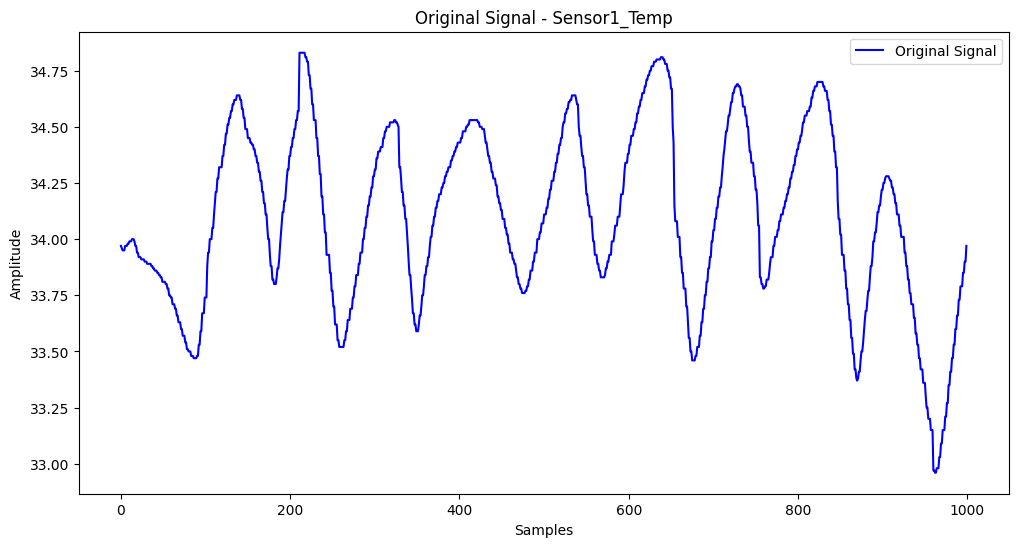

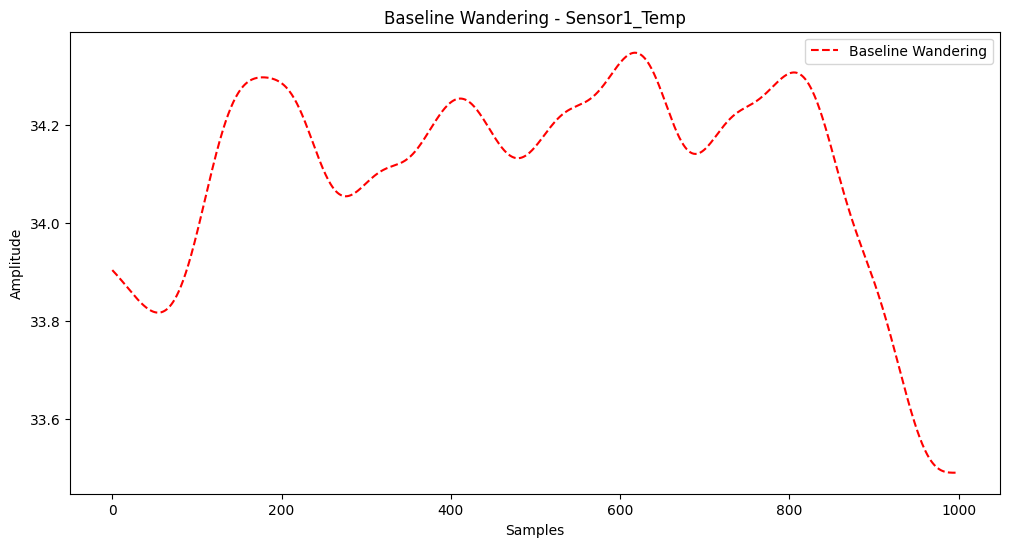

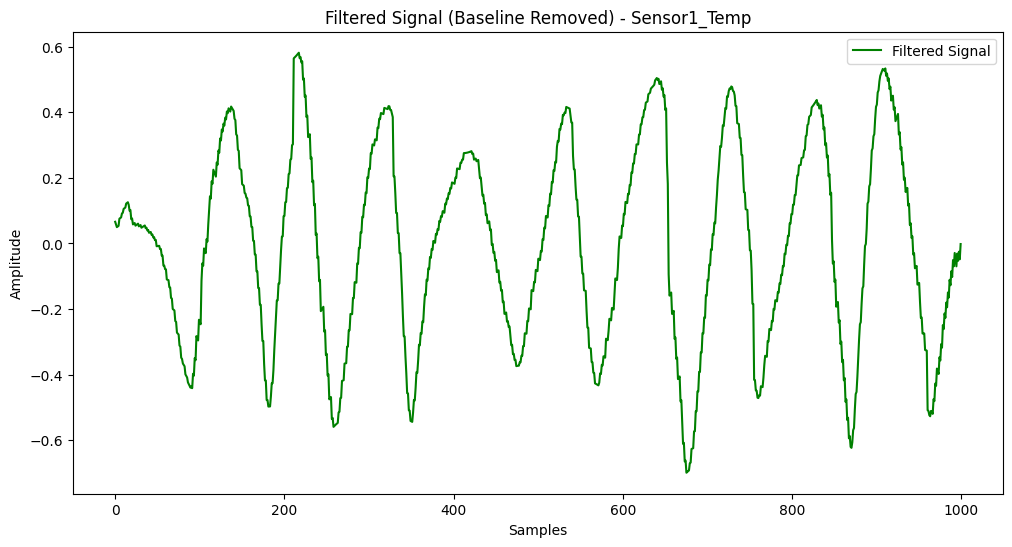

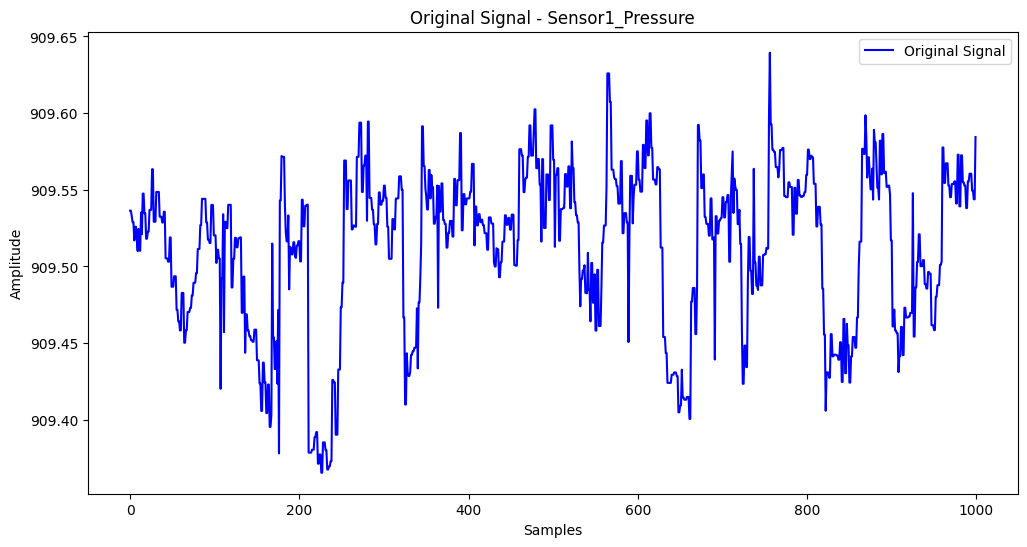

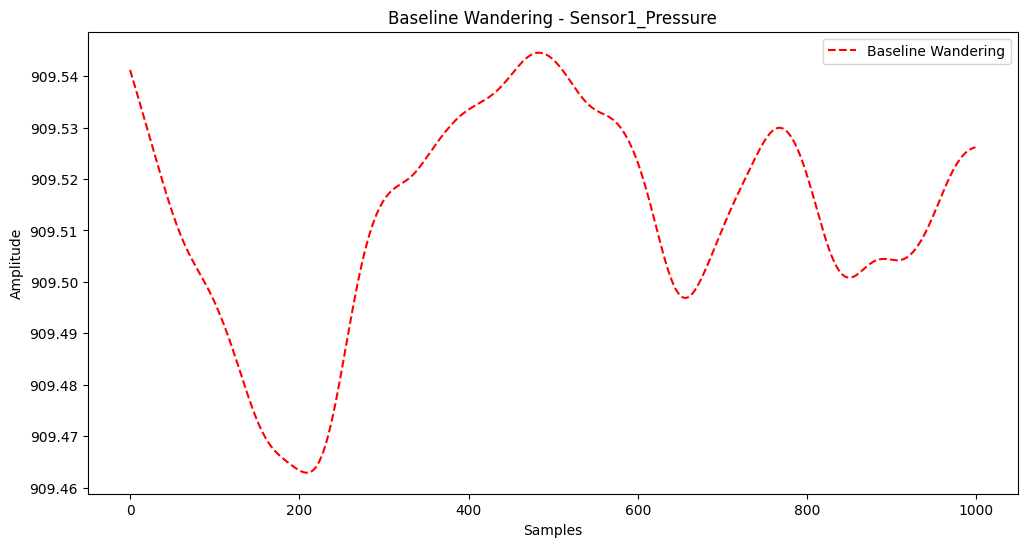

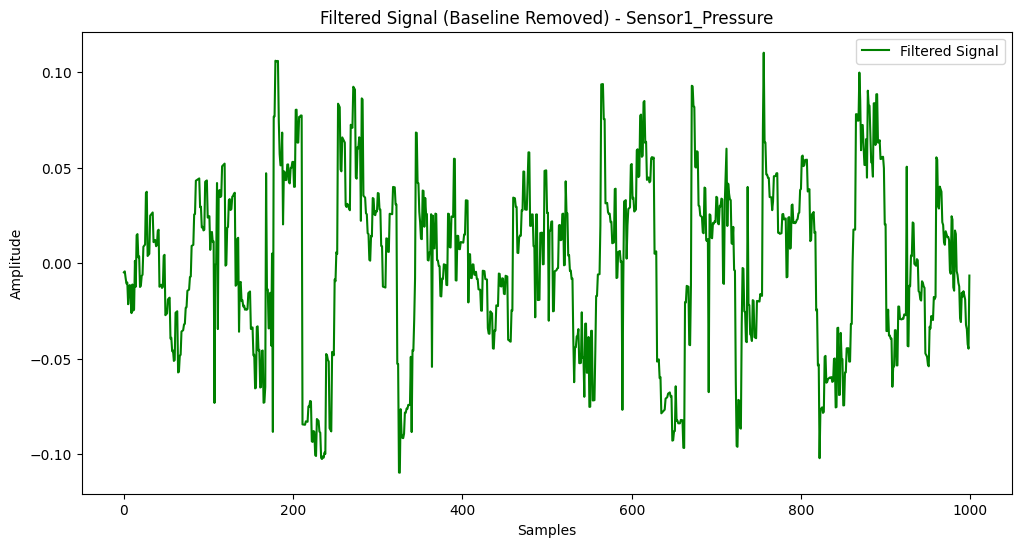

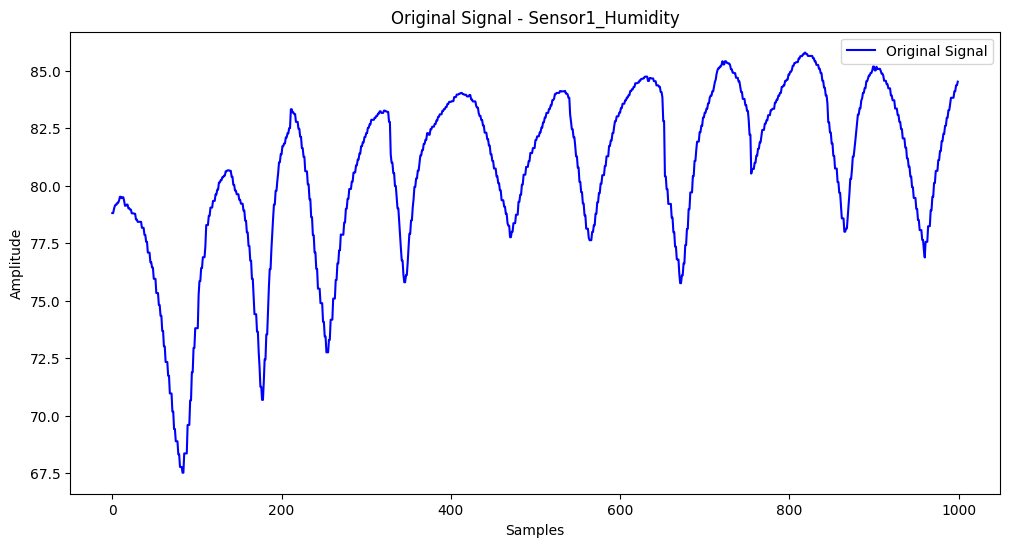

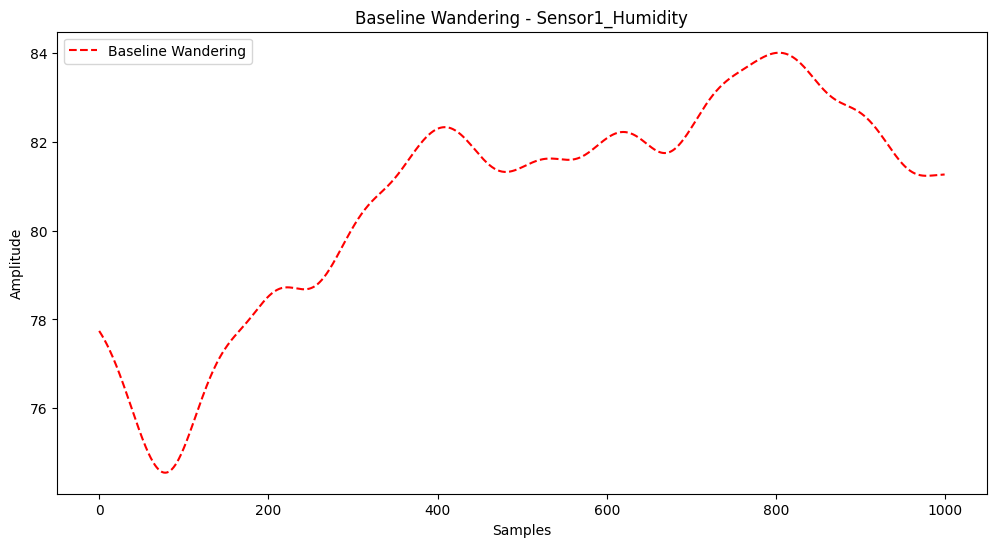

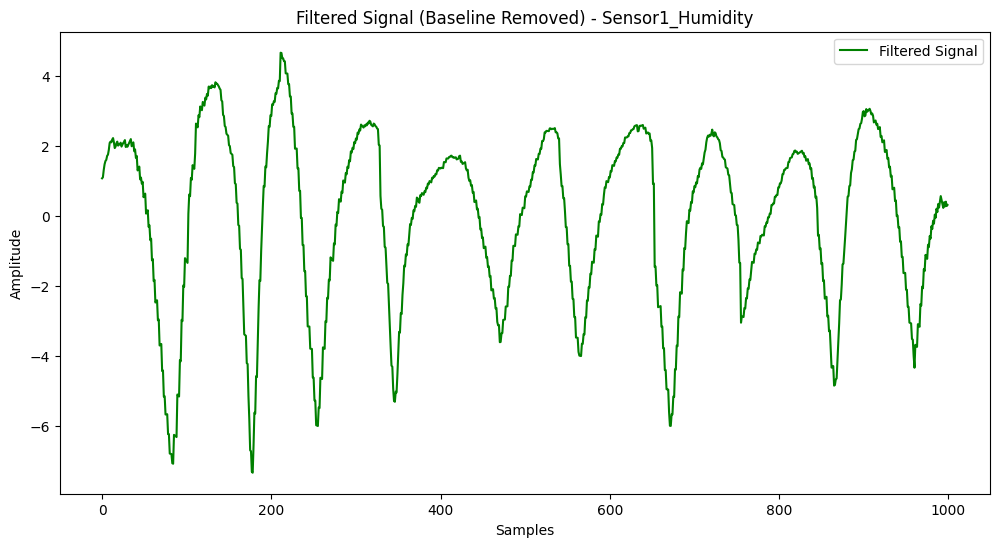

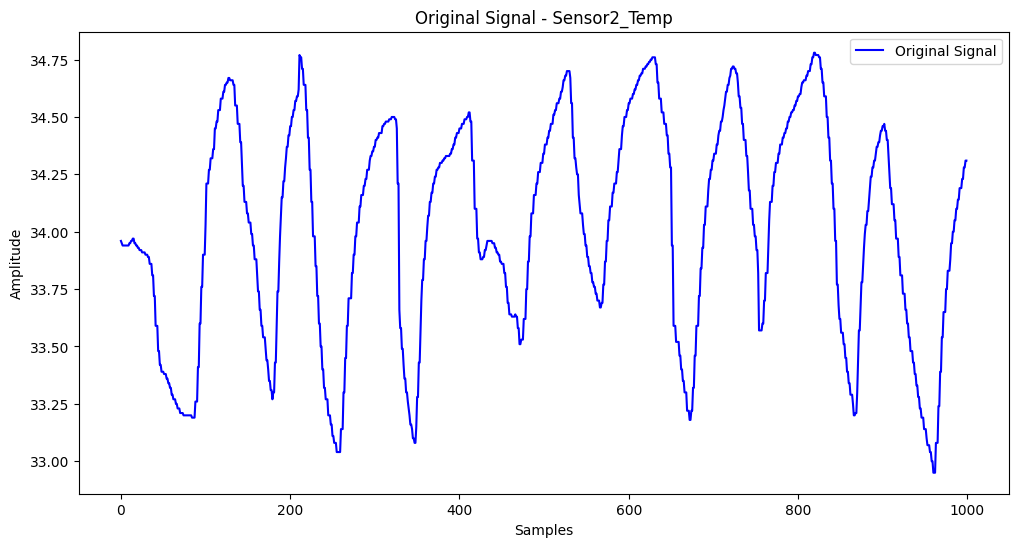

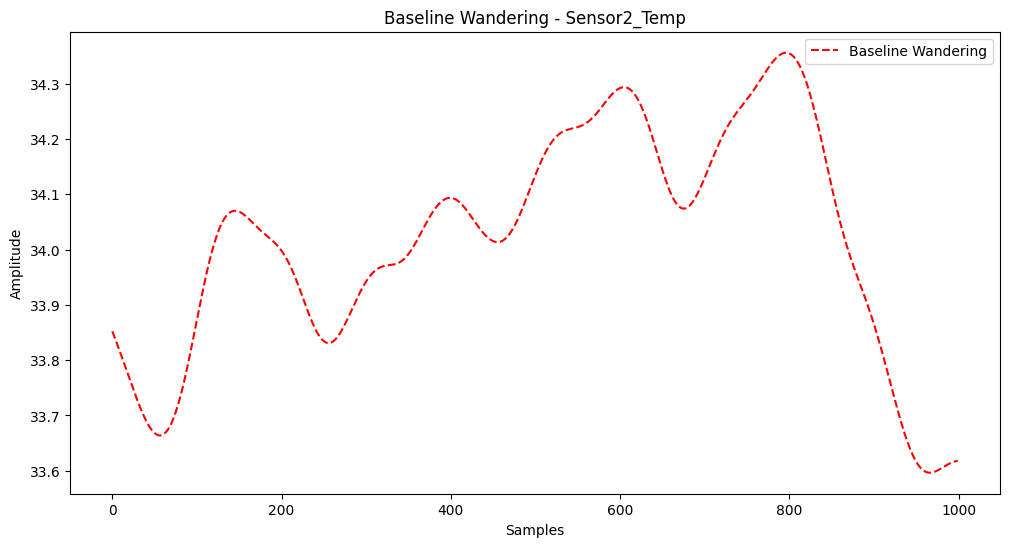

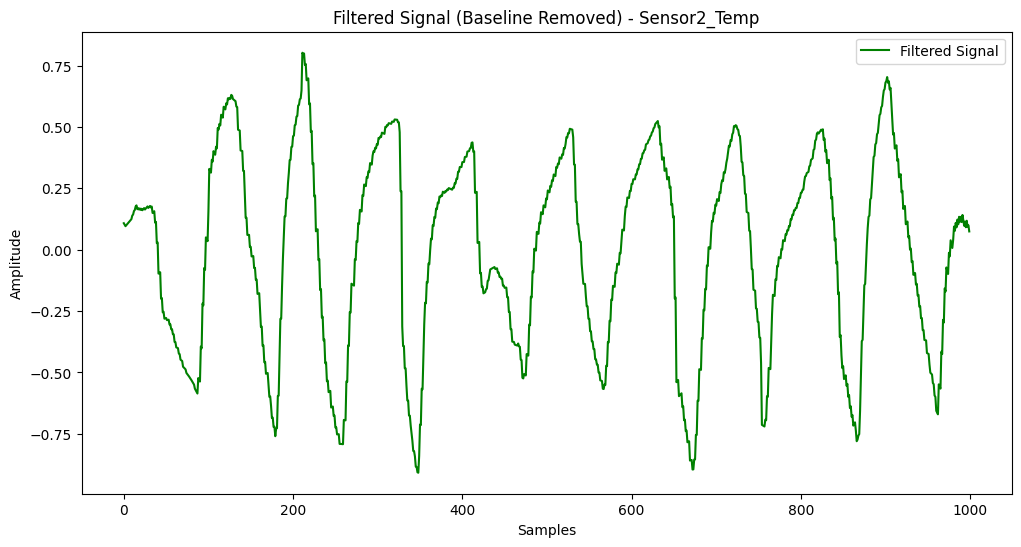

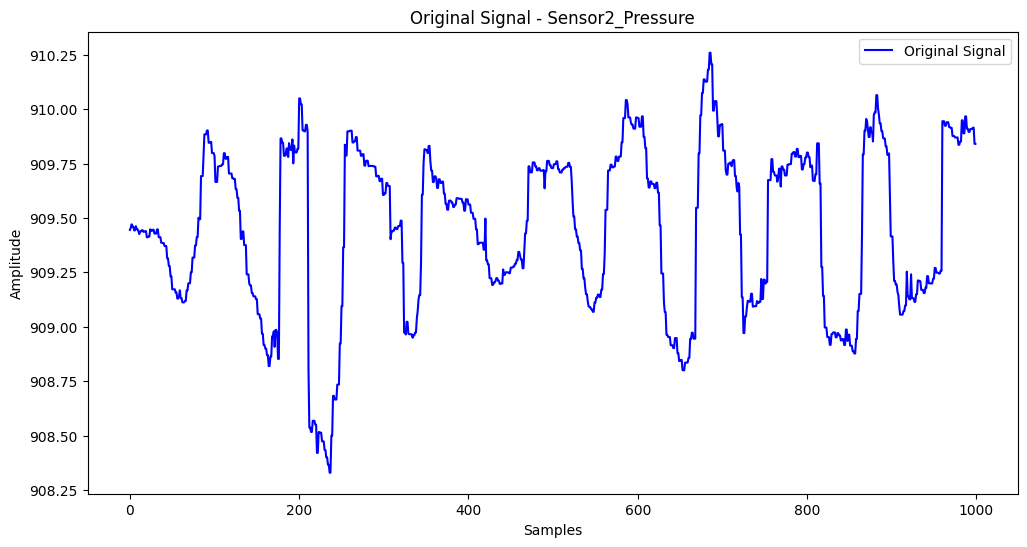

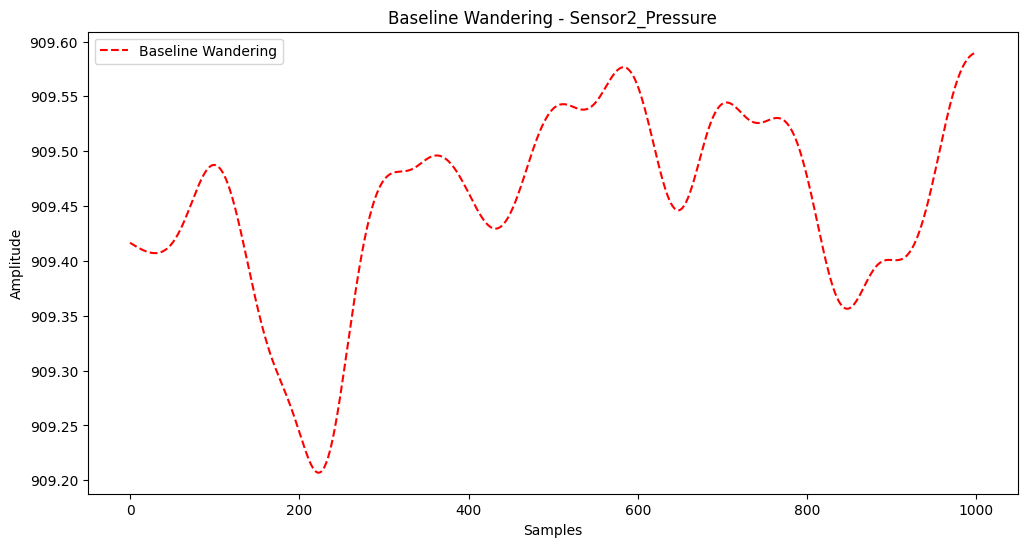

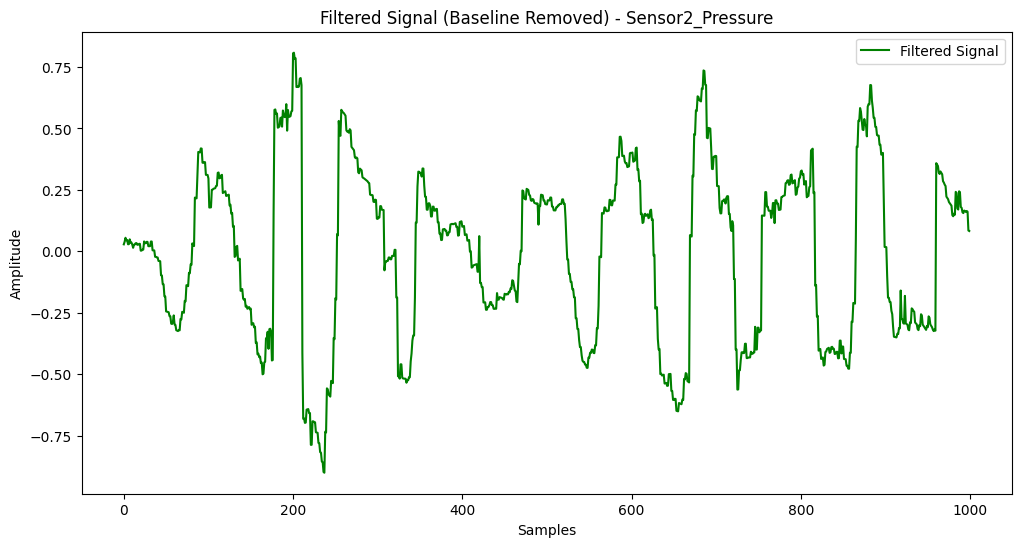

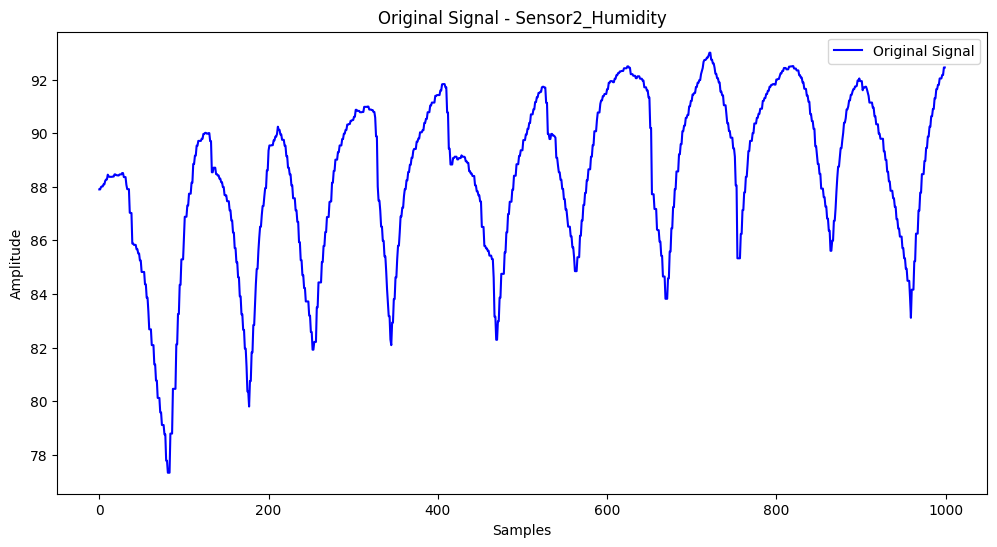

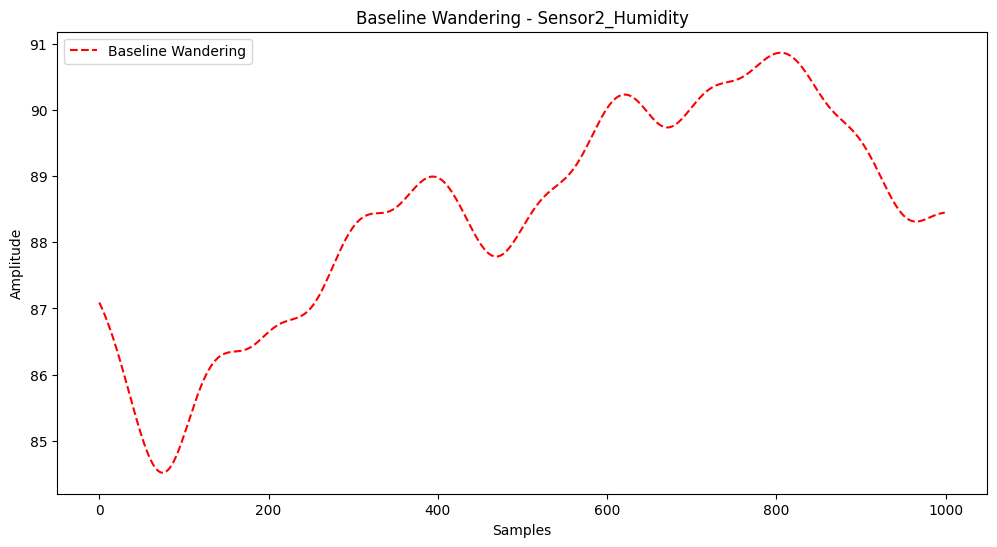

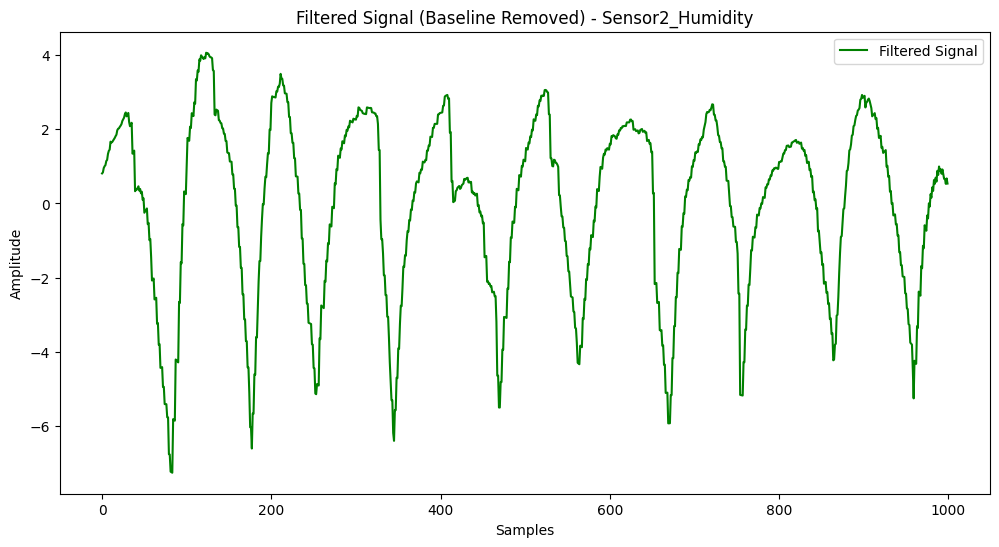

Epoch 1/100
294/294 [==============================] - 4s 7ms/step - loss: 0.0275 - val_loss: 0.0043
Epoch 2/100
294/294 [==============================] - 2s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 3/100
294/294 [==============================] - 2s 6ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 4/100
294/294 [==============================] - 2s 6ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/100
294/294 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/100
294/294 [==============================] - 2s 6ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/100
294/294 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
294/294 [==============================] - 3s 10ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/100
294/294 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/100
294/294 [==============================] - 3s 11ms/step - loss: 0.0013 - val

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [1]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Low-pass filter for baseline wandering extraction
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Function to compute metrics
def calculate_metrics(y_true, y_pred):
    y_pred = np.round(y_pred)
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    specificity = recall_score(y_true.flatten(), y_pred.flatten(), average='macro', zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='macro', zero_division=1)
    loss = np.mean((y_true - y_pred) ** 2)
    return accuracy, specificity, f1, loss

# Load datasets
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\nDatasets Loaded Successfully!\n")
    dataset_info = pd.DataFrame({
        "File Name": [file.split("/")[-1] for file in file_paths],
        "Rows": [len(pd.read_csv(file)) for file in file_paths],
        "Columns": [len(pd.read_csv(file).columns) for file in file_paths]
    })
    print(dataset_info)

    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        for col in numeric_columns:
            signal = df[col].fillna(0)[:1000]  # First 1000 samples
            
            # Plot original signal
            plt.figure(figsize=(12, 6))
            plt.plot(signal, label="Original Signal", color='b')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Original Signal - {col}")
            plt.legend()
            plt.show()

            # Detect and remove baseline wandering
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)
            
            # Plot baseline wandering
            plt.figure(figsize=(12, 6))
            plt.plot(baseline_wandering, label="Baseline Wandering", color='r', linestyle='dashed')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Baseline Wandering - {col}")
            plt.legend()
            plt.show()

            # Plot filtered signal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Filtered Signal", color='g')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Filtered Signal (Baseline Removed) - {col}")
            plt.legend()
            plt.show()

        # Prepare dataset for training
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns))
        ])
        lstm_model.compile(optimizer='adam', loss='mse')
        history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        # Predictions
        y_pred_lstm = lstm_model.predict(X_test)
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

        # Build Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return self.fc(x[:, -1, :])

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        transformer_losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
            output = transformer_model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()
            transformer_losses.append(loss.item())

        # Predictions
        y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
        trans_acc, trans_spec, trans_f1, trans_loss = calculate_metrics(y_test, y_pred_transformer)

        # Model Performance Table
        model_performance = pd.DataFrame({
            "Model": ["LSTM", "Transformer"],
            "Loss": [lstm_loss, trans_loss],
            "Accuracy": [lstm_acc, trans_acc],
            "F1 Score": [lstm_f1, trans_f1],
            "Specificity": [lstm_spec, trans_spec]
        })
        print("\nModel Performance Metrics Table:\n", model_performance)

        # Plot Performance Metrics
        plt.figure(figsize=(12, 6))
        plt.plot(history_lstm.history['loss'], label='LSTM Loss', color='blue')
        plt.plot(transformer_losses, label='Transformer Loss', color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Model Training Loss")
        plt.show()

else:
    print("No file selected. Please upload a valid dataset.")



Datasets Loaded Successfully!

                        File Name  Rows  Columns
0  Ashvin_5Mins_NB_20_02_2025.csv  5884        6


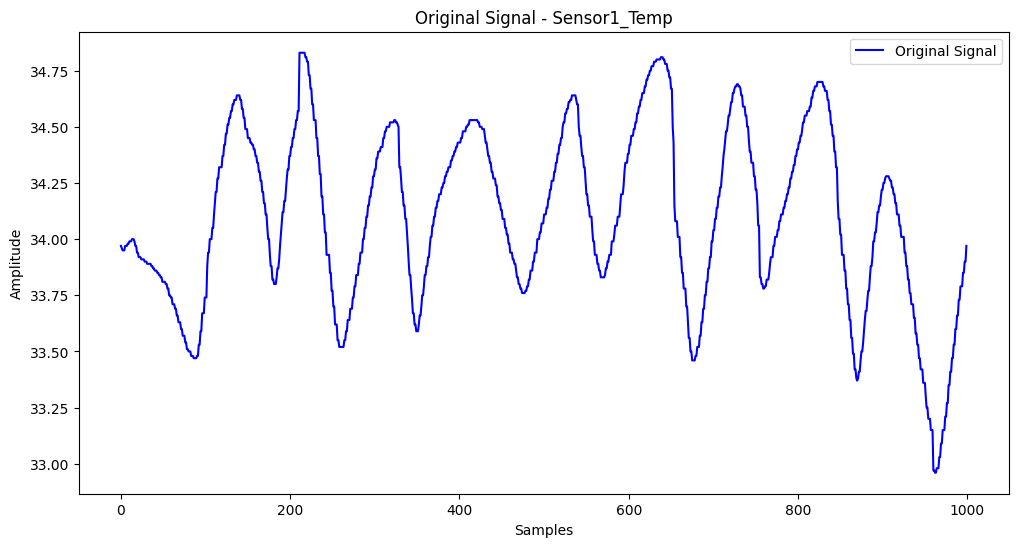

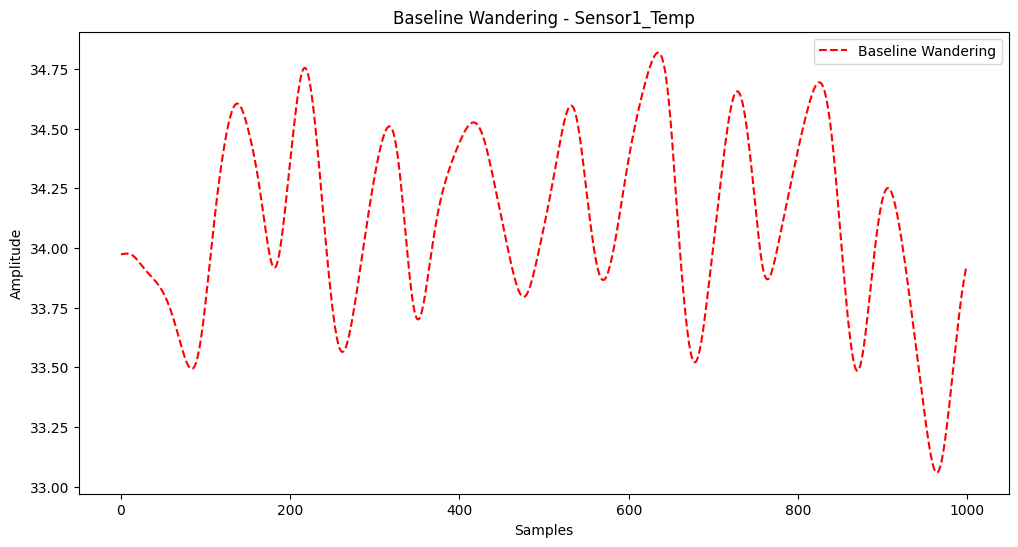

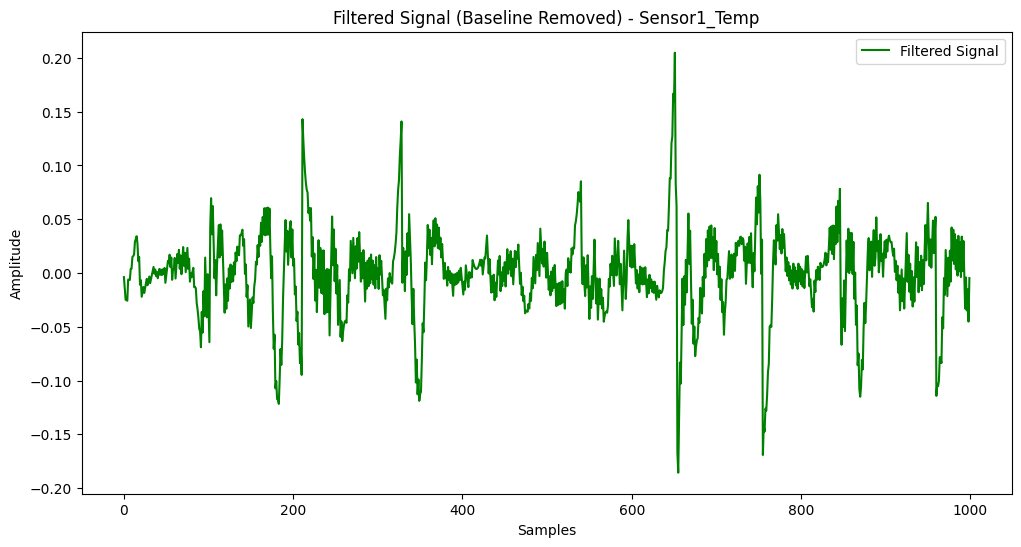

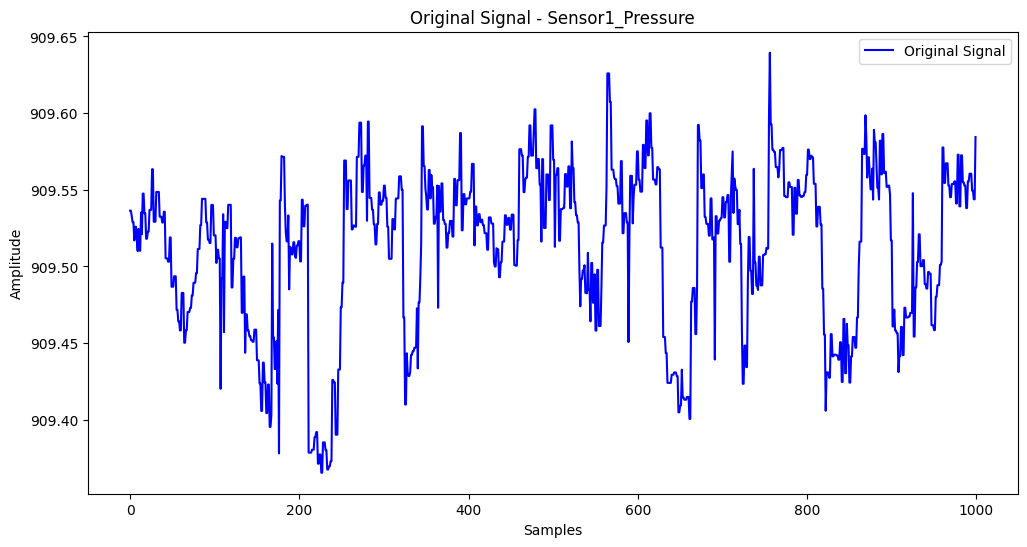

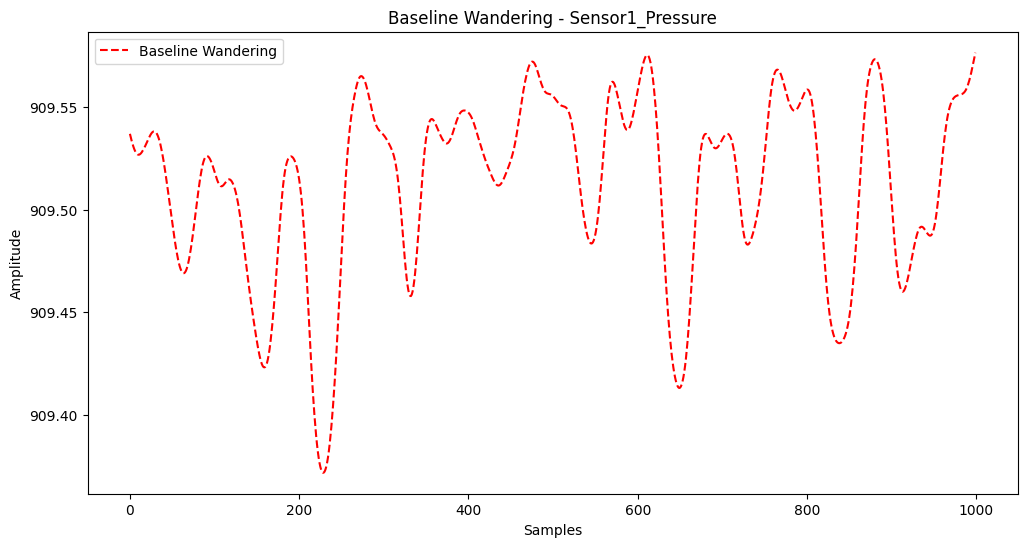

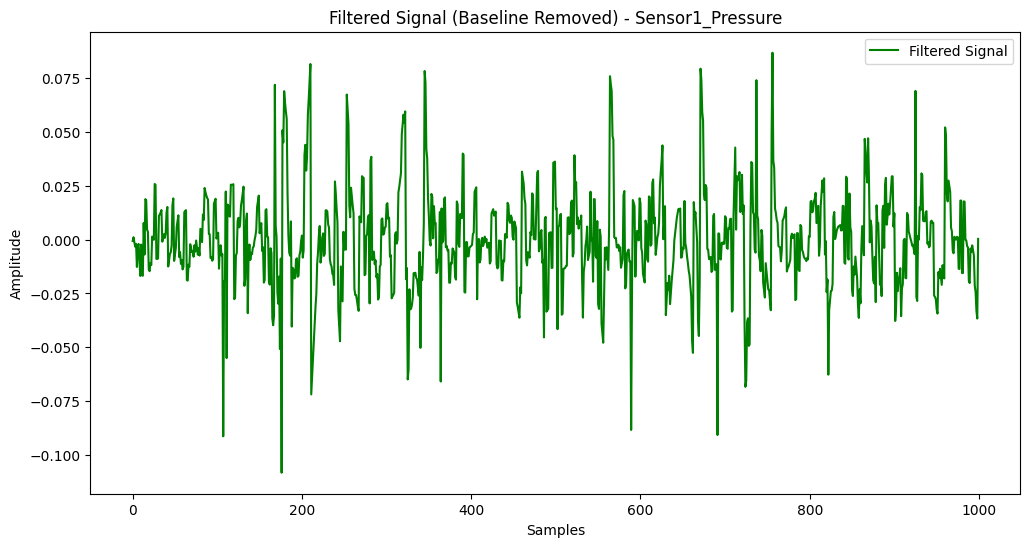

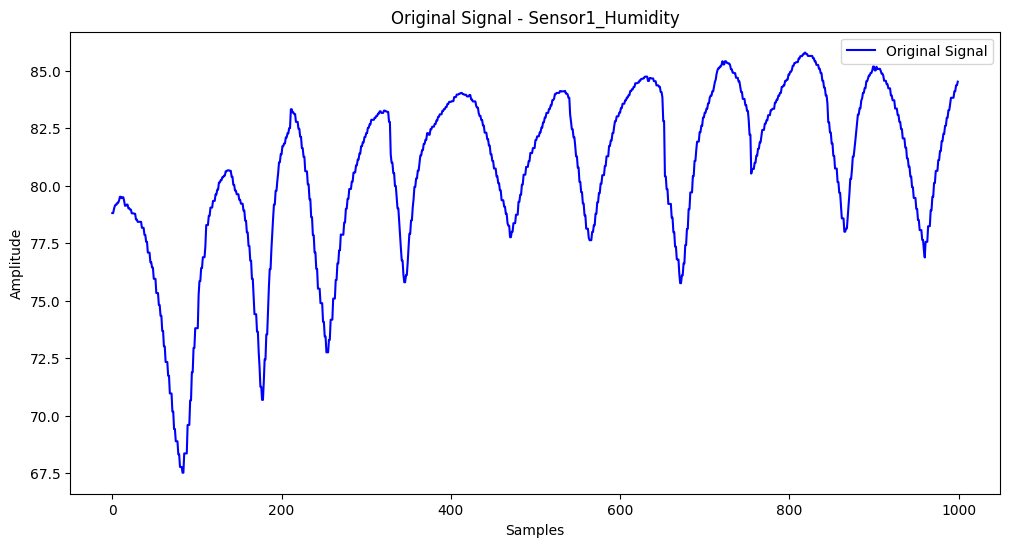

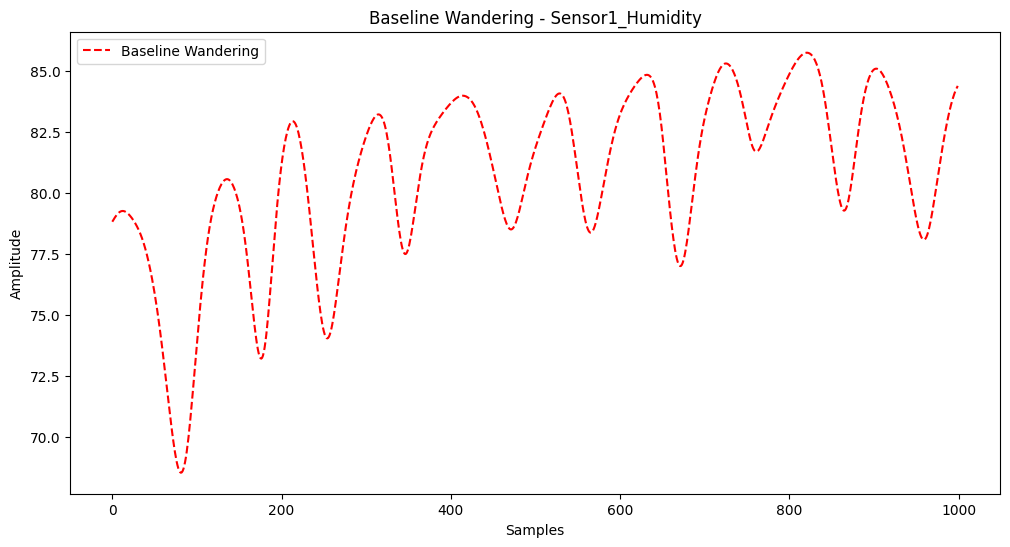

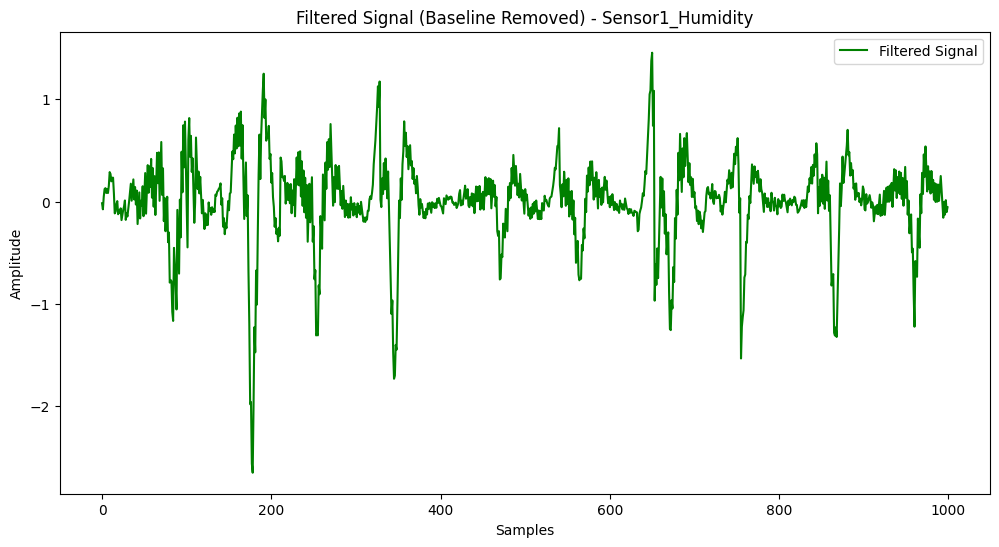

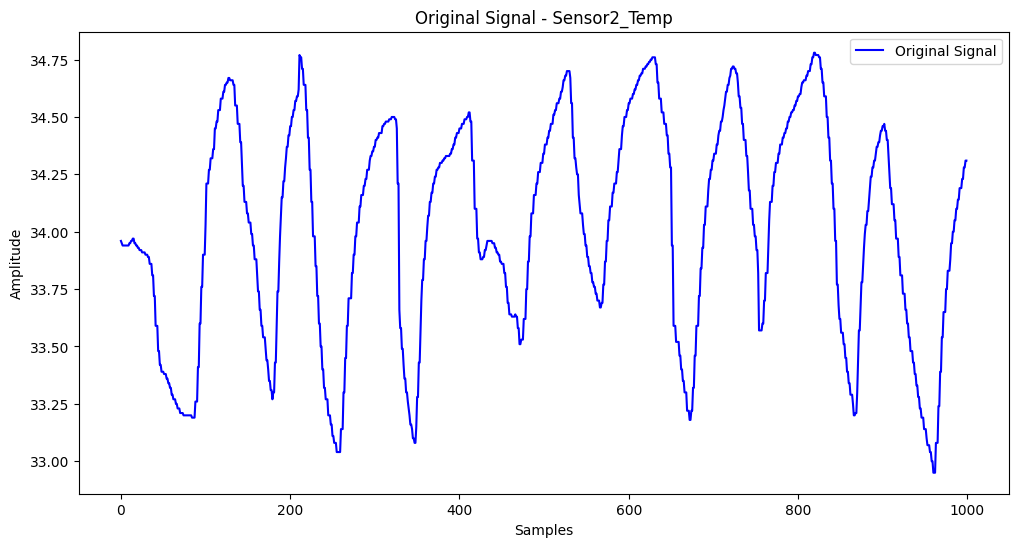

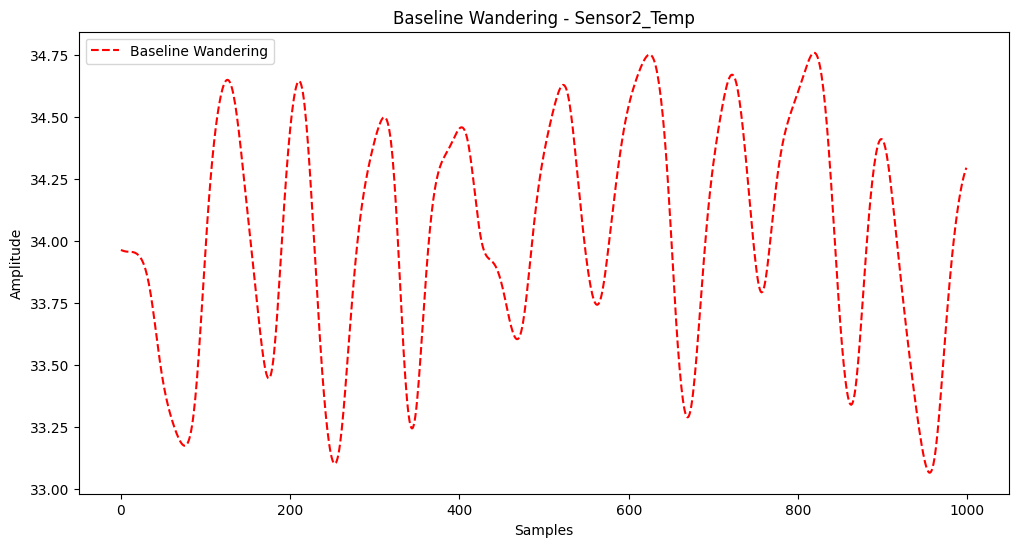

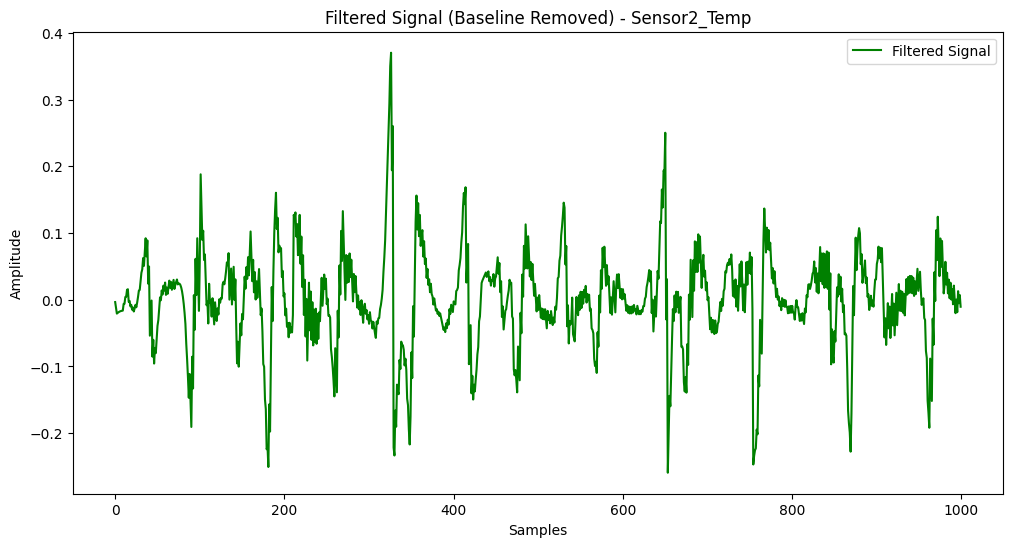

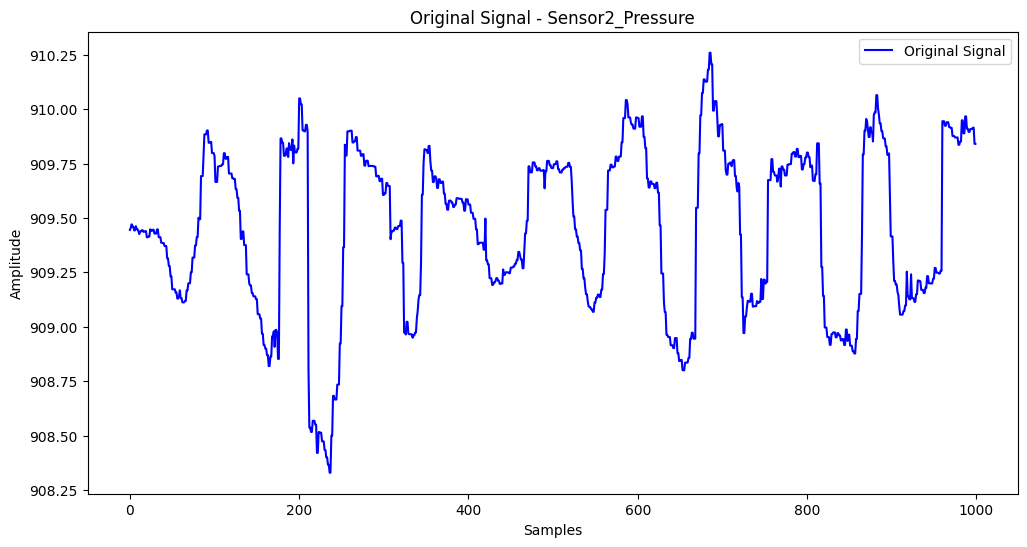

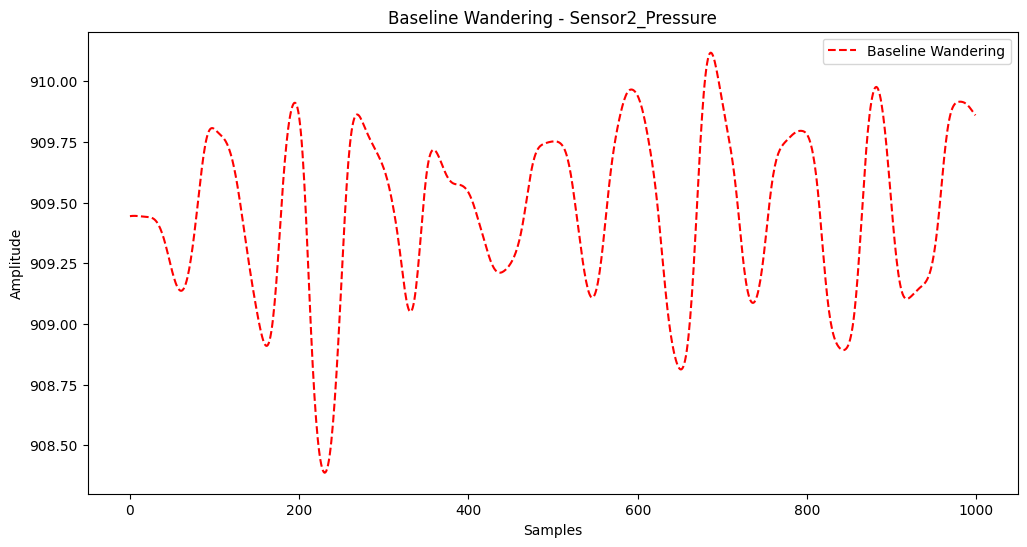

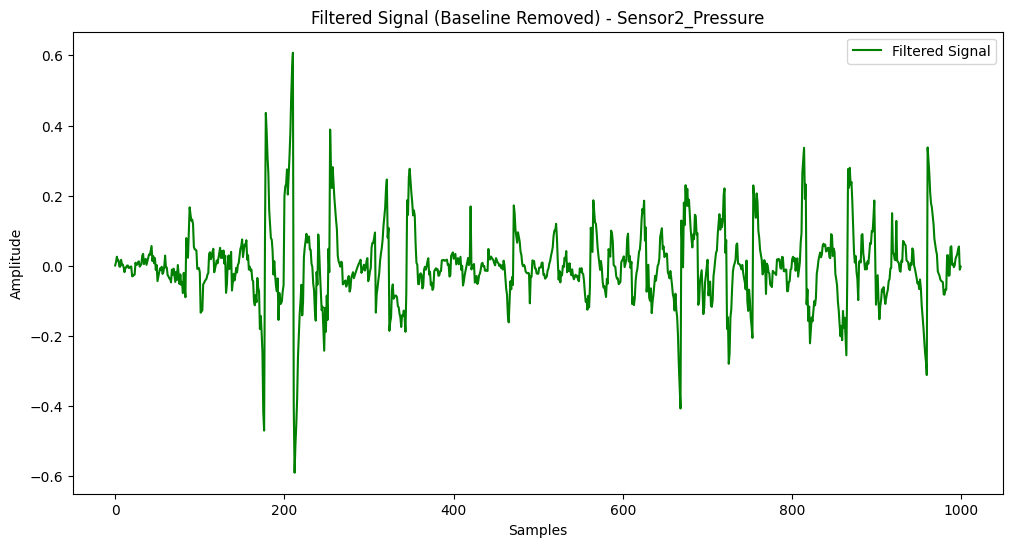

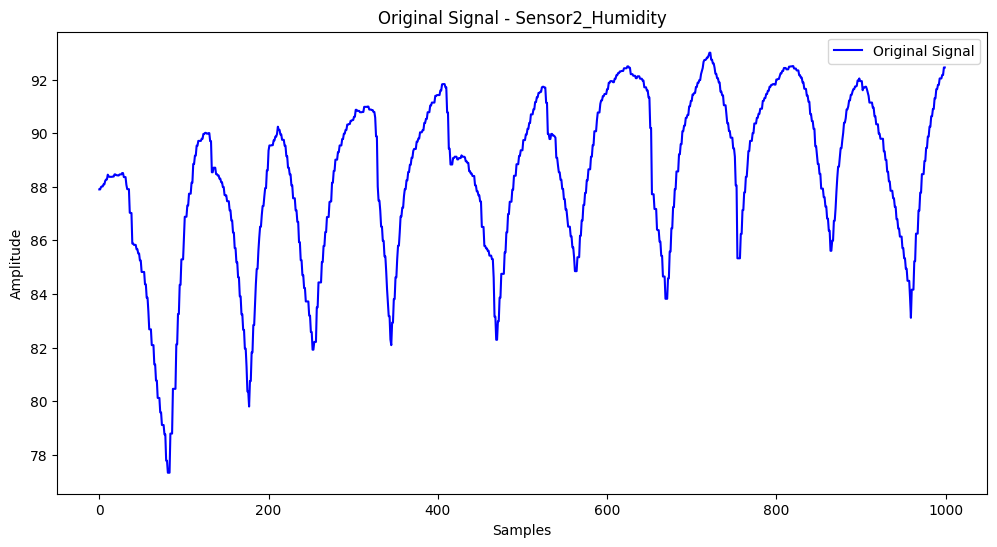

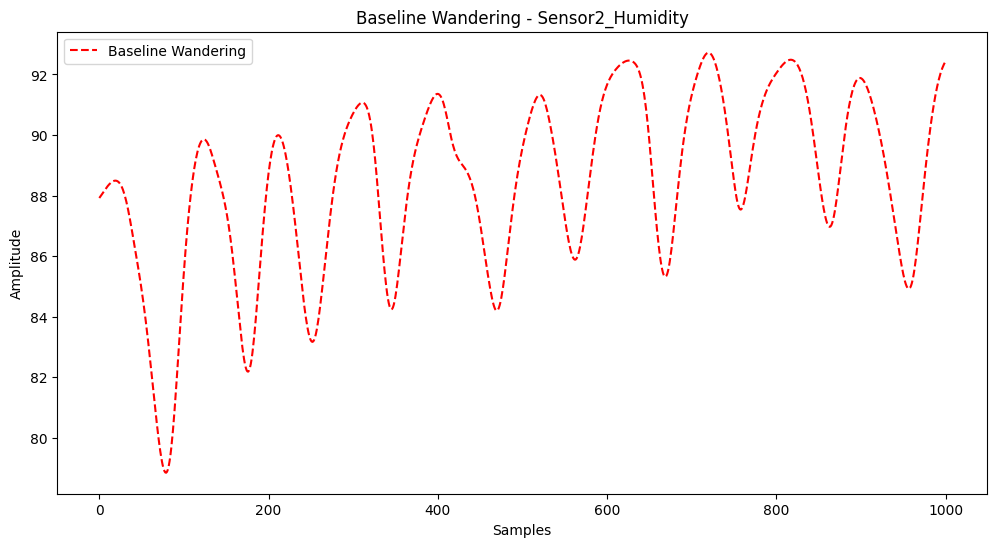

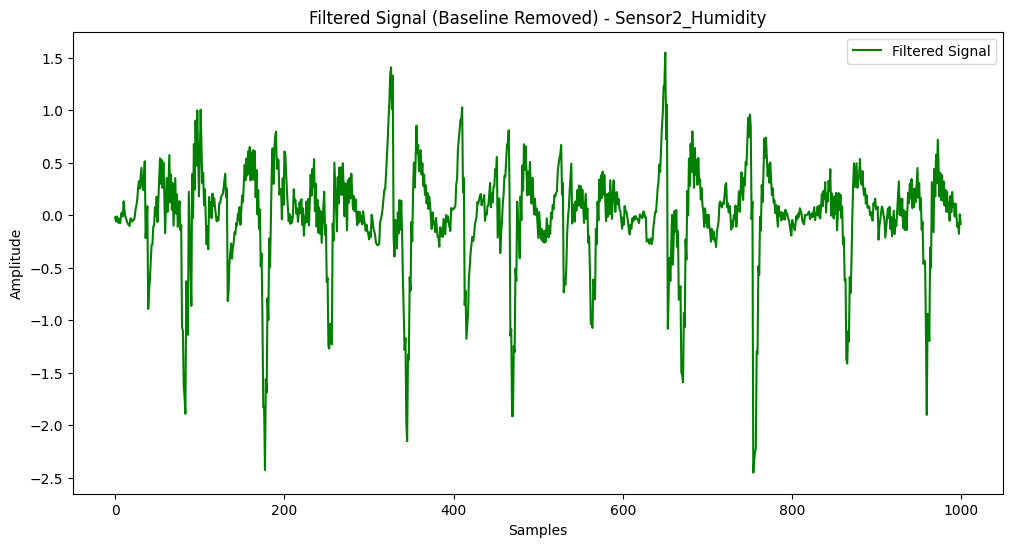

Epoch 1/100
294/294 [==============================] - 8s 15ms/step - loss: 0.5708 - val_loss: 0.6077
Epoch 2/100
294/294 [==============================] - 3s 11ms/step - loss: 0.5469 - val_loss: 0.6023
Epoch 3/100
294/294 [==============================] - 3s 11ms/step - loss: 0.5447 - val_loss: 0.6006
Epoch 4/100
294/294 [==============================] - 3s 11ms/step - loss: 0.5435 - val_loss: 0.6001
Epoch 5/100
294/294 [==============================] - 3s 11ms/step - loss: 0.5429 - val_loss: 0.5995
Epoch 6/100
294/294 [==============================] - 3s 11ms/step - loss: 0.5425 - val_loss: 0.5985
Epoch 7/100
294/294 [==============================] - 3s 11ms/step - loss: 0.5421 - val_loss: 0.5986
Epoch 8/100
294/294 [==============================] - 3s 11ms/step - loss: 0.5418 - val_loss: 0.5988
Epoch 9/100
294/294 [==============================] - 4s 12ms/step - loss: 0.5416 - val_loss: 0.5990
Epoch 10/100
294/294 [==============================] - 3s 11ms/step - loss: 0.541

In [2]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=19.62, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Low-pass filter for baseline wandering extraction
def low_pass_filter(signal, fs=19.62, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    filtered_signal = np.where(np.abs(z_scores) > threshold, np.median(signal), signal)
    return filtered_signal

# Function to compute metrics (Updated to handle classification properly)
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred >= threshold).astype(int)  # Convert continuous values to binary
    y_true = (y_true >= threshold).astype(int)  # Ensure y_true is also binary

    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    specificity = recall_score(y_true.flatten(), y_pred.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
    loss = np.mean((y_true - y_pred) ** 2)
    return accuracy, specificity, f1, loss

# Load datasets
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\nDatasets Loaded Successfully!\n")
    dataset_info = pd.DataFrame({
        "File Name": [file.split("/")[-1] for file in file_paths],
        "Rows": [len(pd.read_csv(file)) for file in file_paths],
        "Columns": [len(pd.read_csv(file).columns) for file in file_paths]
    })
    print(dataset_info)

    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        for col in numeric_columns:
            signal = df[col].fillna(0)[:1000]  # First 1000 samples
            
            # Plot original signal
            plt.figure(figsize=(12, 6))
            plt.plot(signal, label="Original Signal", color='b')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Original Signal - {col}")
            plt.legend()
            plt.show()

            # Detect and remove baseline wandering
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)
            
            # Plot baseline wandering
            plt.figure(figsize=(12, 6))
            plt.plot(baseline_wandering, label="Baseline Wandering", color='r', linestyle='dashed')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Baseline Wandering - {col}")
            plt.legend()
            plt.show()

            # Plot filtered signal
            plt.figure(figsize=(12, 6))
            plt.plot(filtered_signal, label="Filtered Signal", color='g')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Filtered Signal (Baseline Removed) - {col}")
            plt.legend()
            plt.show()

        # Prepare dataset for training
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build LSTM Model (Updated with sigmoid activation for binary classification)
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns), activation='sigmoid')  # Using sigmoid for binary classification
        ])
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy')
        history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        # Predictions
        y_pred_lstm = lstm_model.predict(X_test)
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

        # Build Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return torch.sigmoid(self.fc(x[:, -1, :]))  # Sigmoid for binary classification

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        transformer_losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
            output = transformer_model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()
            transformer_losses.append(loss.item())

        # Predictions
        y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
        trans_acc, trans_spec, trans_f1, trans_loss = calculate_metrics(y_test, y_pred_transformer)

        # Model Performance Table
        model_performance = pd.DataFrame({
            "Model": ["LSTM", "Transformer"],
            "Loss": [lstm_loss, trans_loss],
            "Accuracy": [lstm_acc, trans_acc],
            "F1 Score": [lstm_f1, trans_f1],
            "Specificity": [lstm_spec, trans_spec]
        })
        print("\nModel Performance Metrics Table:\n", model_performance)

else:
    print("No file selected. Please upload a valid dataset.")


In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# GUI for file selection
class SignalAnalysisApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Breathing Pattern Analysis")

        self.file_paths = []

        # GUI Components
        self.label = tk.Label(root, text="Select CSV files for analysis:")
        self.label.pack(pady=10)

        self.btn_load = tk.Button(root, text="Load Files", command=self.load_files)
        self.btn_load.pack(pady=5)

        self.btn_process = tk.Button(root, text="Start Analysis", command=self.start_analysis, state=tk.DISABLED)
        self.btn_process.pack(pady=5)

        self.text_log = tk.Text(root, height=10, width=60)
        self.text_log.pack(pady=10)

    def log(self, message):
        """Logs messages to the GUI"""
        self.text_log.insert(tk.END, message + "\n")
        self.text_log.see(tk.END)
        self.root.update()

    def load_files(self):
        """Loads multiple CSV files"""
        self.file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
        if self.file_paths:
            self.log(f"Loaded {len(self.file_paths)} files.")
            self.btn_process.config(state=tk.NORMAL)

    def start_analysis(self):
        """Main function to process signals and train models"""
        if not self.file_paths:
            messagebox.showerror("Error", "No files selected!")
            return

        # Load datasets
        self.log("Loading datasets...")
        dataframes = [pd.read_csv(file) for file in self.file_paths]
        df = pd.concat(dataframes, ignore_index=True)

        numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
        if not numeric_columns:
            self.log("No numeric columns found.")
            return

        # Function for High-Pass Filter (Baseline Wandering Removal)
        def high_pass_filter(signal, fs=100, cutoff=0.5):
            nyquist = 0.5 * fs
            normal_cutoff = cutoff / nyquist
            b, a = butter(2, normal_cutoff, btype='high', analog=False)
            return filtfilt(b, a, signal)

        # Function for Low-Pass Filter (Baseline Wandering Extraction)
        def low_pass_filter(signal, fs=100, cutoff=0.5):
            nyquist = 0.5 * fs
            normal_cutoff = cutoff / nyquist
            b, a = butter(2, normal_cutoff, btype='low', analog=False)
            return filtfilt(b, a, signal)

        # Function to Remove Outliers using Z-Score
        def remove_outliers(signal, threshold=3):
            z_scores = zscore(signal)
            filtered_signal = np.where(np.abs(z_scores) > threshold, np.median(signal), signal)
            return filtered_signal

        # Function to Compute Performance Metrics
        def calculate_metrics(y_true, y_pred, threshold=0.5):
            y_pred = (y_pred >= threshold).astype(int)
            y_true = (y_true >= threshold).astype(int)

            accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
            specificity = recall_score(y_true.flatten(), y_pred.flatten(), pos_label=0, zero_division=1)
            f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
            loss = np.mean((y_true - y_pred) ** 2)
            return accuracy, specificity, f1, loss

        # Process and Plot Signals
        self.log("Processing signals...")
        for col in numeric_columns:
            signal = df[col].fillna(0)[:1000]

            # Apply Filters
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)

            # Remove Outliers
            cleaned_signal = remove_outliers(filtered_signal)

            # Plot Original, Baseline Wandering, and Cleaned Signal
            plt.figure(figsize=(12, 6))
            plt.plot(signal, label="Original Signal", color='b')
            plt.plot(baseline_wandering, label="Baseline Wandering", color='r', linestyle='dashed')
            plt.plot(cleaned_signal, label="Cleaned Signal", color='g')
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.title(f"Signal Processing - {col}")
            plt.legend()
            plt.show()

        # Normalize and Prepare Data for Model Training
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])

        X, y = np.array(X), np.array(y)
        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Train LSTM Model
        self.log("Training LSTM model...")
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns), activation='sigmoid')
        ])
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy')
        lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)
        y_pred_lstm = lstm_model.predict(X_test)
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

        # Train Transformer Model
        self.log("Training Transformer model...")
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return torch.sigmoid(self.fc(x[:, -1, :]))

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
        for epoch in range(100):
            optimizer.zero_grad()
            output = transformer_model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(output, torch.tensor(y_train, dtype=torch.float32))
            loss.backward()
            optimizer.step()

        y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
        trans_acc, trans_spec, trans_f1, trans_loss = calculate_metrics(y_test, y_pred_transformer)

        self.log("Analysis Completed!")

# Run GUI
root = tk.Tk()
app = SignalAnalysisApp(root)
root.mainloop()


KeyboardInterrupt: 

In [2]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Low-pass filter for baseline wandering extraction
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    filtered_signal = np.where(np.abs(z_scores) > threshold, np.median(signal), signal)
    return filtered_signal

# Function to compute metrics
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred >= threshold).astype(int)
    y_true = (y_true >= threshold).astype(int)

    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    specificity = recall_score(y_true.flatten(), y_pred.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
    loss = np.mean((y_true - y_pred) ** 2)
    return accuracy, specificity, f1, loss

# Load datasets
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\nDatasets Loaded Successfully!\n")
    dataset_info = pd.DataFrame({
        "File Name": [file.split("/")[-1] for file in file_paths],
        "Rows": [len(pd.read_csv(file)) for file in file_paths],
        "Columns": [len(pd.read_csv(file).columns) for file in file_paths]
    })
    print(dataset_info)

    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        df = df[numeric_columns].fillna(0).iloc[:1000]  # Select only the first 1000 samples

        # Normalize the dataset
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df)

        # Create sequences for LSTM/Transformer training
        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns), activation='sigmoid')
        ])
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy')

        # Train LSTM and store results at different epochs
        epoch_checkpoints = [10, 30, 40, 50, 75, 100]
        lstm_results = []

        for epoch in epoch_checkpoints:
            history_lstm = lstm_model.fit(X_train, y_train, epochs=epoch, batch_size=16, validation_data=(X_test, y_test), verbose=1)
            y_pred_lstm = lstm_model.predict(X_test)
            lstm_metrics = calculate_metrics(y_test, y_pred_lstm)
            lstm_results.append([epoch] + list(lstm_metrics))

        # Build Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return torch.sigmoid(self.fc(x[:, -1, :]))

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        transformer_results = []
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        for epoch in epoch_checkpoints:
            for _ in range(epoch):
                optimizer.zero_grad()
                output = transformer_model(X_train_tensor)
                loss = criterion(output, y_train_tensor)
                loss.backward()
                optimizer.step()

            y_pred_transformer = transformer_model(X_test_tensor).detach().numpy()
            trans_metrics = calculate_metrics(y_test, y_pred_transformer)
            transformer_results.append([epoch] + list(trans_metrics))

        # Model Performance Table
        performance_df = pd.DataFrame({
            "Epochs": epoch_checkpoints,
            "LSTM Loss": [row[1] for row in lstm_results],
            "LSTM Accuracy": [row[2] for row in lstm_results],
            "LSTM F1 Score": [row[3] for row in lstm_results],
            "LSTM Specificity": [row[4] for row in lstm_results],
            "Transformer Loss": [row[1] for row in transformer_results],
            "Transformer Accuracy": [row[2] for row in transformer_results],
            "Transformer F1 Score": [row[3] for row in transformer_results],
            "Transformer Specificity": [row[4] for row in transformer_results],
        })

        print("\nPerformance Metrics at Different Epochs:\n")
        print(performance_df.to_string(index=False))

else:
    print("No file selected. Please upload a valid dataset.") 
    



Datasets Loaded Successfully!

                        File Name  Rows  Columns
0  Ashvin_5Mins_NB_20_02_2025.csv  5884        6
Epoch 1/10
50/50 [==============================] - 4s 23ms/step - loss: 0.6366 - val_loss: 0.5816
Epoch 2/10
50/50 [==============================] - 1s 11ms/step - loss: 0.5868 - val_loss: 0.5527
Epoch 3/10
50/50 [==============================] - 1s 11ms/step - loss: 0.5778 - val_loss: 0.5446
Epoch 4/10
50/50 [==============================] - 1s 11ms/step - loss: 0.5713 - val_loss: 0.5425
Epoch 5/10
50/50 [==============================] - 1s 12ms/step - loss: 0.5679 - val_loss: 0.5341
Epoch 6/10
50/50 [==============================] - 1s 11ms/step - loss: 0.5671 - val_loss: 0.5346
Epoch 7/10
50/50 [==============================] - 1s 11ms/step - loss: 0.5668 - val_loss: 0.5309
Epoch 8/10
50/50 [==============================] - 1s 13ms/step - loss: 0.5661 - val_loss: 0.5292
Epoch 9/10
50/50 [==============================] - 1s 13ms/step - loss: 0.564

In [1]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Low-pass filter for baseline wandering extraction
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    filtered_signal = np.where(np.abs(z_scores) > threshold, np.median(signal), signal)
    return filtered_signal

# Function to compute metrics
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred >= threshold).astype(int)
    y_true = (y_true >= threshold).astype(int)

    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    specificity = recall_score(y_true.flatten(), y_pred.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
    loss = np.mean((y_true - y_pred) ** 2)
    return accuracy, specificity, f1, loss

# Load datasets
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    print("\nDatasets Loaded Successfully!\n")
    dataset_info = pd.DataFrame({
        "File Name": [file.split("/")[-1] for file in file_paths],
        "Rows": [len(pd.read_csv(file)) for file in file_paths],
        "Columns": [len(pd.read_csv(file).columns) for file in file_paths]
    })
    print(dataset_info)

    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    if not numeric_columns:
        print("No numeric columns found in the dataset.")
    else:
        df = df[numeric_columns].fillna(0).iloc[:1000]  # Select only the first 1000 samples

        # Normalize the dataset
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df)

        # Create sequences for LSTM/Transformer training
        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dense(len(numeric_columns), activation='sigmoid')
        ])
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy')

        # Train LSTM and store results at different epochs
        epoch_checkpoints = [10, 30, 40, 50, 75, 100]
        lstm_results = []

        for epoch in epoch_checkpoints:
            history_lstm = lstm_model.fit(X_train, y_train, epochs=epoch, batch_size=16, validation_data=(X_test, y_test), verbose=1)
            y_pred_lstm = lstm_model.predict(X_test)
            lstm_metrics = calculate_metrics(y_test, y_pred_lstm)
            lstm_results.append([epoch] + list(lstm_metrics))

        # Build Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return torch.sigmoid(self.fc(x[:, -1, :]))

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        transformer_results = []
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        for epoch in epoch_checkpoints:
            for _ in range(epoch):
                optimizer.zero_grad()
                output = transformer_model(X_train_tensor)
                loss = criterion(output, y_train_tensor)
                loss.backward()
                optimizer.step()

            y_pred_transformer = transformer_model(X_test_tensor).detach().numpy()
            trans_metrics = calculate_metrics(y_test, y_pred_transformer)
            transformer_results.append([epoch] + list(trans_metrics))

        # Model Performance Table
        performance_df = pd.DataFrame({
            "Epochs": epoch_checkpoints,
            "LSTM Loss": [row[1] for row in lstm_results],
            "LSTM Accuracy": [row[2] for row in lstm_results],
            "LSTM F1 Score": [row[3] for row in lstm_results],
            "LSTM Specificity": [row[4] for row in lstm_results],
            "Transformer Loss": [row[1] for row in transformer_results],
            "Transformer Accuracy": [row[2] for row in transformer_results],
            "Transformer F1 Score": [row[3] for row in transformer_results],
            "Transformer Specificity": [row[4] for row in transformer_results],
        })

        print("\nPerformance Metrics at Different Epochs:\n")
        print(performance_df.to_string(index=False))

else:
    print("No file selected. Please upload a valid dataset.")


Datasets Loaded Successfully!

                        File Name  Rows  Columns
0  Ashvin_5Mins_NB_20_02_2025.csv  5884        6
Epoch 1/10
50/50 [==============================] - 5s 24ms/step - loss: 0.6367 - val_loss: 0.5851
Epoch 2/10
50/50 [==============================] - 1s 14ms/step - loss: 0.5969 - val_loss: 0.5674
Epoch 3/10
50/50 [==============================] - 1s 14ms/step - loss: 0.5842 - val_loss: 0.5583
Epoch 4/10
50/50 [==============================] - 1s 13ms/step - loss: 0.5750 - val_loss: 0.5446
Epoch 5/10
50/50 [==============================] - 1s 13ms/step - loss: 0.5699 - val_loss: 0.5405
Epoch 6/10
50/50 [==============================] - 1s 14ms/step - loss: 0.5686 - val_loss: 0.5399
Epoch 7/10
50/50 [==============================] - 1s 12ms/step - loss: 0.5667 - val_loss: 0.5365
Epoch 8/10
50/50 [==============================] - 1s 14ms/step - loss: 0.5658 - val_loss: 0.5381
Epoch 9/10
50/50 [==============================] - 1s 14ms/step - loss: 0.564